In [73]:
import platform
import os

# Get information about the operating system
os_info = platform.system()
os_version = platform.version()

# Get information about the machine's architecture
architecture = platform.machine()

# Get the current working directory
current_directory = os.getcwd()

# Print the information
print(f"Operating System: {os_info} {os_version}")
print(f"Architecture: {architecture}")
print(f"Current Directory: {current_directory}")

Operating System: Darwin Darwin Kernel Version 23.0.0: Fri Sep 15 14:41:34 PDT 2023; root:xnu-10002.1.13~1/RELEASE_ARM64_T8103
Architecture: arm64
Current Directory: /Users/marwan/Desktop/UNIMI/Lezioni/1st Year 2021:22/Machine Learning, Statistical Learning, Deep Learning and Artificial Intelligence/Project/Ridge Regression


# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.kernel_ridge import KernelRidge
from sklearn import linear_model
from prettytable import PrettyTable

from sklearn.preprocessing import StandardScaler, LabelEncoder

%matplotlib inline
from timeit import default_timer as timer
import time

from numba import jit, njit

import warnings
warnings.filterwarnings("ignore")

colors_scratch = ["#20BF55", "#0B4F6C", "#01BAEF", "#2EC0F9", "#67AAF9", "#0B3142"]
colors_scikit = ["#81F499", "#F3B61F", "#FF331F", "#3626A7", "#F18701", "#23967F"]

start = timer()

# Functions

In [2]:
# Class object that handles ridge regression function
class RidgeRegression:
    def __init__(self, alpha=1.0):
        self.alpha = alpha
        self.coefficients = None
        self.mse = None
        self.mae = None
        self.rmse = None
        self.r2_score = None
        self.r2_adj = None
        
    def fit(self, X, y):
        # Add a column of ones to X for the intercept term
        X_augmented = np.column_stack((np.ones(X.shape[0]), X))
        # Calculate the coefficients using the closed-form solution
        A = X_augmented.T.dot(X_augmented) + self.alpha * np.identity(X_augmented.shape[1]) #(S^T S + aI)
        b = X_augmented.T.dot(y) # (S^T y)
        try:
            self.coefficients = np.linalg.solve(A, b)
        except np.linalg.LinAlgError as e:
            print("Error:", e)
            print("The matrix A might be singular. Check your data or try a different alpha value.")
        return self.coefficients

    def predict(self, X):
        if self.coefficients is not None:
            # Add a column of ones to X for the intercept term
            X_augmented = np.column_stack((np.ones(X.shape[0]), X))
            return X_augmented.dot(self.coefficients)
        else:
            raise ValueError("The model has not been trained yet. Train it using the fit() function.")
            
    def calculate_mse(self, X, y):
        # Calculate the predicted values
        y_hat = self.predict(X)
        # Calculate the mean squared error
        mse = np.mean((y - y_hat) ** 2)
        self.mse = mse
        return mse

    def calculate_mae(self, X, y):
        # Calculate the predicted values
        y_hat = self.predict(X)
        # Calculate the mean squared error
        mae = np.mean(np.abs(y - y_hat))
        self.mae = mae
        return mae

    def calculate_rmse(self, X, y):
        # Calculate the predicted values
        y_hat = self.predict(X)
        # Calculate the mean squared error
        mse = np.mean((y - y_hat) ** 2)
        rmse = np.sqrt(mse)
        self.rmse = rmse
        return rmse

In [3]:
# Function for data pre-processing
@jit
def prepare_data(df):
    df = df.drop(columns='Unnamed: 0')
    df = df.sample(frac=1, random_state=42)
    df = df.dropna()
    df['duration'] = df['duration_ms']/1000
    df.drop('duration_ms', axis=1, inplace=True)
    df['explicit'] = df['explicit'].astype(int)
    return df

In [4]:
# Function for correlation analysis
@jit
def correlation_analysis(data, numerical_cols):
    corr = data[numerical_cols].corr()
    high_corr_features = corr[((corr > 0.75) | (corr < -0.80)) & (corr != 1.0)].dropna(axis='index', how='all')
    
    plt.figure(figsize=(6, 4))
    sns.heatmap(corr, vmax=0.8, linewidths=0.01, square=True, annot=False, cmap='YlGnBu', linecolor="white")
    plt.title('Correlation between numerical features')
    return high_corr_features

In [5]:
# Function for outliers analysis
@jit
def outliers_analysis(df, column_list, path):
    num_cols = len(column_list)
    rows = 5
    cols = 3
    subplots = min(num_cols, rows * cols)
    
    fig, axs = plt.subplots(rows, cols, figsize=(12, 10))
    
    for i, ax in enumerate(axs.ravel()):
        if i < subplots:
            sns.boxplot(x=column_list[i], data=df, ax=ax)
            ax.set_title(f'Boxplot for {column_list[i]}')
    
    for i in range(subplots, rows * cols):
        fig.delaxes(axs.flatten()[i])
    
    plt.tight_layout()
    plt.savefig(path + 'outliers_analysis.png', dpi=200, format='png', bbox_inches='tight')
    plt.show()
    
    outlier_data = []
    for variable in column_list:
        iqr = np.percentile(df[variable], 75) - np.percentile(df[variable], 25)
        top_bound = np.percentile(df[variable], 75) + 1.5 * iqr
        lower_bound = np.percentile(df[variable], 25) - 1.5 * iqr
        outlier_data.append({'Name': variable, 'Upper_Bound': top_bound, 'Lower_Bound': lower_bound})

    outlier_df = pd.DataFrame(outlier_data)
    outlier_data = print(outlier_df)
    return outlier_data

In [6]:
# Function for data processing
@jit
def processing_data(df):
    df_g=pd.get_dummies(df[["track_id", "track_genre"]], columns=['track_genre'], dtype=int)
    df_gen=df_g.groupby("track_id", as_index=False)[[i for i in df_g.columns if i.startswith("track_genre_")]].agg(np.sum)
    df_enc=pd.get_dummies(df.drop(columns=["artists", "album_name", "track_name", 'track_genre']), columns=['explicit', 'key', 'mode', 'time_signature'], dtype=int) \
               .drop_duplicates(subset=['track_id'])
    tot_df=pd.merge(df_enc, df_gen, on=['track_id'], how='inner').drop(columns="track_id")
    tot_df=tot_df.drop(columns=["explicit_0"])
    tot_df=tot_df.rename(columns={"explicit_1": "explicit"})

    #Normalization of the features
    for feature in tot_df.columns:
        tot_df[feature] = ((tot_df[feature] - tot_df[feature].min()) / (tot_df[feature].max() - tot_df[feature].min()))
    return tot_df

In [7]:
# Function for splitting between categorical and numerical features in dataset: df is the complete one (total_data), old_df is the data that have been uploaded initially
@jit
def num_cat_split(df, old_df):
    cols=old_df[['popularity', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 
                   'instrumentalness', 'liveness', 'valence', 'tempo', 'duration']].columns
    n_data=df[cols]
    print("The size of the dataset used for the total features is : ", df.shape)
    print("The size of the dataset used for the numerical features is : ", n_data.shape)
    return n_data

In [8]:
# Function to perform train-test-validation split on the dataset
@jit
def split_data(n_df, c_df, random_state=42, train_size=0.7, val_size=0.15):
    X_n, y_n = n_df.drop(columns='popularity', axis=1), n_df['popularity']
    X_c, y_c = c_df.drop(columns='popularity', axis=1), c_df['popularity']

    # Split data into train and temp (which combines val and test)
    X_tra_n, X_tem_n, y_tra_n, y_tem_n = train_test_split(X_n, y_n, train_size=train_size, random_state=random_state)
    X_tra_c, X_tem_c, y_tra_c, y_tem_c = train_test_split(X_c, y_c, train_size=train_size, random_state=random_state)

    # Split the temp data into validation and test
    X_val_n, X_tes_n, y_val_n, y_tes_n = train_test_split(X_tem_n, y_tem_n, test_size=val_size / (1 - train_size), random_state=random_state)
    X_val_c, X_tes_c, y_val_c, y_tes_c = train_test_split(X_tem_c, y_tem_c, test_size=val_size / (1 - train_size), random_state=random_state)

    return X_tra_n, X_val_n, X_tes_n, y_tra_n, y_val_n, y_tes_n, X_tra_c, X_val_c, X_tes_c, y_tra_c, y_val_c, y_tes_c

In [9]:
# Define function to perform ridge regression from scratch (both for the ridge and linear case)
@jit
def scratch_ridge_regression(alphas, X_train, y_train, X_val, y_val, X_test, y_test):
    train_loss_mse, val_loss_mse, test_loss_mse = [], [], []
    train_loss_rmse, val_loss_rmse, test_loss_rmse = [], [], []
    train_loss_mae, val_loss_mae, test_loss_mae = [], [], []

    for alpha in alphas:
        ridge_model_num = RidgeRegression(alpha=alpha)
        ridge_model_num.fit(X_train, y_train)
 
        train_loss_mse.append(ridge_model_num.calculate_mse(X_train, y_train))
        val_loss_mse.append(ridge_model_num.calculate_mse(X_val, y_val))
        test_loss_mse.append(ridge_model_num.calculate_mse(X_test, y_test))
        
        train_loss_rmse.append(ridge_model_num.calculate_rmse(X_train, y_train))
        val_loss_rmse.append(ridge_model_num.calculate_rmse(X_val, y_val))
        test_loss_rmse.append(ridge_model_num.calculate_rmse(X_test, y_test))

        train_loss_mae.append(ridge_model_num.calculate_mae(X_train, y_train))
        val_loss_mae.append(ridge_model_num.calculate_mae(X_val, y_val))
        test_loss_mae.append(ridge_model_num.calculate_mae(X_test, y_test))

    return train_loss_mse, val_loss_mse, test_loss_mse, train_loss_rmse, val_loss_rmse, test_loss_rmse, train_loss_mae, val_loss_mae, test_loss_mae

In [10]:
# Define function to perform ridge regression using scikit-learn (both for the ridge and linear case)
@jit
def scikit_ridge_regression(alphas, X_train, y_train, X_val, y_val, X_test, y_test):
    train_loss_mse, val_loss_mse, test_loss_mse = [], [], []
    train_loss_rmse, val_loss_rmse, test_loss_rmse = [], [], []
    train_loss_mae, val_loss_mae, test_loss_mae = [], [], []

    for alpha in alphas:
        sk_ridge_model_num = Ridge(alpha=alpha)
        sk_ridge_model_num.fit(X_train, y_train)
 
        train_loss_mse.append(mean_squared_error(y_train, sk_ridge_model_num.predict(X_train)))
        val_loss_mse.append(mean_squared_error(y_val, sk_ridge_model_num.predict(X_val)))
        test_loss_mse.append(mean_squared_error(y_test, sk_ridge_model_num.predict(X_test)))
        
        train_loss_rmse.append(np.sqrt(mean_squared_error(y_train, sk_ridge_model_num.predict(X_train))))
        val_loss_rmse.append(np.sqrt(mean_squared_error(y_val, sk_ridge_model_num.predict(X_val))))
        test_loss_rmse.append(np.sqrt(mean_squared_error(y_test, sk_ridge_model_num.predict(X_test))))

        train_loss_mae.append(mean_absolute_error(y_train, sk_ridge_model_num.predict(X_train)))
        val_loss_mae.append(mean_absolute_error(y_val, sk_ridge_model_num.predict(X_val)))
        test_loss_mae.append(mean_absolute_error(y_test, sk_ridge_model_num.predict(X_test)))

    return train_loss_mse, val_loss_mse, test_loss_mse, train_loss_rmse, val_loss_rmse, test_loss_rmse, train_loss_mae, val_loss_mae, test_loss_mae

In [11]:
# Define function to perform linear regression (only for linear case)
@jit
def linear_regression(X_train, y_train, X_val, y_val, X_test, y_test):
    train_loss_mse, val_loss_mse, test_loss_mse = [], [], []
    train_loss_rmse, val_loss_rmse, test_loss_rmse = [], [], []
    train_loss_mae, val_loss_mae, test_loss_mae = [], [], []

    lin_reg = linear_model.LinearRegression()
    lin_reg.fit(X_train, y_train)

    train_loss_mse.append(mean_squared_error(y_train, lin_reg.predict(X_train)))
    val_loss_mse.append(mean_squared_error(y_val, lin_reg.predict(X_val)))
    test_loss_mse.append(mean_squared_error(y_test, lin_reg.predict(X_test)))
        
    train_loss_rmse.append(np.sqrt(mean_squared_error(y_train, lin_reg.predict(X_train))))
    val_loss_rmse.append(np.sqrt(mean_squared_error(y_val, lin_reg.predict(X_val))))
    test_loss_rmse.append(np.sqrt(mean_squared_error(y_test, lin_reg.predict(X_test))))

    train_loss_mae.append(mean_absolute_error(y_train, lin_reg.predict(X_train)))
    val_loss_mae.append(mean_absolute_error(y_val, lin_reg.predict(X_val)))
    test_loss_mae.append(mean_absolute_error(y_test, lin_reg.predict(X_test)))

    return train_loss_mse, val_loss_mse, test_loss_mse, train_loss_rmse, val_loss_rmse, test_loss_rmse, train_loss_mae, val_loss_mae, test_loss_mae

In [12]:
# Define function to plot metrics for ridge regression (both numerical and categorical)
@jit
def plot_metrics_ridge_regression(alphas, colors_scratch, colors_scikit, \
                 train_loss_mse, val_loss_mse, test_loss_mse, \
                 sk_train_loss_mse, sk_val_loss_mse, sk_test_loss_mse, \
                 train_loss_rmse, val_loss_rmse, test_loss_rmse, \
                 sk_train_loss_rmse, sk_val_loss_rmse, sk_test_loss_rmse, \
                 train_loss_mae, val_loss_mae, test_loss_mae, \
                 sk_train_loss_mae, sk_val_loss_mae, sk_test_loss_mae, save_path_img, title_image_to_save):
    fig, axes = plt.subplots(3, 2)
    fig.suptitle('Metrics')
    fig.set_size_inches(10, 10)
    fig.tight_layout(pad=4.0)

    for i, ax in enumerate(axes.flat):
        plot_data = None
        title = ""

        if i == 0:
            plot_data = (alphas, train_loss_mse, val_loss_mse, test_loss_mse, colors_scratch, 'MSE', 'Scratch')
        elif i == 1:
            plot_data = (alphas, sk_train_loss_mse, sk_val_loss_mse, sk_test_loss_mse, colors_scikit, 'MSE', 'Scikit')
        elif i == 2:
            plot_data = (alphas, train_loss_rmse, val_loss_rmse, test_loss_rmse, colors_scratch, 'RMSE', 'Scratch')
        elif i == 3:
            plot_data = (alphas, sk_train_loss_rmse, sk_val_loss_rmse, sk_test_loss_rmse, colors_scikit, 'RMSE', 'Scikit')
        elif i == 4:
            plot_data = (alphas, train_loss_mae, val_loss_mae, test_loss_mae, colors_scratch, 'MAE', 'Scratch')
        elif i == 5:
            plot_data = (alphas, sk_train_loss_mae, sk_val_loss_mae, sk_test_loss_mae, colors_scikit, 'MAE', 'Scikit')

        ax.plot(plot_data[0], plot_data[1], label='Train', color=plot_data[4][0])
        ax.plot(plot_data[0], plot_data[2], label='Val', color=plot_data[4][1])
        ax.plot(plot_data[0], plot_data[3], label='Test', color=plot_data[4][2])
        ax.axhline(np.mean(plot_data[1]), color=plot_data[4][3], linestyle='--', label='Average Train')
        ax.axhline(np.mean(plot_data[2]), color=plot_data[4][4], linestyle='--', label='Average Val')
        ax.axhline(np.mean(plot_data[3]), color=plot_data[4][5], linestyle='--', label='Average Test')
        ax.set_xscale('log')
        ax.set_xlabel('Alpha')
        ax.set_ylabel(plot_data[5])
        ax.legend()
        ax.set_title(plot_data[6])

    plt.savefig(save_path_img + title_image_to_save, dpi=200, format='png', bbox_inches='tight')
    plt.show()

In [13]:
# Define function to plot metrics for linear regression (both numerical and categorical)
@jit
def plot_metrics_linear_regression(ax, title, model_values, ylabel):
    metrics = ('MSE', 'RMSE', 'MAE')
    x = np.arange(len(metrics))
    width = 0.25
    multiplier = 0

    for attribute, measurement in model_values.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, width, label=attribute)
        ax.bar_label(rects, padding=3)
        multiplier += 1

    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(x + width, metrics)
    ax.legend(loc='upper left', ncols=3)
    ax.set_ylim(0, 0.44)

In [14]:
@jit
def k_fold_cv_ridge_regression(dataset, alphas, folds):
    np.random.seed(42)
    # Randomize and reset index
    indices = np.arange(len(dataset))
    np.random.shuffle(indices)
    #dataset = dataset.sample(frac=1).reset_index(drop=True)
    
    # Set number of folds
    k = folds
    
    # Empty lists to store folds and results
    fold_i = []
    results_train_mse, results_test_mse, \
    results_train_rmse, results_test_rmse, \
    results_train_mae,  results_test_mae = [], [], [], [], [], []
    
    # Compute start and end index for each fold and create folds to append
    fold_size = len(dataset) // k
    
    for i in range(k):
        start_index = i * fold_size
        end_index = (i + 1) * fold_size if i < k - 1 else len(dataset)
        fold_indices = indices[start_index:end_index]
        fold = dataset.iloc[fold_indices]
        fold_i.append(fold)

    # Compute k-fold cv using metrics
    for i in range(k):
        train = pd.concat([fold_i[j] for j in range(k) if j != i])
        test = fold_i[i]
        # Compute train and test by dropping the target column
        X_train, y_train = train.drop(columns='popularity'), train['popularity']
        X_test, y_test = test.drop(columns='popularity'), test['popularity']
        
        # Empty lists to store results
        res_train_mse, res_test_mse, \
        res_train_rmse, res_test_rmse, \
        res_train_mae, res_test_mae = [], [], [], [], [], []

        best_alpha = None
        best_test_mse = float('inf')

        for alpha in alphas:
            ridge_model = RidgeRegression(alpha=alpha)
            ridge_model.fit(X_train, y_train)

            test_mse = ridge_model.calculate_mse(X_test, y_test)

            if test_mse < best_test_mse:
                best_alpha = alpha
                best_test_mse = test_mse

            res_train_mse.append(ridge_model.calculate_mse(X_train, y_train))
            res_train_rmse.append(ridge_model.calculate_rmse(X_train, y_train))
            res_train_mae.append(ridge_model.calculate_mae(X_train, y_train))
            res_test_mse.append(test_mse)
            res_test_rmse.append(ridge_model.calculate_rmse(X_test, y_test))
            res_test_mae.append(ridge_model.calculate_mae(X_test, y_test))

        results_train_mse.append(res_train_mse)
        results_train_rmse.append(res_train_rmse)
        results_train_mae.append(res_train_mae)
        results_test_mse.append(res_test_mse)
        results_test_rmse.append(res_test_rmse)
        results_test_mae.append(res_test_mae)

    return results_train_mse, results_train_rmse, results_train_mae, results_test_mse, results_test_rmse, results_test_mae, best_alpha

In [16]:
@jit
def k_fold_cv_scikit_ridge_regression(dataset, alphas, folds):
    np.random.seed(42)
    # Randomize and reset index
    indices = np.arange(len(dataset))
    np.random.shuffle(indices)
    #dataset = dataset.sample(frac=1).reset_index(drop=True)
    
    # Set number of folds
    k = folds
    
    # Empty lists to store folds and results
    fold_i = []
    results_train_mse, results_test_mse, \
    results_train_rmse, results_test_rmse, \
    results_train_mae,  results_test_mae = [], [], [], [], [], []
    
    # Compute start and end index for each fold and create folds to append
    fold_size = len(dataset) // k
    
    for i in range(k):
        start_index = i * fold_size
        end_index = (i + 1) * fold_size if i < k - 1 else len(dataset)
        fold_indices = indices[start_index:end_index]
        fold = dataset.iloc[fold_indices]
        fold_i.append(fold)

    # Compute k-fold cv using metrics
    for i in range(k):
        train = pd.concat([fold_i[j] for j in range(k) if j != i])
        test = fold_i[i]
        # Compute train and test by dropping the target column
        X_train, y_train = train.drop(columns='popularity'), train['popularity']
        X_test, y_test = test.drop(columns='popularity'), test['popularity']
        
        # Empty lists to store results
        res_train_mse, res_test_mse, \
        res_train_rmse, res_test_rmse, \
        res_train_mae, res_test_mae = [], [], [], [], [], []

        best_alpha = None
        best_test_mse = float('inf')

        for alpha in alphas:
            ridge_model_sk = RidgeCV(alphas=alpha)
            ridge_model_sk.fit(X_train, y_train)

            test_mse = mean_squared_error(y_test, ridge_model_sk.predict(X_test))

            if test_mse < best_test_mse:
                best_alpha = alpha
                best_test_mse = test_mse

            res_train_mse.append(mean_squared_error(y_train, ridge_model_sk.predict(X_train)))
            res_train_rmse.append(np.sqrt(mean_squared_error(y_train, ridge_model_sk.predict(X_train))))
            res_train_mae.append(mean_absolute_error(y_train, ridge_model_sk.predict(X_train)))
            res_test_mse.append(mean_squared_error(y_test, ridge_model_sk.predict(X_test)))
            res_test_rmse.append(np.sqrt(mean_squared_error(y_test, ridge_model_sk.predict(X_test))))
            res_test_mae.append(mean_absolute_error(y_test, ridge_model_sk.predict(X_test)))

        results_train_mse.append(res_train_mse)
        results_train_rmse.append(res_train_rmse)
        results_train_mae.append(res_train_mae)
        results_test_mse.append(res_test_mse)
        results_test_rmse.append(res_test_rmse)
        results_test_mae.append(res_test_mae)

    return results_train_mse, results_train_rmse, results_train_mae, results_test_mse, results_test_rmse, results_test_mae, best_alpha

In [17]:
# Define function to plot the results metrics for each fold in k-CV
@jit
def plot_cv_features(alphas, train, test, save_path_img, title, metric):
    # Create the subplots for plotting
    fig, axes = plt.subplots(1, 5, figsize=(30, 15))
    fig.suptitle(f'CV, k=5 - {metric.upper()}')

    for i, ax in enumerate(axes.flat):
        ax.plot(alphas, train[i], label='Train', color=colors_scratch[i])
        ax.plot(alphas, test[i], label='Test', color=colors_scikit[i])
        ax.axhline(np.mean(train[i]), color=colors_scratch[i+1], linestyle='--', label='Average Train')
        ax.axhline(np.mean(test[i]), color=colors_scikit[i+1], linestyle='--', label='Average Test')
        ax.set_xscale('log')
        ax.set_xlabel('Alpha')
        ax.set_ylabel(f'{metric.upper()}')
        ax.legend()
        ax.set_title(f"CV-{i + 1}")

    plt.savefig(save_path_img + title, dpi=200, format='png', bbox_inches='tight')
    plt.show()

# Prepare

## Setting paths for uploading and downloading

In [18]:
file_path = "/Users/marwan/Desktop/UNIMI/Lezioni/1st Year 2021:22/Machine Learning, Statistical Learning, Deep Learning and Artificial Intelligence/Project/Ridge Regression/dataset/dataset.csv"
save_path_img = "/Users/marwan/Desktop/UNIMI/Lezioni/1st Year 2021:22/Machine Learning, Statistical Learning, Deep Learning and Artificial Intelligence/Project/Ridge Regression/Latex/Images/"
save_path_csv = "/Users/marwan/Desktop/UNIMI/Lezioni/1st Year 2021:22/Machine Learning, Statistical Learning, Deep Learning and Artificial Intelligence/Project/Ridge Regression/dataset/"

## Importing the data and obtain basic informations

In [19]:
df = pd.read_csv(file_path)

In [20]:
print("Shape of the dataset:", df.shape)
print("\nDataset variables type:\n", df.dtypes)

Shape of the dataset: (114000, 21)

Dataset variables type:
 Unnamed: 0            int64
track_id             object
artists              object
album_name           object
track_name           object
popularity            int64
duration_ms           int64
explicit               bool
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
time_signature        int64
track_genre          object
dtype: object


In [21]:
# Investigating the amount of unique values for each feature
for column in df.columns:
    print(column, "has exactly unique values: ", df[column].nunique())

Unnamed: 0 has exactly unique values:  114000
track_id has exactly unique values:  89741
artists has exactly unique values:  31437
album_name has exactly unique values:  46589
track_name has exactly unique values:  73608
popularity has exactly unique values:  101
duration_ms has exactly unique values:  50697
explicit has exactly unique values:  2
danceability has exactly unique values:  1174
energy has exactly unique values:  2083
key has exactly unique values:  12
loudness has exactly unique values:  19480
mode has exactly unique values:  2
speechiness has exactly unique values:  1489
acousticness has exactly unique values:  5061
instrumentalness has exactly unique values:  5346
liveness has exactly unique values:  1722
valence has exactly unique values:  1790
tempo has exactly unique values:  45653
time_signature has exactly unique values:  5
track_genre has exactly unique values:  114


In [22]:
data = prepare_data(df)

In [23]:
# Splitting numerical cols from object ones
categorical_cols = data.select_dtypes(include=['object']).columns
numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns
print("Categorical Columns:\n", categorical_cols)
print("Numerical Columns:\n", numerical_cols)

Categorical Columns:
 Index(['track_id', 'artists', 'album_name', 'track_name', 'track_genre'], dtype='object')
Numerical Columns:
 Index(['popularity', 'explicit', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'time_signature', 'duration'],
      dtype='object')


## Graph Representation (Distribution)

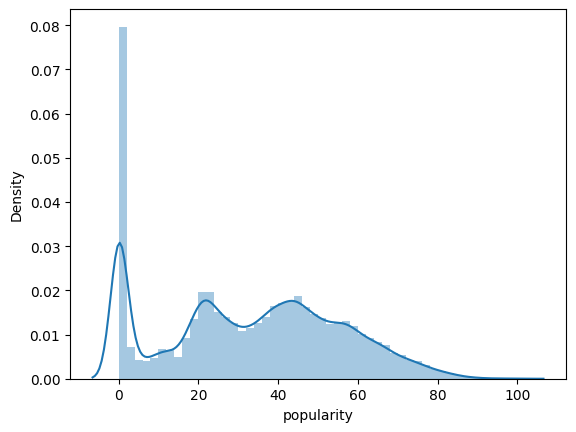

<Figure size 640x480 with 0 Axes>

In [24]:
# Distribution for 'popularity'
sns.distplot(data['popularity']);
fig = plt.figure()

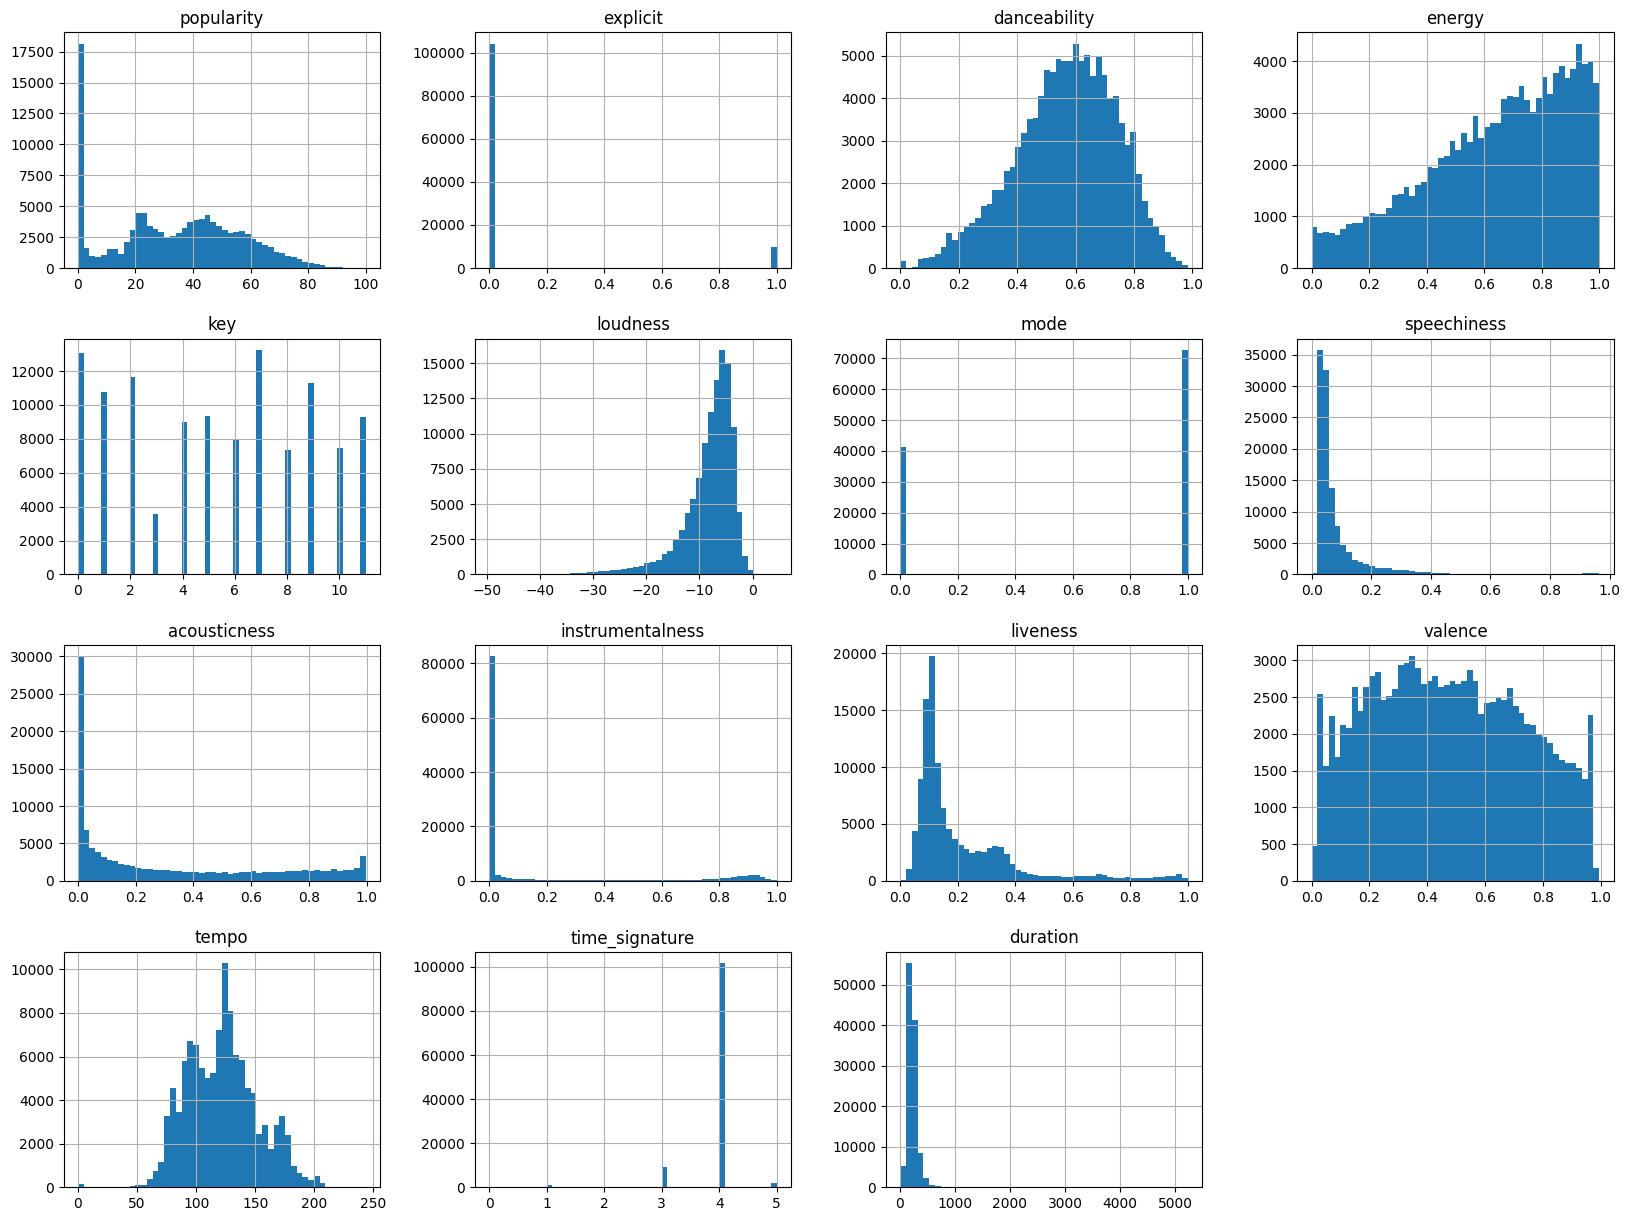

In [25]:
data.hist(bins=50, figsize=(20,15))
plt.savefig(save_path_img + "numerical_distribution.png", dpi = 200, format = 'png', bbox_inches='tight')
plt.show()

## Correlation analysis

,popularity,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,duration
energy,NaN,NaN,NaN,NaN,NaN,0.76169,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loudness,NaN,NaN,NaN,0.76169,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


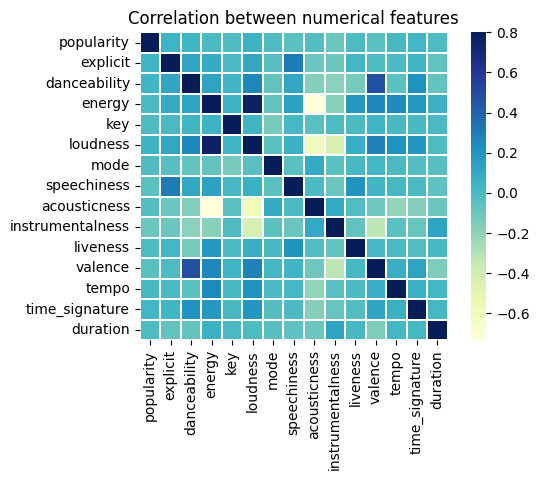

In [26]:
correlation_analysis(data, numerical_cols)

## Outlier analysis

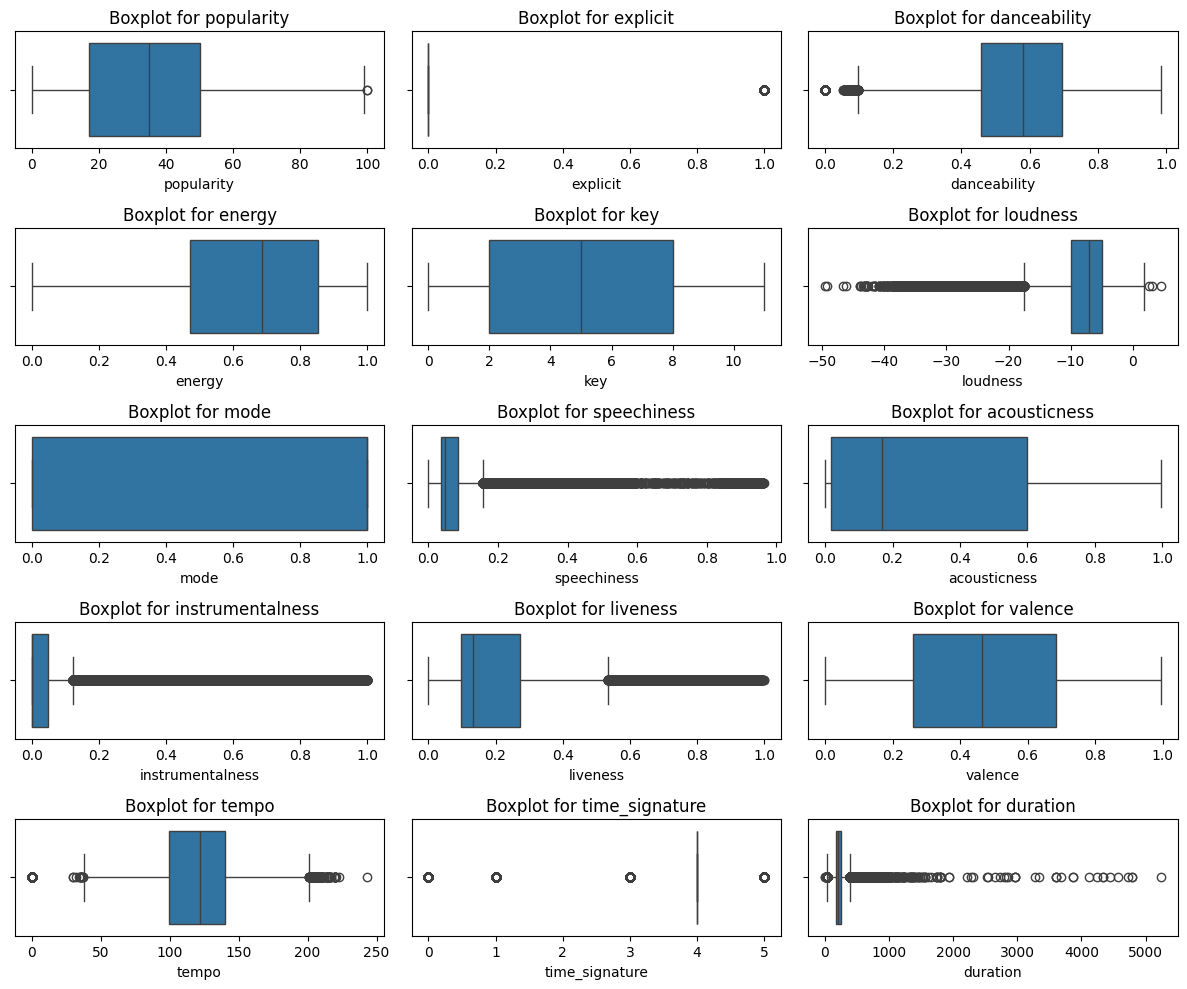

                Name  Upper_Bound  Lower_Bound
0         popularity     99.50000    -32.50000
1           explicit      0.00000      0.00000
2       danceability      1.05350      0.09750
3             energy      1.42700     -0.10100
4                key     17.00000     -7.00000
5           loudness      2.51200    -17.52800
6               mode      2.50000     -1.50000
7        speechiness      0.15740     -0.03700
8       acousticness      1.46840     -0.85400
9   instrumentalness      0.12250     -0.07350
10          liveness      0.53550     -0.16450
11           valence      1.31750     -0.37450
12             tempo    201.34975     37.93975
13    time_signature      4.00000      4.00000
14          duration    392.66600     42.90600


In [27]:
outliers_analysis(data, numerical_cols, save_path_img)

## Data Processing and Normalization

In [28]:
total_data = processing_data(data)

In [29]:
total_data.shape

(89740, 145)

## Splitting data between Numerical and Categotical Features

In [30]:
numb_data = num_cat_split(total_data, data)

The size of the dataset used for the total features is :  (89740, 145)
The size of the dataset used for the numerical features is :  (89740, 11)


In [31]:
numb_data.head(10)

,popularity,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration
0,0.50,0.374619,0.598,0.786989,0.031503,0.005131,0.000000,0.1760,0.046834,0.608180,0.082556
1,0.11,0.173604,0.997,0.849842,0.122280,0.005231,0.801000,0.4200,0.029548,0.502206,0.016323
2,0.00,0.175635,0.803,0.729889,0.149223,0.615462,0.001910,0.1950,0.089146,0.310488,0.039205
3,0.00,0.693401,0.511,0.812626,0.028912,0.407631,0.000197,0.1110,0.601005,0.451946,0.027311
4,0.57,0.563452,0.941,0.855243,0.049845,0.485944,0.000000,0.2660,0.817085,0.380023,0.043549
5,0.38,0.787817,0.800,0.829162,0.045389,0.006335,0.073100,0.3500,0.585930,0.591642,0.057549
6,0.21,0.636548,0.815,0.787452,0.944041,0.788153,0.000000,0.7440,0.534673,0.489773,0.093257
7,0.54,0.401015,0.933,0.849583,0.120207,0.000009,0.012500,0.3280,0.194975,0.380200,0.034582
8,0.29,0.927919,0.766,0.811442,0.040104,0.192771,0.650000,0.0747,0.904523,0.520323,0.038373
9,0.48,0.350254,0.976,0.828496,0.050466,0.000589,0.050700,0.4870,0.822111,0.744215,0.027364


In [32]:
total_data.head(10)

,popularity,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,...,track_genre_spanish,track_genre_study,track_genre_swedish,track_genre_synth-pop,track_genre_tango,track_genre_techno,track_genre_trance,track_genre_trip-hop,track_genre_turkish,track_genre_world-music
0,0.50,0.374619,0.598,0.786989,0.031503,0.005131,0.000000,0.1760,0.046834,0.608180,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5
1,0.11,0.173604,0.997,0.849842,0.122280,0.005231,0.801000,0.4200,0.029548,0.502206,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.00,0.175635,0.803,0.729889,0.149223,0.615462,0.001910,0.1950,0.089146,0.310488,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.00,0.693401,0.511,0.812626,0.028912,0.407631,0.000197,0.1110,0.601005,0.451946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.57,0.563452,0.941,0.855243,0.049845,0.485944,0.000000,0.2660,0.817085,0.380023,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.38,0.787817,0.800,0.829162,0.045389,0.006335,0.073100,0.3500,0.585930,0.591642,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.21,0.636548,0.815,0.787452,0.944041,0.788153,0.000000,0.7440,0.534673,0.489773,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.54,0.401015,0.933,0.849583,0.120207,0.000009,0.012500,0.3280,0.194975,0.380200,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.29,0.927919,0.766,0.811442,0.040104,0.192771,0.650000,0.0747,0.904523,0.520323,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.48,0.350254,0.976,0.828496,0.050466,0.000589,0.050700,0.4870,0.822111,0.744215,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Train Test Splitting and definition of $\alpha$

In [33]:
# Call the function to split the data
X_tr_n, X_va_n, X_te_n, y_tr_n, y_va_n, y_te_n, X_tr_c, X_va_c, X_te_c, y_tr_c, y_va_c, y_te_c = split_data(numb_data, total_data)

print(X_tr_n.shape, X_va_n.shape, X_te_n.shape, y_tr_n.shape, y_va_n.shape, y_te_n.shape)
print(X_tr_c.shape, X_va_c.shape, X_te_c.shape, y_tr_c.shape, y_va_c.shape, y_te_c.shape)

(62817, 10) (13461, 10) (13462, 10) (62817,) (13461,) (13462,)
(62817, 144) (13461, 144) (13462, 144) (62817,) (13461,) (13462,)


In [34]:
# Define the range of values for the penalization term
alphas = 10**np.linspace(start=7, stop=-3, num=100)

# Ridge Regression on Numerical Features

In [35]:
# Compute scratch ridge regression on numerical features
num_train_loss_mse, num_val_loss_mse, num_test_loss_mse,\
num_train_loss_rmse, num_val_loss_rmse, num_test_loss_rmse,\
num_train_loss_mae, num_val_loss_mae, num_test_loss_mae = scratch_ridge_regression(alphas, X_tr_n, y_tr_n, X_va_n, y_va_n, X_te_n, y_te_n)

In [36]:
# Compute scikit ridge regression on numerical features
sk_num_train_loss_mse, sk_num_val_loss_mse, sk_num_test_loss_mse,\
sk_num_train_loss_rmse, sk_num_val_loss_rmse, sk_num_test_loss_rmse,\
sk_num_train_loss_mae, sk_num_val_loss_mae, sk_num_test_loss_mae = scikit_ridge_regression(alphas, X_tr_n, y_tr_n, X_va_n, y_va_n, X_te_n, y_te_n)

## Ridge Regression on Numerical Features: Metrics representation

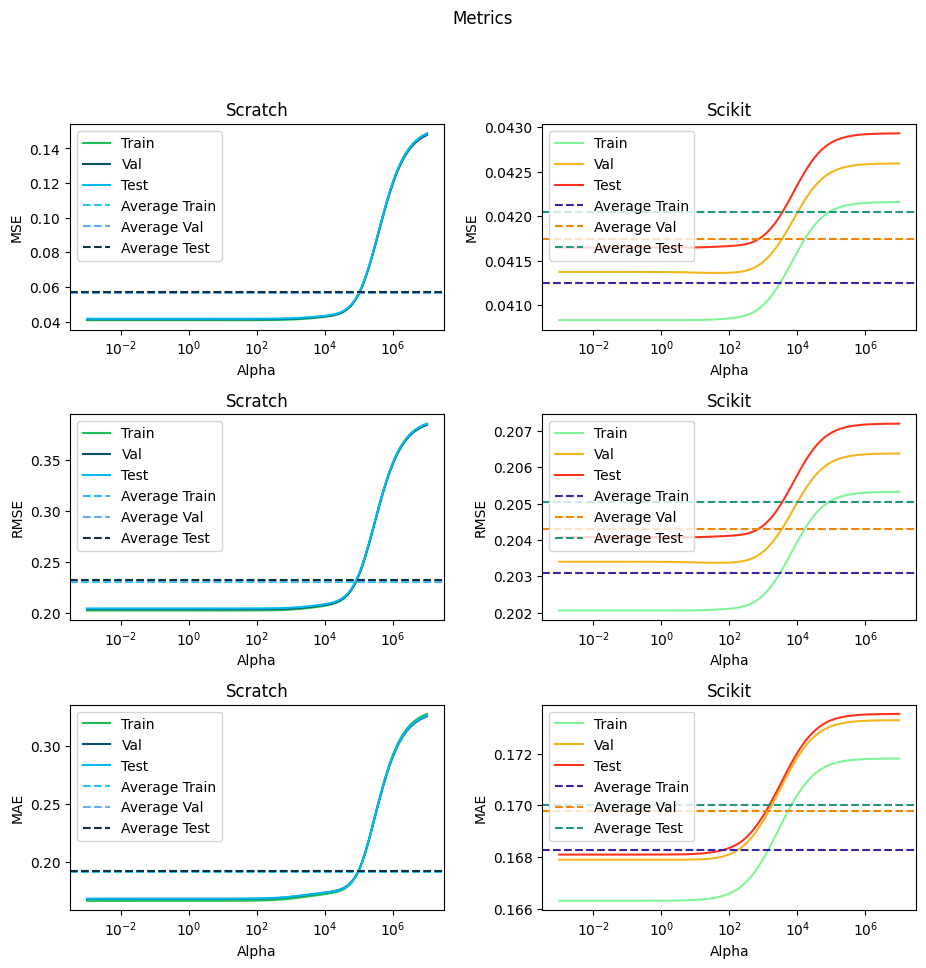

In [37]:
plot_metrics_ridge_regression(alphas, colors_scratch, colors_scikit, \
                              num_train_loss_mse, num_val_loss_mse, num_test_loss_mse, \
                              sk_num_train_loss_mse, sk_num_val_loss_mse, sk_num_test_loss_mse, \
                              num_train_loss_rmse, num_val_loss_rmse, num_test_loss_rmse, \
                              sk_num_train_loss_rmse, sk_num_val_loss_rmse, sk_num_test_loss_rmse, \
                              num_train_loss_mae, num_val_loss_mae, num_test_loss_mae, \
                              sk_num_train_loss_mae, sk_num_val_loss_mae, sk_num_test_loss_mae, save_path_img, 'ridge_regression_numerical_features_total_metrics.png')

## Ridge Regression on Numerical Features: Table of the metrics

In [38]:
table_ridge_regression_numerical = PrettyTable()
table_ridge_regression_numerical.title = 'Metrics from Scratch\Scikit model on the Numerical Features'
table_ridge_regression_numerical.field_names = ["Model","Dataset", "Metrics", "Average", "min", "Alpha"]
table_ridge_regression_numerical.align["Model"] = "l"
table_ridge_regression_numerical.align["Dataset"] = "l"
table_ridge_regression_numerical.align["Metrics"] = "r"
table_ridge_regression_numerical.align["Average"] = "r"
table_ridge_regression_numerical.align["min"] = "r"
table_ridge_regression_numerical.align["Alpha"] = "r"

table_ridge_regression_numerical.add_row(["Scratch", "Train", "MSE", round(np.mean(num_train_loss_mse),6), round(np.min(num_train_loss_mse),6), round(alphas[np.argmin(num_train_loss_mse)],3)])
table_ridge_regression_numerical.add_row(["ScikitL", "Train", "MSE", round(np.mean(sk_num_train_loss_mse),6), round(np.min(sk_num_train_loss_mse),6), round(alphas[np.argmin(sk_num_train_loss_mse)],3)], divider=True)
table_ridge_regression_numerical.add_row(["Scratch", "Val", "MSE", round(np.mean(num_val_loss_mse),6), round(np.min(num_val_loss_mse),6), round(alphas[np.argmin(num_val_loss_mse)],3)])
table_ridge_regression_numerical.add_row(["ScikitL", "Val", "MSE", round(np.mean(sk_num_val_loss_mse),6), round(np.min(sk_num_val_loss_mse),6), round(alphas[np.argmin(sk_num_val_loss_mse)],3)], divider=True)
table_ridge_regression_numerical.add_row(["Scratch", "Test", "MSE", round(np.mean(num_test_loss_mse), 6), round(np.min(num_test_loss_mse), 6), round(alphas[np.argmin(num_test_loss_mse)],3)])
table_ridge_regression_numerical.add_row(["ScikitL", "Test", "MSE", round(np.mean(sk_num_test_loss_mse), 6), round(np.min(sk_num_test_loss_mse), 6), round(alphas[np.argmin(sk_num_test_loss_mse)],3)], divider=True)

table_ridge_regression_numerical.add_row(["Scratch", "Train", "RMSE", round(np.mean(num_train_loss_rmse),6), round(np.min(num_train_loss_rmse),6), round(alphas[np.argmin(num_train_loss_rmse)],3)])
table_ridge_regression_numerical.add_row(["ScikitL", "Train", "RMSE", round(np.mean(sk_num_train_loss_rmse),6), round(np.min(sk_num_train_loss_rmse),6), round(alphas[np.argmin(sk_num_train_loss_rmse)],3)], divider=True)
table_ridge_regression_numerical.add_row(["Scratch", "Val", "RMSE", round(np.mean(num_val_loss_rmse),6), round(np.min(num_val_loss_rmse),6), round(alphas[np.argmin(num_val_loss_rmse)],3)])
table_ridge_regression_numerical.add_row(["ScikitL", "Val", "RMSE", round(np.mean(sk_num_val_loss_rmse),6), round(np.min(sk_num_val_loss_rmse),6), round(alphas[np.argmin(sk_num_val_loss_rmse)],3)], divider=True)
table_ridge_regression_numerical.add_row(["Scratch", "Test", "RMSE", round(np.mean(num_test_loss_rmse), 6), round(np.min(num_test_loss_rmse), 6), round(alphas[np.argmin(num_test_loss_rmse)],3)])
table_ridge_regression_numerical.add_row(["ScikitL", "Test", "RMSE", round(np.mean(sk_num_test_loss_rmse), 6), round(np.min(sk_num_test_loss_rmse), 6), round(alphas[np.argmin(sk_num_test_loss_rmse)],3)], divider=True)

table_ridge_regression_numerical.add_row(["Scratch", "Train", "MAE", round(np.mean(num_train_loss_mae),6), round(np.min(num_train_loss_mae),6), round(alphas[np.argmin(num_train_loss_mae)],3)])
table_ridge_regression_numerical.add_row(["ScikitL", "Train", "MAE", round(np.mean(sk_num_train_loss_mae),6), round(np.min(sk_num_train_loss_mae),6), round(alphas[np.argmin(sk_num_train_loss_mae)],3)],divider=True)
table_ridge_regression_numerical.add_row(["Scratch", "Val", "MAE", round(np.mean(num_val_loss_mae),6), round(np.min(num_val_loss_mae),6), round(alphas[np.argmin(num_val_loss_mae)],3)])
table_ridge_regression_numerical.add_row(["ScikitL", "Val", "MAE", round(np.mean(sk_num_val_loss_mae),6), round(np.min(sk_num_val_loss_mae),6), round(alphas[np.argmin(sk_num_val_loss_mae)],3)],divider=True)
table_ridge_regression_numerical.add_row(["Scratch", "Test", "MAE", round(np.mean(num_test_loss_mae), 6), round(np.min(num_test_loss_mae), 6), round(alphas[np.argmin(num_test_loss_mae)],3)])
table_ridge_regression_numerical.add_row(["ScikitL", "Test", "MAE", round(np.mean(sk_num_test_loss_mae), 6), round(np.min(sk_num_test_loss_mae), 6), round(alphas[np.argmin(sk_num_test_loss_mae)],3)])

table_ridge_regression_numerical

Model,Dataset,Metrics,Average,min,Alpha
Scratch,Train,MSE,0.056311,0.040829,0.001
ScikitL,Train,MSE,0.041248,0.040829,0.001
Scratch,Val,MSE,0.056558,0.041362,27.826
ScikitL,Val,MSE,0.041744,0.041361,44.306
Scratch,Test,MSE,0.056928,0.041646,2.154
ScikitL,Test,MSE,0.042043,0.041646,1.353
Scratch,Train,RMSE,0.230462,0.202061,0.001
ScikitL,Train,RMSE,0.203092,0.202061,0.001
Scratch,Val,RMSE,0.231201,0.203375,27.826
ScikitL,Val,RMSE,0.20431,0.203373,44.306


# Ridge Regression on All Features

In [39]:
# Compute scratch ridge regression on categorical features
cat_train_loss_mse, cat_val_loss_mse, cat_test_loss_mse,\
cat_train_loss_rmse, cat_val_loss_rmse, cat_test_loss_rmse,\
cat_train_loss_mae, cat_val_loss_mae, cat_test_loss_mae = scratch_ridge_regression(alphas, X_tr_c, y_tr_c, X_va_c, y_va_c, X_te_c, y_te_c)

In [40]:
# Compute scikit ridge regression on categorical features
sk_cat_train_loss_mse, sk_cat_val_loss_mse, sk_cat_test_loss_mse, \
sk_cat_train_loss_rmse, sk_cat_val_loss_rmse, sk_cat_test_loss_rmse, \
sk_cat_train_loss_mae, sk_cat_val_loss_mae, sk_cat_test_loss_mae = scikit_ridge_regression(alphas, X_tr_c, y_tr_c, X_va_c, y_va_c, X_te_c, y_te_c)

## Ridge Regression on All Features: Metrics representation

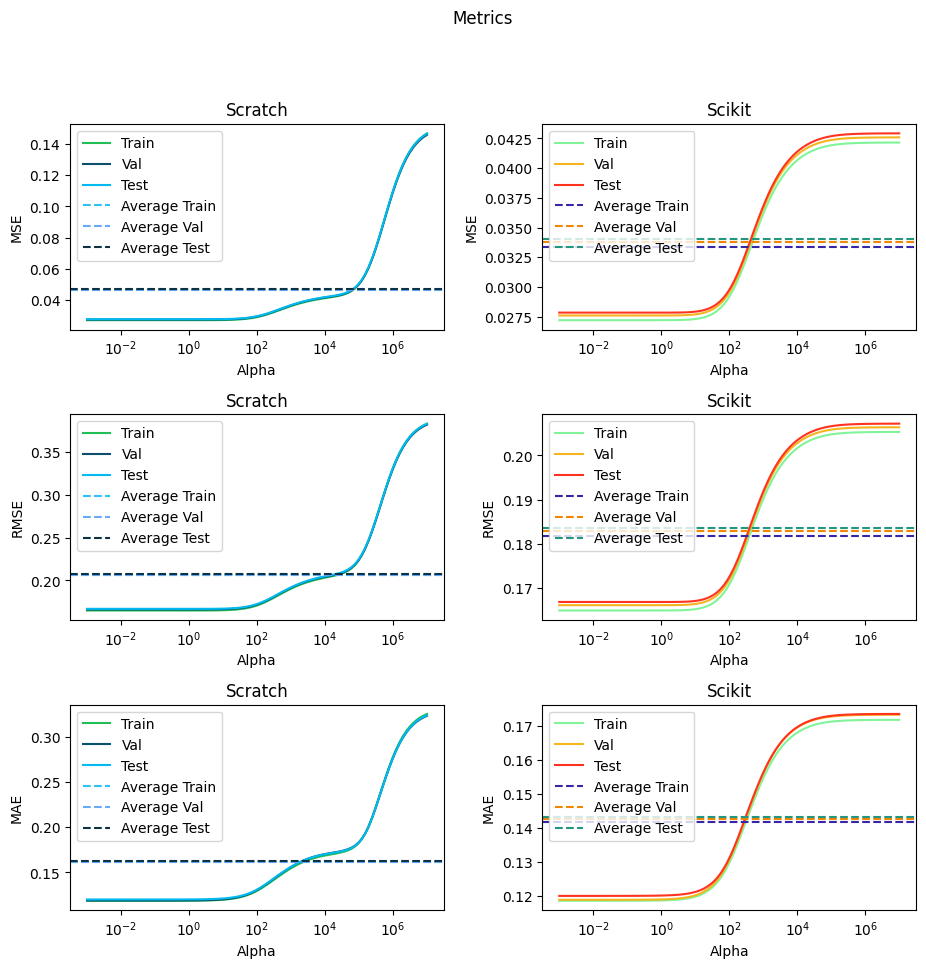

In [41]:
plot_metrics_ridge_regression(alphas, colors_scratch, colors_scikit, \
                              cat_train_loss_mse, cat_val_loss_mse, cat_test_loss_mse, \
                              sk_cat_train_loss_mse, sk_cat_val_loss_mse, sk_cat_test_loss_mse, \
                              cat_train_loss_rmse, cat_val_loss_rmse, cat_test_loss_rmse, \
                              sk_cat_train_loss_rmse, sk_cat_val_loss_rmse, sk_cat_test_loss_rmse, \
                              cat_train_loss_mae, cat_val_loss_mae, cat_test_loss_mae, \
                              sk_cat_train_loss_mae, sk_cat_val_loss_mae, sk_cat_test_loss_mae, save_path_img, 'ridge_regression_categorical_features_total_metrics.png')

## Ridge Regression on All Features: Table of the metrics

In [42]:
table_ridge_regression_categorical = PrettyTable()
table_ridge_regression_categorical.title = 'Metrics from Scratch\Scikit model on the Categorical Features'
table_ridge_regression_categorical.field_names = ["Model","Dataset", "Metrics", "Average", "min", "Alpha"]
table_ridge_regression_categorical.align["Model"] = "l"
table_ridge_regression_categorical.align["Dataset"] = "l"
table_ridge_regression_categorical.align["Metrics"] = "r"
table_ridge_regression_categorical.align["Average"] = "r"
table_ridge_regression_categorical.align["min"] = "r"
table_ridge_regression_categorical.align["Alpha"] = "r"

table_ridge_regression_categorical.add_row(["Scratch", "Train", "MSE", round(np.mean(cat_train_loss_mse),6), round(np.min(cat_train_loss_mse),6), round(alphas[np.argmin(cat_train_loss_mse)],3)])
table_ridge_regression_categorical.add_row(["ScikitL", "Train", "MSE", round(np.mean(sk_cat_train_loss_mse),6), round(np.min(sk_cat_train_loss_mse),6), round(alphas[np.argmin(sk_cat_train_loss_mse)],3)], divider=True)
table_ridge_regression_categorical.add_row(["Scratch", "Val", "MSE", round(np.mean(cat_val_loss_mse),6), round(np.min(cat_val_loss_mse),6), round(alphas[np.argmin(cat_val_loss_mse)],3)])
table_ridge_regression_categorical.add_row(["ScikitL", "Val", "MSE", round(np.mean(sk_cat_val_loss_mse),6), round(np.min(sk_cat_val_loss_mse),6), round(alphas[np.argmin(sk_cat_val_loss_mse)],3)], divider=True)
table_ridge_regression_categorical.add_row(["Scratch", "Test", "MSE", round(np.mean(cat_test_loss_mse), 6), round(np.min(cat_test_loss_mse), 6), round(alphas[np.argmin(cat_test_loss_mse)],3)])
table_ridge_regression_categorical.add_row(["ScikitL", "Test", "MSE", round(np.mean(sk_cat_test_loss_mse), 6), round(np.min(sk_cat_test_loss_mse), 6), round(alphas[np.argmin(sk_cat_test_loss_mse)],3)], divider=True)

table_ridge_regression_categorical.add_row(["Scratch", "Train", "RMSE", round(np.mean(cat_train_loss_rmse),6), round(np.min(cat_train_loss_rmse),6), round(alphas[np.argmin(cat_train_loss_rmse)],3)])
table_ridge_regression_categorical.add_row(["ScikitL", "Train", "RMSE", round(np.mean(sk_cat_train_loss_rmse),6), round(np.min(sk_cat_train_loss_rmse),6), round(alphas[np.argmin(sk_cat_train_loss_rmse)],3)], divider=True)
table_ridge_regression_categorical.add_row(["Scratch", "Val", "RMSE", round(np.mean(cat_val_loss_rmse),6), round(np.min(cat_val_loss_rmse),6), round(alphas[np.argmin(cat_val_loss_rmse)],3)])
table_ridge_regression_categorical.add_row(["ScikitL", "Val", "RMSE", round(np.mean(sk_cat_val_loss_rmse),6), round(np.min(sk_cat_val_loss_rmse),6), round(alphas[np.argmin(sk_cat_val_loss_rmse)],3)], divider=True)
table_ridge_regression_categorical.add_row(["Scratch", "Test", "RMSE", round(np.mean(cat_test_loss_rmse), 6), round(np.min(cat_test_loss_rmse), 6), round(alphas[np.argmin(cat_test_loss_rmse)],3)])
table_ridge_regression_categorical.add_row(["ScikitL", "Test", "RMSE", round(np.mean(sk_cat_test_loss_rmse), 6), round(np.min(sk_cat_test_loss_rmse), 6), round(alphas[np.argmin(sk_cat_test_loss_rmse)],3)], divider=True)

table_ridge_regression_categorical.add_row(["Scratch", "Train", "MAE", round(np.mean(cat_train_loss_mae),6), round(np.min(cat_train_loss_mae),6), round(alphas[np.argmin(cat_train_loss_mae)],3)])
table_ridge_regression_categorical.add_row(["ScikitL", "Train", "MAE", round(np.mean(sk_cat_train_loss_mae),6), round(np.min(sk_cat_train_loss_mae),6), round(alphas[np.argmin(sk_cat_train_loss_mae)],3)],divider=True)
table_ridge_regression_categorical.add_row(["Scratch", "Val", "MAE", round(np.mean(cat_val_loss_mae),6), round(np.min(cat_val_loss_mae),6), round(alphas[np.argmin(cat_val_loss_mae)],3)])
table_ridge_regression_categorical.add_row(["ScikitL", "Val", "MAE", round(np.mean(sk_cat_val_loss_mae),6), round(np.min(sk_cat_val_loss_mae),6), round(alphas[np.argmin(sk_cat_val_loss_mae)],3)],divider=True)
table_ridge_regression_categorical.add_row(["Scratch", "Test", "MAE", round(np.mean(cat_test_loss_mae), 6), round(np.min(cat_test_loss_mae), 6), round(alphas[np.argmin(cat_test_loss_mae)],3)])
table_ridge_regression_categorical.add_row(["ScikitL", "Test", "MAE", round(np.mean(sk_cat_test_loss_mae), 6), round(np.min(sk_cat_test_loss_mae), 6), round(alphas[np.argmin(sk_cat_test_loss_mae)],3)])

table_ridge_regression_categorical

Model,Dataset,Metrics,Average,min,Alpha
Scratch,Train,MSE,0.046554,0.027201,0.001
ScikitL,Train,MSE,0.033376,0.027201,0.001
Scratch,Val,MSE,0.046753,0.027598,0.021
ScikitL,Val,MSE,0.033789,0.027598,0.052
Scratch,Test,MSE,0.047067,0.02784,0.85
ScikitL,Test,MSE,0.034049,0.02784,0.85
Scratch,Train,RMSE,0.205954,0.164928,0.001
ScikitL,Train,RMSE,0.181808,0.164928,0.001
Scratch,Val,RMSE,0.206678,0.166128,0.021
ScikitL,Val,RMSE,0.182946,0.166128,0.052


# Linear Regression on Numerical Features

In [43]:
# Compute linear regression using scratch model
rr_num_train_mse, rr_num_val_mse, rr_num_test_mse, \
rr_num_train_rmse, rr_num_val_rmse, rr_num_test_rmse,\
rr_num_train_mae, rr_num_val_mae, rr_num_test_mae = scratch_ridge_regression([0],X_tr_n, y_tr_n, X_va_n, y_va_n, X_te_n, y_te_n)

# Compute linear regression using scikit model
sk_num_train_mse, sk_num_val_mse, sk_num_test_mse,\
sk_num_train_rmse, sk_num_val_rmse, sk_num_test_rmse,\
sk_num_train_mae, sk_num_val_mae, sk_num_test_mae = scikit_ridge_regression([0], X_tr_n, y_tr_n, X_va_n, y_va_n, X_te_n, y_te_n)

# Compute linear regression using linear regression model
lr_lin_num_train_mse, lr_lin_num_val_mse, lr_lin_num_test_mse,\
lr_lin_num_train_rmse, lr_lin_num_val_rmse, lr_lin_num_test_rmse,\
lr_lin_num_train_mae, lr_lin_num_val_mae, lr_lin_num_test_mae = linear_regression(X_tr_n, y_tr_n, X_va_n, y_va_n, X_te_n, y_te_n)

## Linear Regression on Numerical Features: Metrics Table

In [44]:
table_linear_regression_numerical = PrettyTable()
table_linear_regression_numerical.title = 'Metrics from Scratch Linear model on the Numerical Features'
table_linear_regression_numerical.field_names = ["Model","Dataset", "Metrics", "Result"]
table_linear_regression_numerical.align["Model"] = "l"
table_linear_regression_numerical.align["Dataset"] = "l"
table_linear_regression_numerical.align["Metrics"] = "r"
table_linear_regression_numerical.align["Result"] = "r"

table_linear_regression_numerical.add_row(["Scratch", "Train", "MSE", round(rr_num_train_mse[0],6)])
table_linear_regression_numerical.add_row(["Scratch", "Val", "MSE", round(rr_num_val_mse[0],6)])
table_linear_regression_numerical.add_row(["Scratch", "Test", "MSE", round(rr_num_test_mse[0], 6)], divider=True)

table_linear_regression_numerical.add_row(["Scratch", "Train", "RMSE", round(rr_num_train_rmse[0], 6)])
table_linear_regression_numerical.add_row(["Scratch", "Val", "RMSE", round(rr_num_val_rmse[0], 6)])
table_linear_regression_numerical.add_row(["Scratch", "Test", "RMSE", round(rr_num_test_rmse[0], 6)], divider=True)

table_linear_regression_numerical.add_row(["Scratch", "Train", "MAE", round(rr_num_train_mae[0], 6)])
table_linear_regression_numerical.add_row(["Scratch", "Val", "MAE", round(rr_num_val_mae[0], 6)])
table_linear_regression_numerical.add_row(["Scratch", "Test", "MAE", round(rr_num_train_mae[0], 6)], divider=True)

table_linear_regression_numerical.add_row(["Scikit", "Train", "MSE", round(sk_num_train_mse[0],6)])
table_linear_regression_numerical.add_row(["Scikit", "Val", "MSE", round(sk_num_val_mse[0],6)])
table_linear_regression_numerical.add_row(["Scikit", "Test", "MSE", round(sk_num_test_mse[0], 6)], divider=True)

table_linear_regression_numerical.add_row(["Scikit", "Train", "RMSE", round(sk_num_train_rmse[0], 6)])
table_linear_regression_numerical.add_row(["Scikit", "Val", "RMSE", round(sk_num_val_rmse[0], 6)])
table_linear_regression_numerical.add_row(["Scikit", "Test", "RMSE", round(sk_num_test_rmse[0], 6)], divider=True)

table_linear_regression_numerical.add_row(["Scikit", "Train", "MAE", round(sk_num_train_mae[0], 6)])
table_linear_regression_numerical.add_row(["Scikit", "Val", "MAE", round(sk_num_val_mae[0], 6)])
table_linear_regression_numerical.add_row(["Scikit", "Test", "MAE", round(sk_num_train_mae[0], 6)], divider=True)

table_linear_regression_numerical.add_row(["Linear", "Train", "MSE", round(lr_lin_num_train_mse[0],6)])
table_linear_regression_numerical.add_row(["Linear", "Val", "MSE", round(lr_lin_num_val_mse[0],6)])
table_linear_regression_numerical.add_row(["Linear", "Test", "MSE", round(lr_lin_num_test_mse[0], 6)], divider=True)

table_linear_regression_numerical.add_row(["Linear", "Train", "RMSE", round(lr_lin_num_train_rmse[0], 6)])
table_linear_regression_numerical.add_row(["Linear", "Val", "RMSE", round(lr_lin_num_val_rmse[0], 6)])
table_linear_regression_numerical.add_row(["Linear", "Test", "RMSE", round(lr_lin_num_test_rmse[0], 6)], divider=True)

table_linear_regression_numerical.add_row(["Linear", "Train", "MAE", round(lr_lin_num_train_mae[0], 6)])
table_linear_regression_numerical.add_row(["Linear", "Val", "MAE", round(lr_lin_num_val_mae[0], 6)])
table_linear_regression_numerical.add_row(["Linear", "Test", "MAE", round(lr_lin_num_train_mae[0], 6)], divider=True)

table_linear_regression_numerical

Model,Dataset,Metrics,Result
Scratch,Train,MSE,0.040829
Scratch,Val,MSE,0.041372
Scratch,Test,MSE,0.041646
Scratch,Train,RMSE,0.202061
Scratch,Val,RMSE,0.2034
Scratch,Test,RMSE,0.204073
Scratch,Train,MAE,0.1663
Scratch,Val,MAE,0.167893
Scratch,Test,MAE,0.1663
Scikit,Train,MSE,0.040829


## Linear Regression on Numerical Features: Metrics Representation

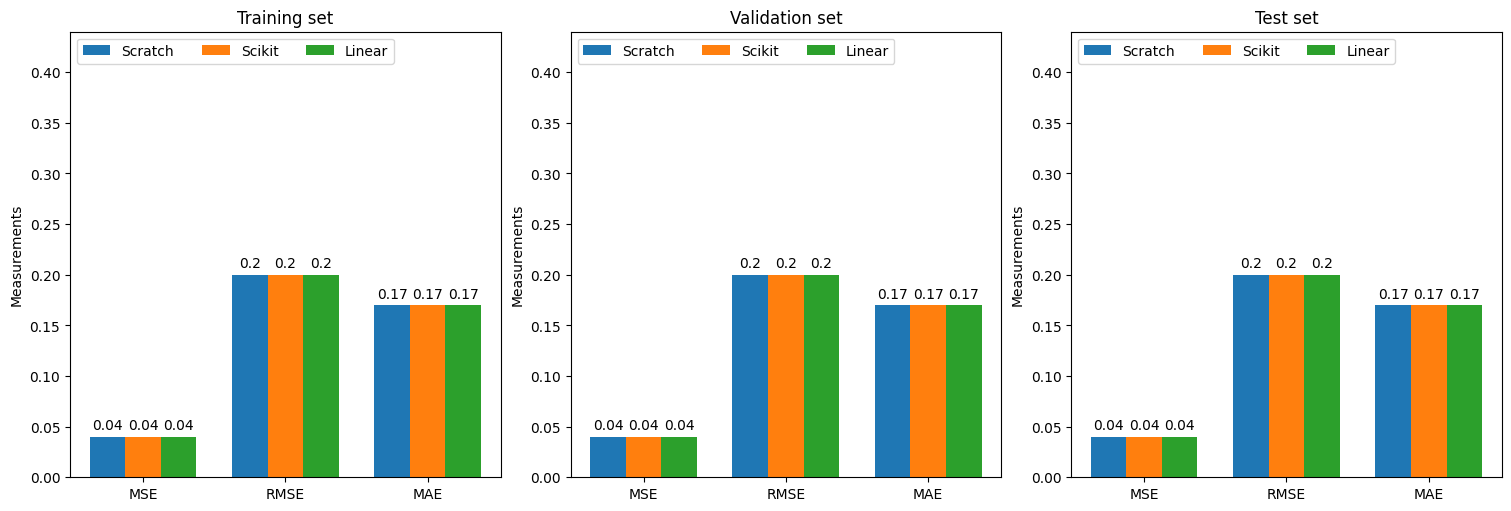

In [45]:
mse_numerical_metrics = {
    'Scratch': (round(rr_num_train_mse[0], 2), round(rr_num_train_rmse[0], 2), round(rr_num_train_mae[0], 2)),
    'Scikit': (round(sk_num_train_mse[0], 2), round(sk_num_train_rmse[0], 2), round(sk_num_train_mae[0], 2)),
    'Linear': (round(lr_lin_num_train_mse[0], 2), round(lr_lin_num_train_rmse[0], 2), round(lr_lin_num_train_mae[0], 2))
}

rmse_numerical_metrics = {
    'Scratch': (round(rr_num_val_mse[0], 2), round(rr_num_val_rmse[0], 2), round(rr_num_val_mae[0], 2)),
    'Scikit': (round(sk_num_val_mse[0], 2), round(sk_num_val_rmse[0], 2), round(sk_num_val_mae[0], 2)),
    'Linear': (round(lr_lin_num_val_mse[0], 2), round(lr_lin_num_val_rmse[0], 2), round(lr_lin_num_val_mae[0], 2))
}

mae_numerical_metrics = {
    'Scratch': (round(rr_num_test_mse[0], 2), round(rr_num_test_rmse[0], 2), round(rr_num_test_mae[0], 2)),
    'Scikit': (round(sk_num_test_mse[0], 2), round(sk_num_test_rmse[0], 2), round(sk_num_test_mae[0], 2)),
    'Linear': (round(lr_lin_num_test_mse[0], 2), round(lr_lin_num_test_rmse[0], 2), round(lr_lin_num_test_mae[0], 2))
}

fig, axs = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)

plot_metrics_linear_regression(axs[0], 'Training set', mse_numerical_metrics, 'Measurements')
plot_metrics_linear_regression(axs[1], 'Validation set', rmse_numerical_metrics, 'Measurements')
plot_metrics_linear_regression(axs[2], 'Test set', mae_numerical_metrics, 'Measurements')
plt.savefig(save_path_img + 'linear_regression_numerical_features.png', dpi=200, format='png', bbox_inches='tight')
plt.show()

# Linear Regression on Categorical Features

In [46]:
# Compute linear regression using scratch model
rr_cat_train_mse, rr_cat_val_mse, rr_cat_test_mse, \
rr_cat_train_rmse, rr_cat_val_rmse, rr_cat_test_rmse,\
rr_cat_train_mae, rr_cat_val_mae, rr_cat_test_mae = scratch_ridge_regression([0],X_tr_c, y_tr_c, X_va_c, y_va_c, X_te_c, y_te_c)

# Compute linear regression using scikit model
sk_cat_train_mse, sk_cat_val_mse, sk_cat_test_mse,\
sk_cat_train_rmse, sk_cat_val_rmse, sk_cat_test_rmse,\
sk_cat_train_mae, sk_cat_val_mae, sk_cat_test_mae = scikit_ridge_regression([0], X_tr_c, y_tr_c, X_va_c, y_va_c, X_te_c, y_te_c)

# Compute linear regression using linear regression model
lr_lin_cat_train_mse, lr_lin_cat_val_mse, lr_lin_cat_test_mse,\
lr_lin_cat_train_rmse, lr_lin_cat_val_rmse, lr_lin_cat_test_rmse,\
lr_lin_cat_train_mae, lr_lin_cat_val_mae, lr_lin_cat_test_mae = linear_regression(X_tr_c, y_tr_c, X_va_c, y_va_c, X_te_c, y_te_c)

## Linear Regression on Categorical Features: Metrics Table

In [47]:
table_linear_regression_categorical = PrettyTable()
table_linear_regression_categorical.title = 'Metrics from Scratch Linear model on the Numerical Features'
table_linear_regression_categorical.field_names = ["Model","Dataset", "Metrics", "Result"]
table_linear_regression_categorical.align["Model"] = "l"
table_linear_regression_categorical.align["Dataset"] = "l"
table_linear_regression_categorical.align["Metrics"] = "r"
table_linear_regression_categorical.align["Result"] = "r"

table_linear_regression_categorical.add_row(["Scratch", "Train", "MSE", round(rr_cat_train_mse[0],6)])
table_linear_regression_categorical.add_row(["Scratch", "Val", "MSE", round(rr_cat_val_mse[0],6)])
table_linear_regression_categorical.add_row(["Scratch", "Test", "MSE", round(rr_cat_test_mse[0], 6)], divider=True)

table_linear_regression_categorical.add_row(["Scratch", "Train", "RMSE", round(rr_cat_train_rmse[0], 6)])
table_linear_regression_categorical.add_row(["Scratch", "Val", "RMSE", round(rr_cat_val_rmse[0], 6)])
table_linear_regression_categorical.add_row(["Scratch", "Test", "RMSE", round(rr_cat_test_rmse[0], 6)], divider=True)

table_linear_regression_categorical.add_row(["Scratch", "Train", "MAE", round(rr_cat_train_mae[0], 6)])
table_linear_regression_categorical.add_row(["Scratch", "Val", "MAE", round(rr_cat_val_mae[0], 6)])
table_linear_regression_categorical.add_row(["Scratch", "Test", "MAE", round(rr_cat_train_mae[0], 6)], divider=True)

table_linear_regression_categorical.add_row(["Scikit", "Train", "MSE", round(sk_cat_train_mse[0],6)])
table_linear_regression_categorical.add_row(["Scikit", "Val", "MSE", round(sk_cat_val_mse[0],6)])
table_linear_regression_categorical.add_row(["Scikit", "Test", "MSE", round(sk_cat_test_mse[0], 6)], divider=True)

table_linear_regression_categorical.add_row(["Scikit", "Train", "RMSE", round(sk_cat_train_rmse[0], 6)])
table_linear_regression_categorical.add_row(["Scikit", "Val", "RMSE", round(sk_cat_val_rmse[0], 6)])
table_linear_regression_categorical.add_row(["Scikit", "Test", "RMSE", round(sk_cat_test_rmse[0], 6)], divider=True)

table_linear_regression_categorical.add_row(["Scikit", "Train", "MAE", round(sk_cat_train_mae[0], 6)])
table_linear_regression_categorical.add_row(["Scikit", "Val", "MAE", round(sk_cat_val_mae[0], 6)])
table_linear_regression_categorical.add_row(["Scikit", "Test", "MAE", round(sk_cat_train_mae[0], 6)], divider=True)

table_linear_regression_categorical.add_row(["Linear", "Train", "MSE", round(lr_lin_cat_train_mse[0],6)])
table_linear_regression_categorical.add_row(["Linear", "Val", "MSE", round(lr_lin_cat_val_mse[0],6)])
table_linear_regression_categorical.add_row(["Linear", "Test", "MSE", round(lr_lin_cat_test_mse[0], 6)], divider=True)

table_linear_regression_categorical.add_row(["Linear", "Train", "RMSE", round(lr_lin_cat_train_rmse[0], 6)])
table_linear_regression_categorical.add_row(["Linear", "Val", "RMSE", round(lr_lin_cat_val_rmse[0], 6)])
table_linear_regression_categorical.add_row(["Linear", "Test", "RMSE", round(lr_lin_cat_test_rmse[0], 6)], divider=True)

table_linear_regression_categorical.add_row(["Linear", "Train", "MAE", round(lr_lin_cat_train_mae[0], 6)])
table_linear_regression_categorical.add_row(["Linear", "Val", "MAE", round(lr_lin_cat_val_mae[0], 6)])
table_linear_regression_categorical.add_row(["Linear", "Test", "MAE", round(lr_lin_cat_train_mae[0], 6)], divider=True)

table_linear_regression_categorical

Model,Dataset,Metrics,Result
Scratch,Train,MSE,0.027201
Scratch,Val,MSE,0.027598
Scratch,Test,MSE,0.027841
Scratch,Train,RMSE,0.164928
Scratch,Val,RMSE,0.166128
Scratch,Test,RMSE,0.166856
Scratch,Train,MAE,0.118657
Scratch,Val,MAE,0.118945
Scratch,Test,MAE,0.118657
Scikit,Train,MSE,0.027202


## Linear Regression on Categorical Features: Metrics Representation

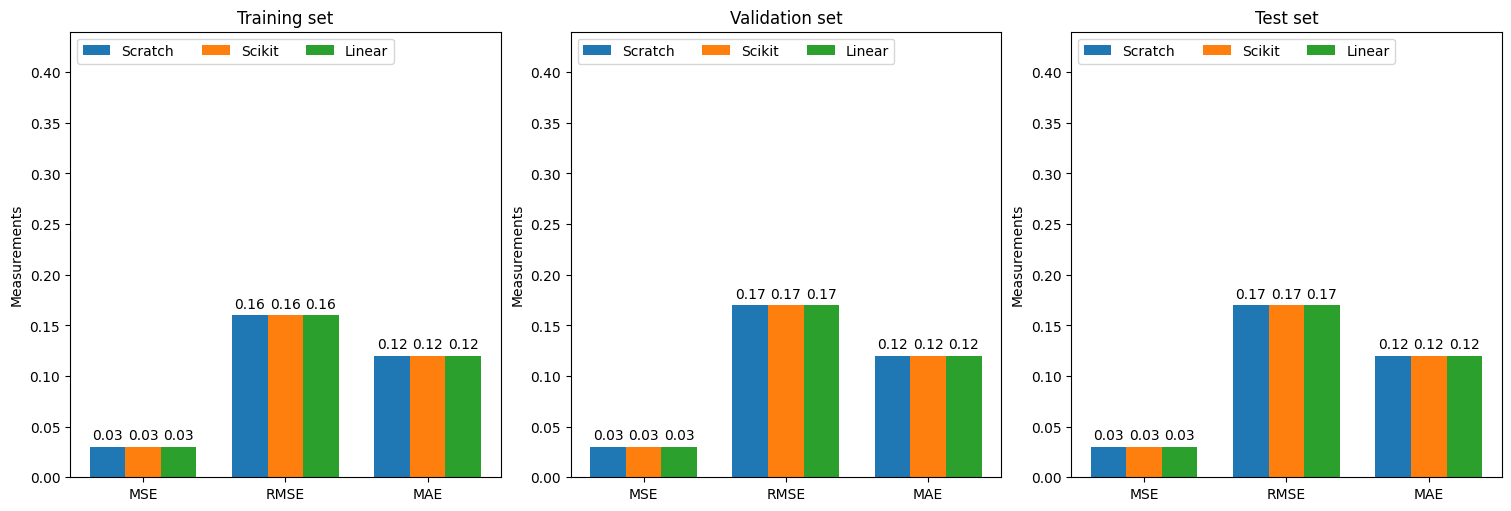

In [48]:
mse_categorical_metrics = {
    'Scratch': (round(rr_cat_train_mse[0], 2), round(rr_cat_train_rmse[0], 2), round(rr_cat_train_mae[0], 2)),
    'Scikit': (round(sk_cat_train_mse[0], 2), round(sk_cat_train_rmse[0], 2), round(sk_cat_train_mae[0], 2)),
    'Linear': (round(lr_lin_cat_train_mse[0], 2), round(lr_lin_cat_train_rmse[0], 2), round(lr_lin_cat_train_mae[0], 2))
}

rmse_categorical_metrics = {
    'Scratch': (round(rr_cat_val_mse[0], 2), round(rr_cat_val_rmse[0], 2), round(rr_cat_val_mae[0], 2)),
    'Scikit': (round(sk_cat_val_mse[0], 2), round(sk_cat_val_rmse[0], 2), round(sk_cat_val_mae[0], 2)),
    'Linear': (round(lr_lin_cat_val_mse[0], 2), round(lr_lin_cat_val_rmse[0], 2), round(lr_lin_cat_val_mae[0], 2))
}

mae_categorical_metrics = {
    'Scratch': (round(rr_cat_test_mse[0], 2), round(rr_cat_test_rmse[0], 2), round(rr_cat_test_mae[0], 2)),
    'Scikit': (round(sk_cat_test_mse[0], 2), round(sk_cat_test_rmse[0], 2), round(sk_cat_test_mae[0], 2)),
    'Linear': (round(lr_lin_cat_test_mse[0], 2), round(lr_lin_cat_test_rmse[0], 2), round(lr_lin_cat_test_mae[0], 2))
}

fig, axs = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)

plot_metrics_linear_regression(axs[0], 'Training set', mse_categorical_metrics, 'Measurements')
plot_metrics_linear_regression(axs[1], 'Validation set', rmse_categorical_metrics, 'Measurements')
plot_metrics_linear_regression(axs[2], 'Test set', mae_categorical_metrics, 'Measurements')
plt.savefig(save_path_img + 'linear_regression_categorical_features.png', dpi=200, format='png', bbox_inches='tight')
plt.show()

# k-Fold Cross Validation using Scratch Model

In [49]:
# Compute k-Fold CV from Scratch on Numerical Features
num_results_train_mse, num_results_train_rmse, num_results_train_mae, \
num_results_test_mse, num_results_test_rmse, num_results_test_mae, num_best_alpha = k_fold_cv_ridge_regression(numb_data, alphas, 5)

In [50]:
# Compute k-Fold CV from Scratch on Categorical Features
cat_results_train_mse, cat_results_train_rmse, cat_results_train_mae, \
cat_results_test_mse, cat_results_test_rmse, cat_results_test_mae, cat_best_alpha = k_fold_cv_ridge_regression(total_data, alphas, 5)

In [51]:
print("The best value of alpha while using the numerical dataset is", round(num_best_alpha,4))
print("The best value of alpha while using the categorical dataset is", round(cat_best_alpha,4))

The best value of alpha while using the numerical dataset is 0.001
The best value of alpha while using the categorical dataset is 0.001


## k-Fold Cross Validation using Scratch Model: Numerical Features Representation

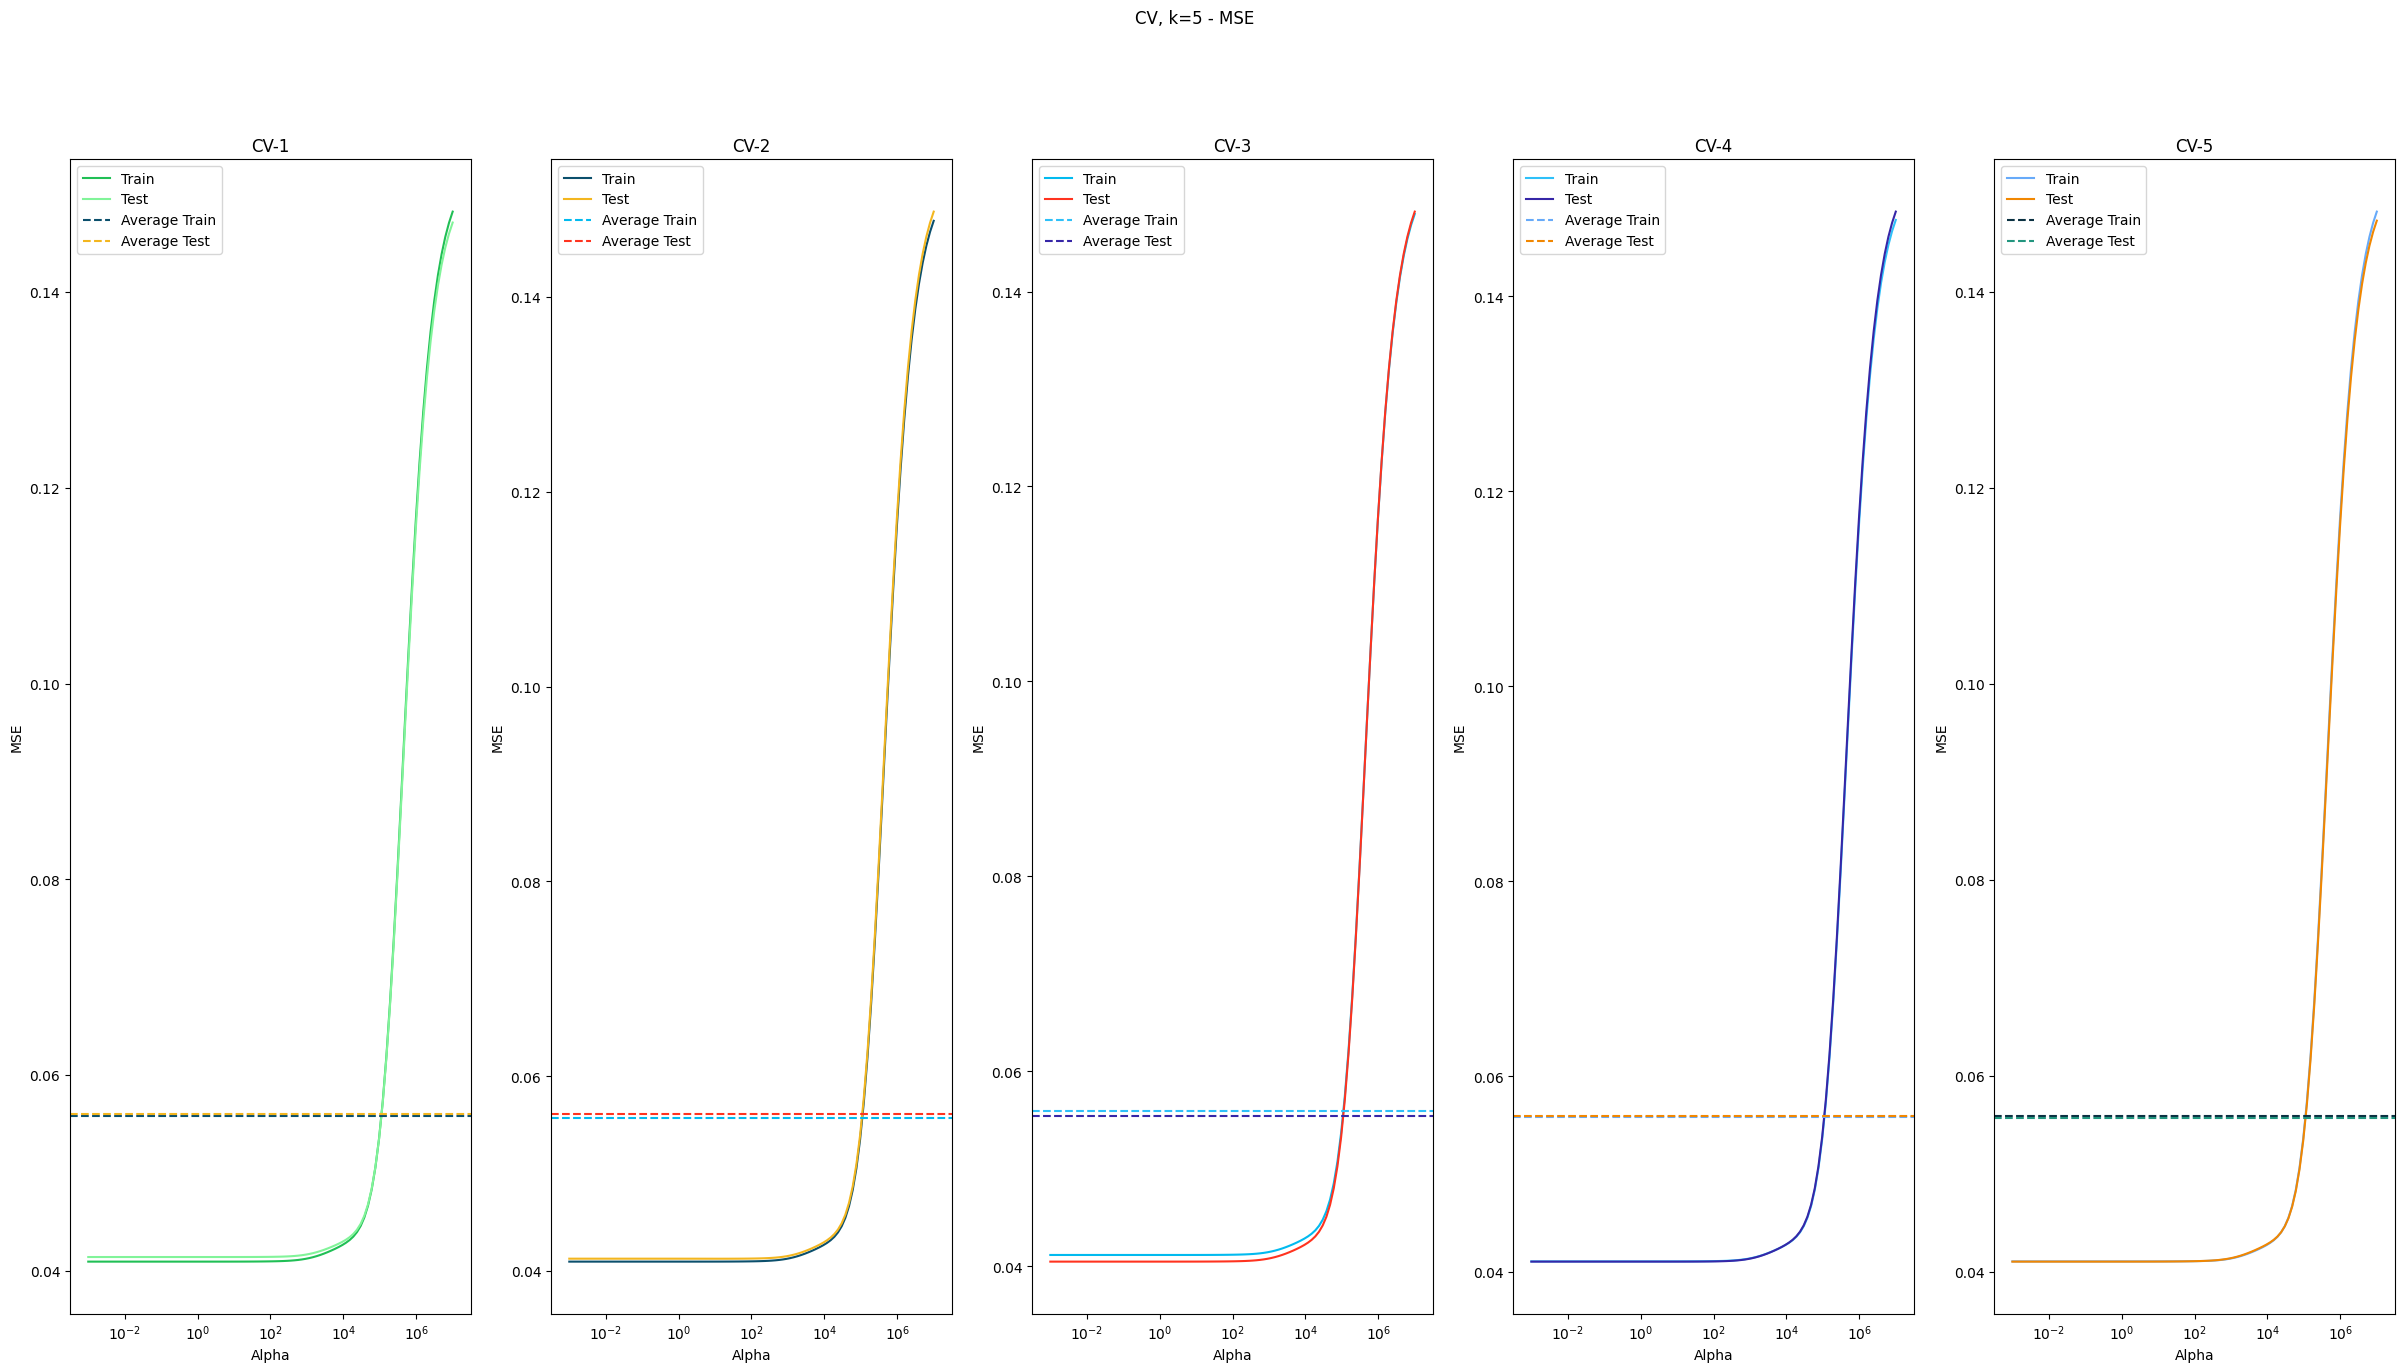

In [52]:
plot_cv_features(alphas, num_results_train_mse, num_results_test_mse, save_path_img, 'ridge_regression_numerical_features_CV_mse.png', 'mse')

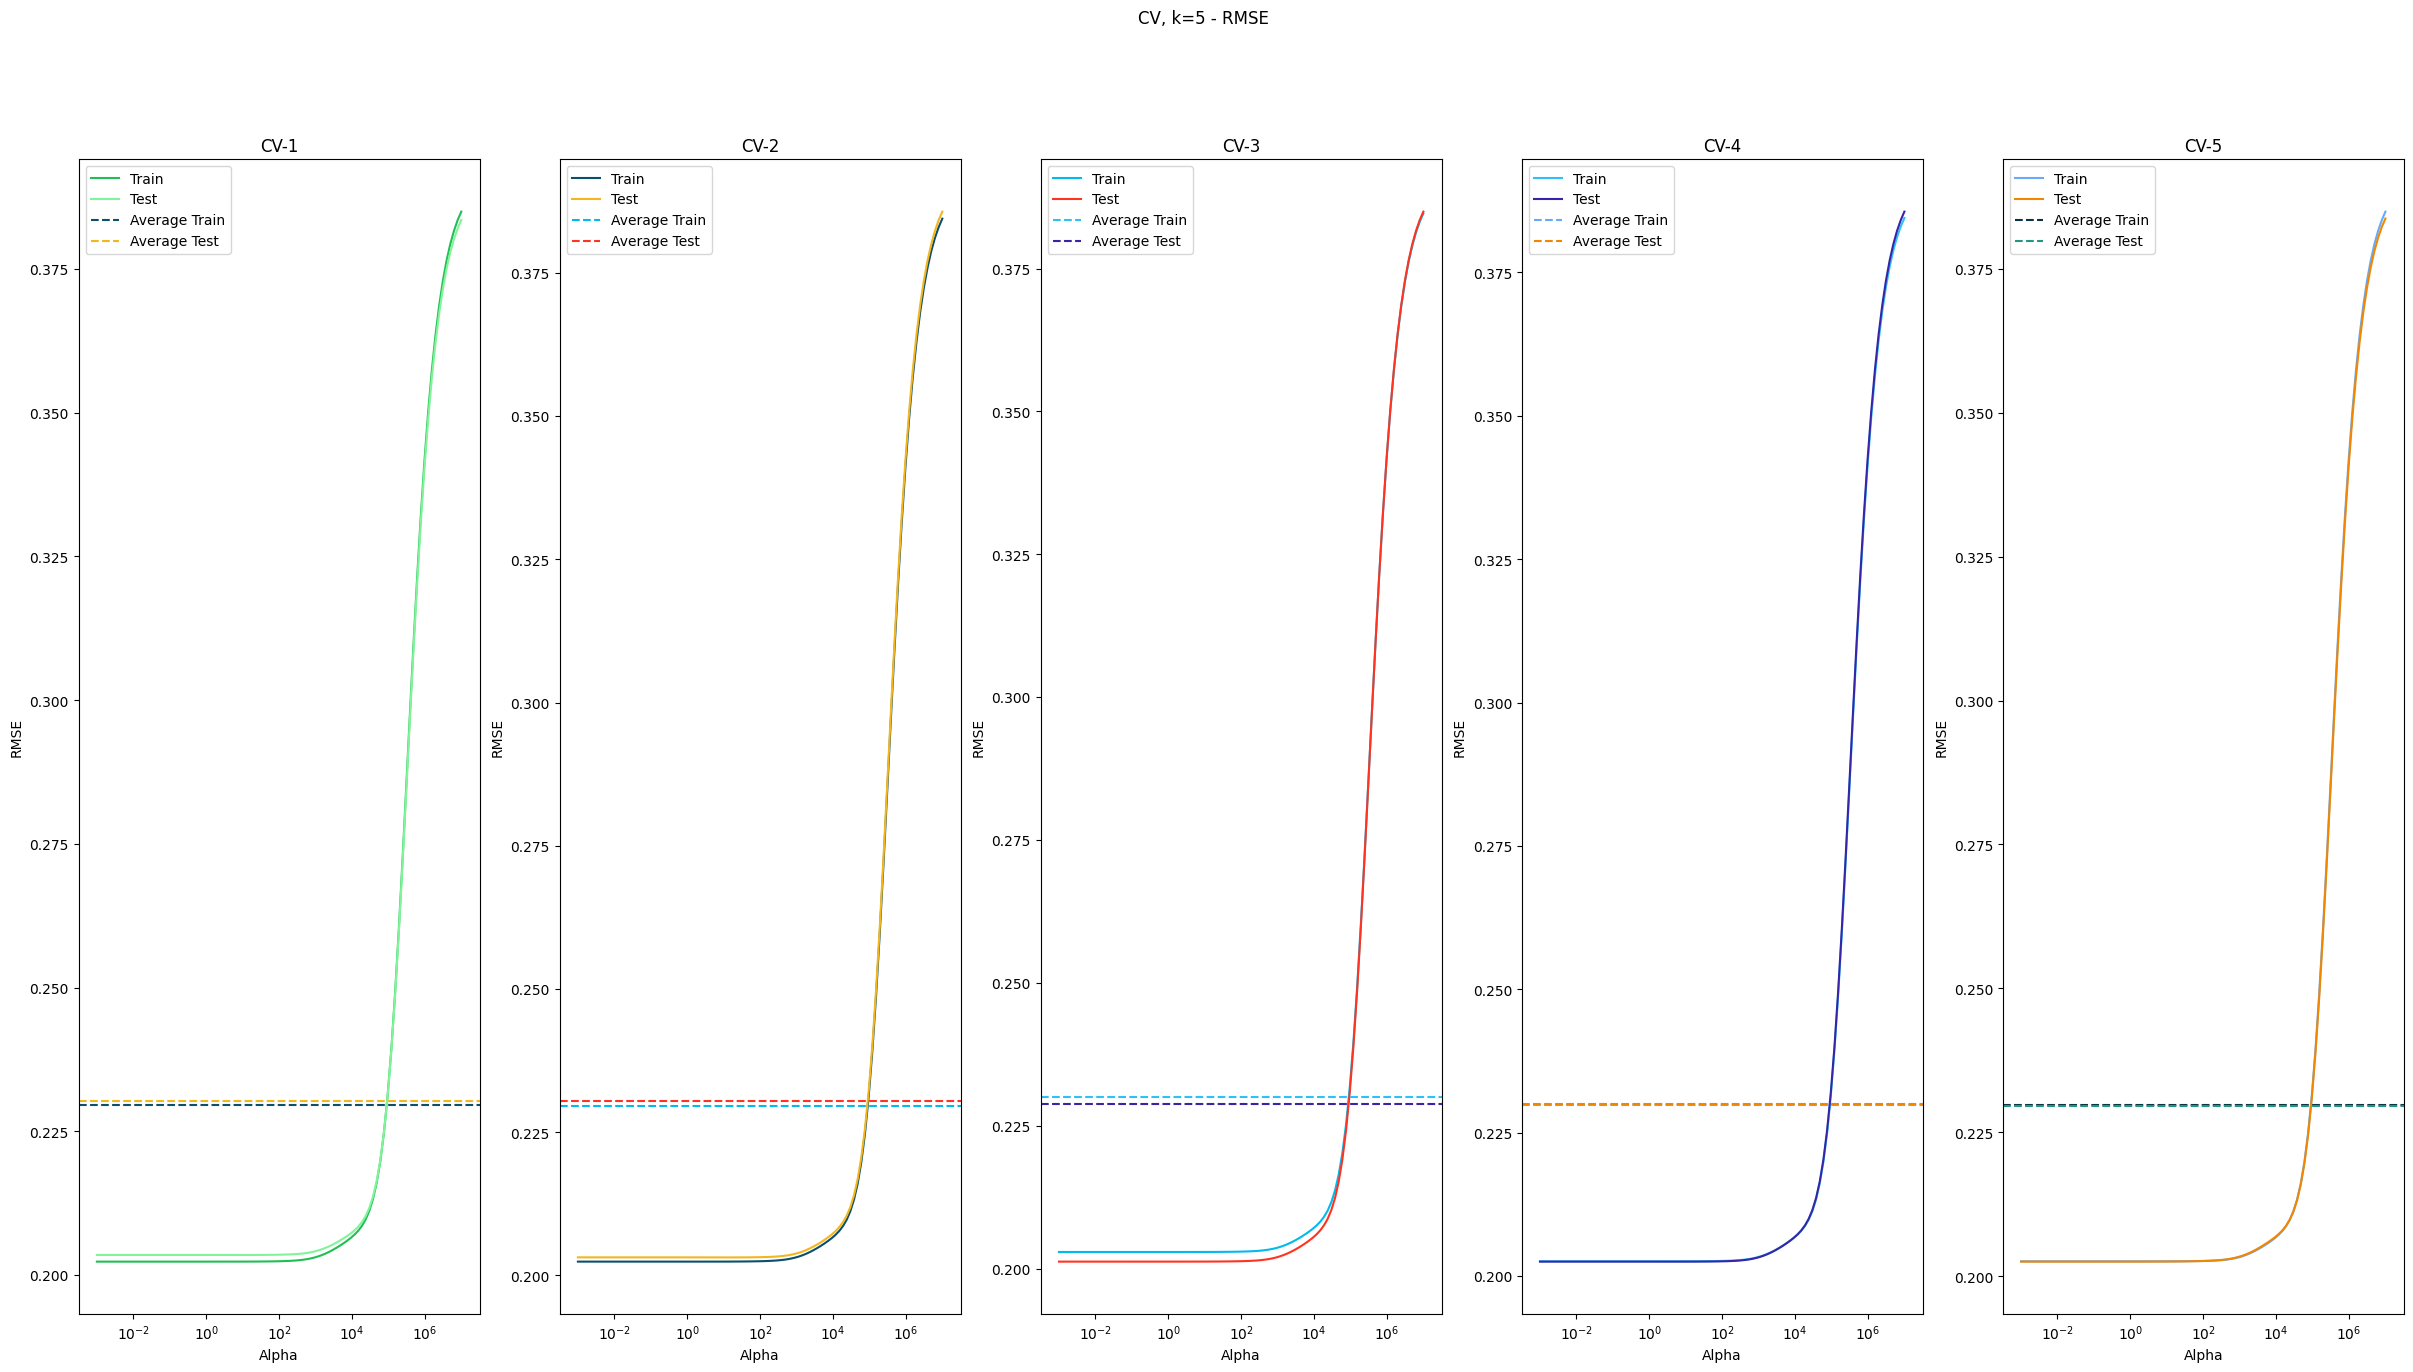

In [53]:
plot_cv_features(alphas, num_results_train_rmse, num_results_test_rmse, save_path_img, 'ridge_regression_numerical_features_CV_rmse.png', 'rmse')

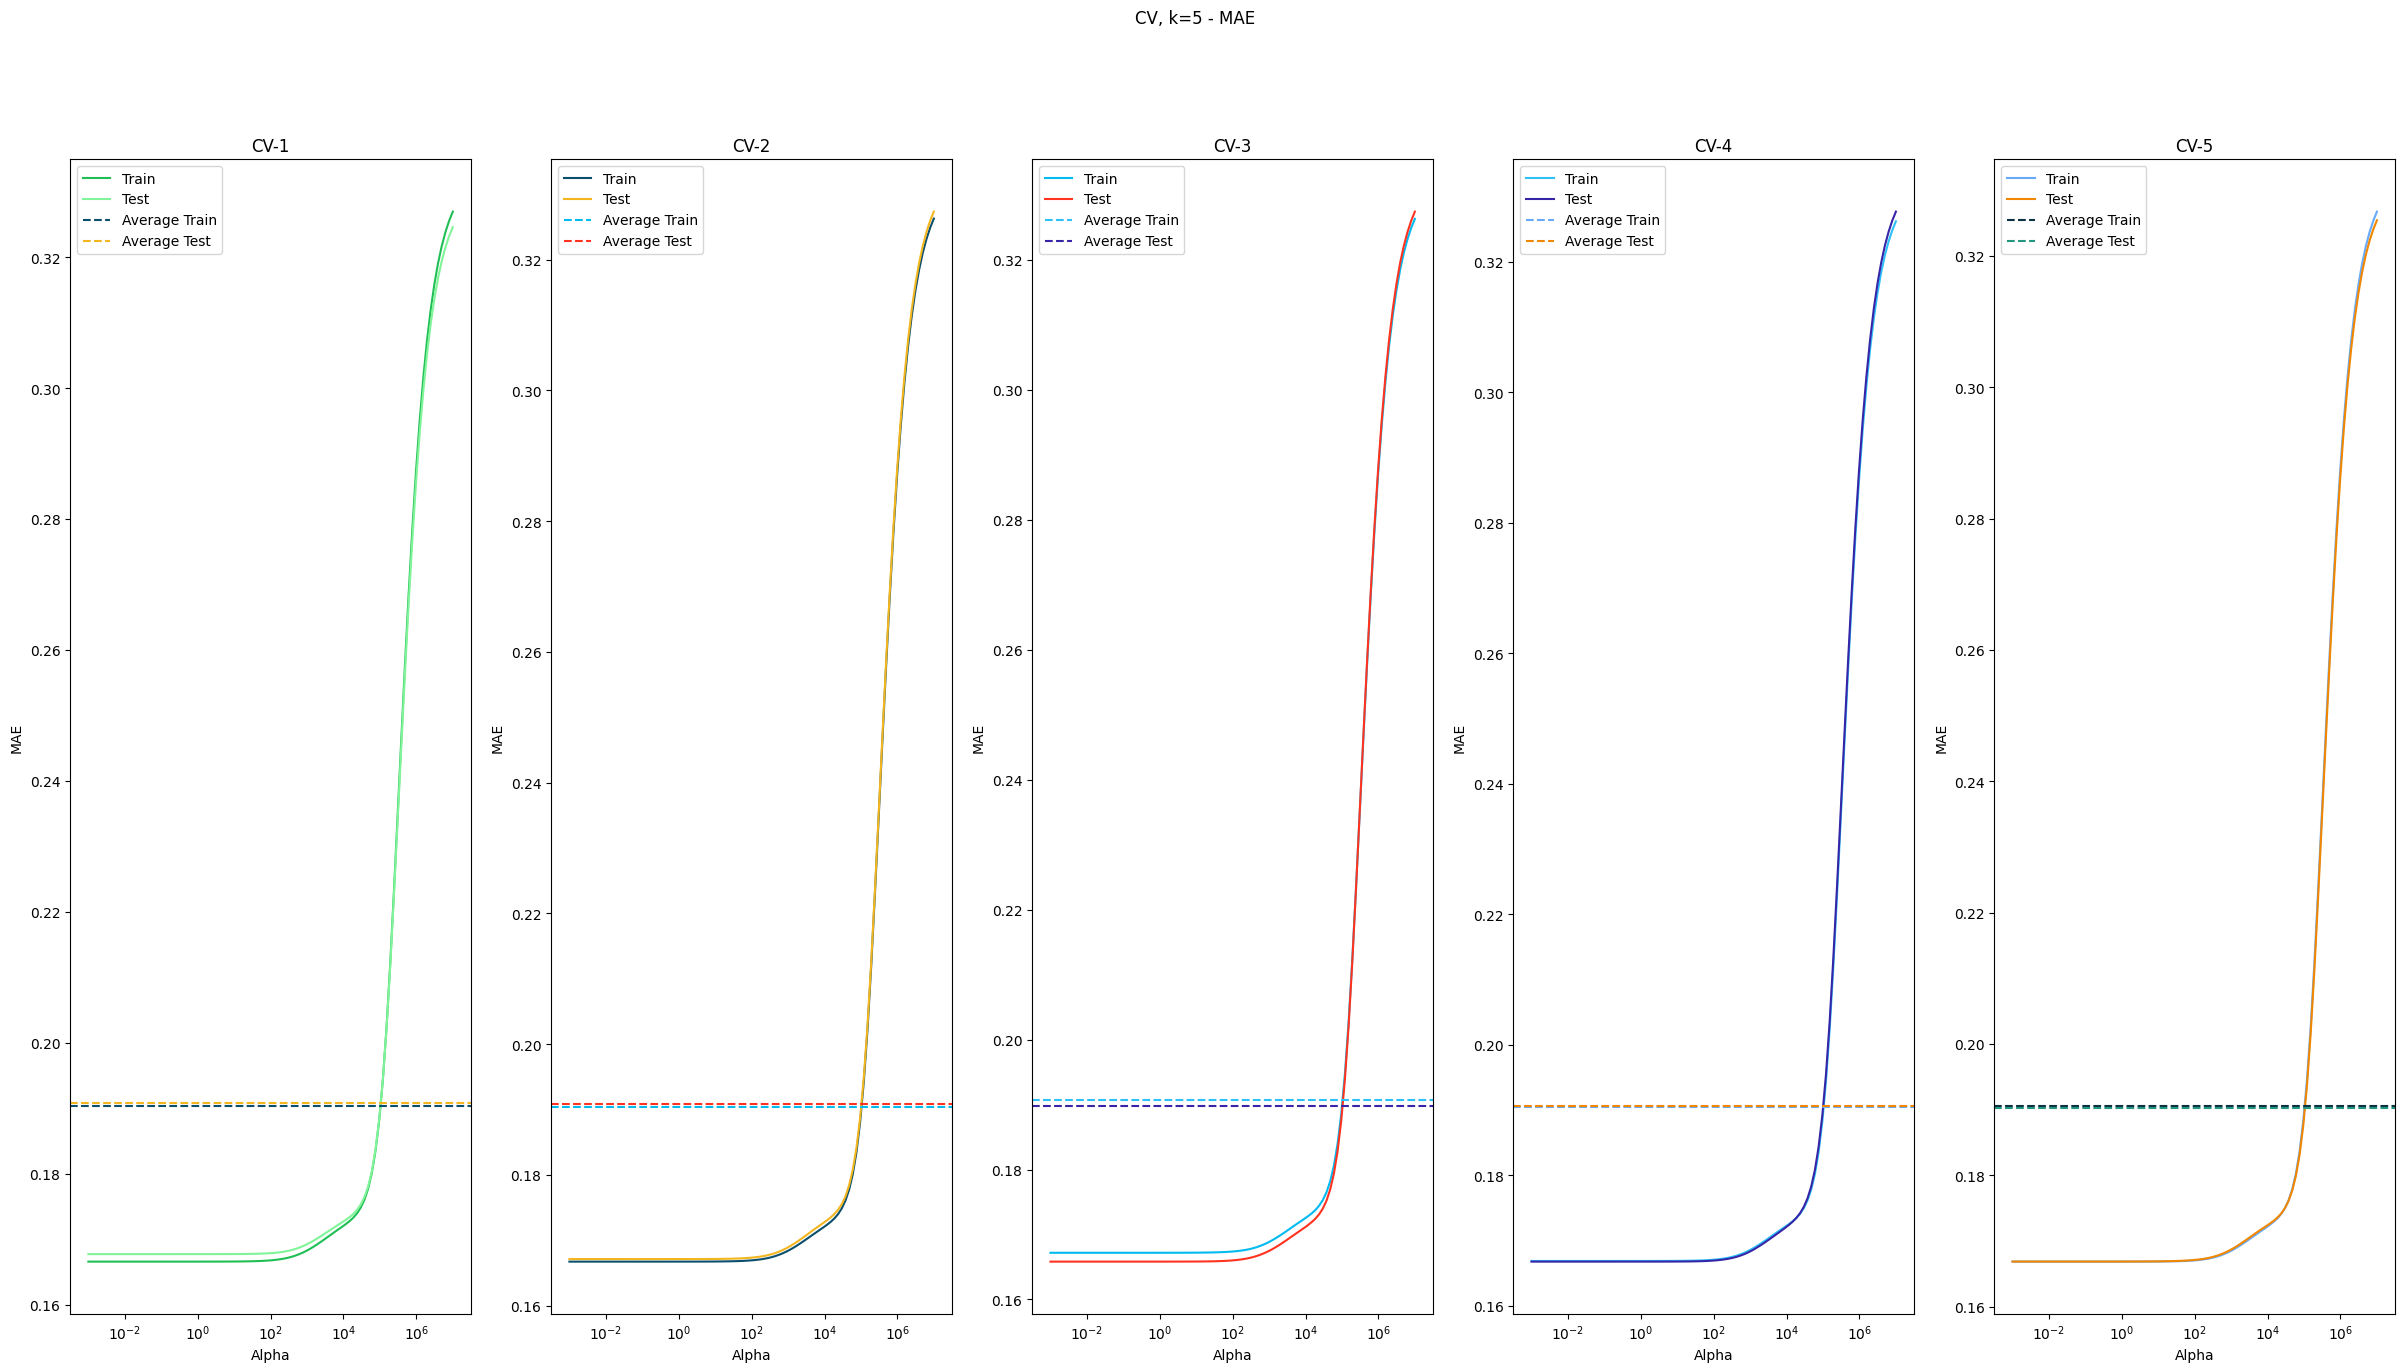

In [54]:
plot_cv_features(alphas, num_results_train_mae, num_results_test_mae, save_path_img, 'ridge_regression_numerical_features_CV_mae.png', 'mae')

## k-Fold Cross Validation using Scratch Model: Numerical Features Metrics Table

In [55]:
table_numerical_k_scratch_cv_validation = PrettyTable()
table_numerical_k_scratch_cv_validation.title = 'Metrics obtained from Scikit model on Numerical Features, 5-cv'
table_numerical_k_scratch_cv_validation.field_names = ["k-fold","Dataset", "Metrics", "Average", "min", "Alpha"]
table_numerical_k_scratch_cv_validation.align["k-fold"] = "l"
table_numerical_k_scratch_cv_validation.align["Dataset"] = "l"
table_numerical_k_scratch_cv_validation.align["Metrics"] = "l"
table_numerical_k_scratch_cv_validation.align["Average"] = "r"
table_numerical_k_scratch_cv_validation.align["min"] = "r"
table_numerical_k_scratch_cv_validation.align["Alpha"] = "r"

table_numerical_k_scratch_cv_validation.add_row(["1", "Train", "MSE", round(np.mean(num_results_train_mse[0]), 6), round(np.min(num_results_train_mse[0]),6), round(alphas[np.argmin(num_results_train_mse[0])],3)])
table_numerical_k_scratch_cv_validation.add_row(["2", "Train", "MSE", round(np.mean(num_results_train_mse[1]), 6), round(np.min(num_results_train_mse[1]),6), round(alphas[np.argmin(num_results_train_mse[1])],3)])
table_numerical_k_scratch_cv_validation.add_row(["3", "Train", "MSE", round(np.mean(num_results_train_mse[2]), 6), round(np.min(num_results_train_mse[2]),6), round(alphas[np.argmin(num_results_train_mse[2])],3)])
table_numerical_k_scratch_cv_validation.add_row(["4", "Train", "MSE", round(np.mean(num_results_train_mse[3]), 6), round(np.min(num_results_train_mse[3]),6), round(alphas[np.argmin(num_results_train_mse[3])],3)])
table_numerical_k_scratch_cv_validation.add_row(["5", "Train", "MSE", round(np.mean(num_results_train_mse[4]), 6), round(np.min(num_results_train_mse[4]),6), round(alphas[np.argmin(num_results_train_mse[4])],3)], divider=True)

table_numerical_k_scratch_cv_validation.add_row(["1", "Train", "RMSE", round(np.mean(num_results_train_rmse[0]), 6), round(np.min(num_results_train_rmse[0]),6), round(alphas[np.argmin(num_results_train_rmse[0])],3)])
table_numerical_k_scratch_cv_validation.add_row(["2", "Train", "RMSE", round(np.mean(num_results_train_rmse[1]), 6), round(np.min(num_results_train_rmse[1]),6), round(alphas[np.argmin(num_results_train_rmse[1])],3)])
table_numerical_k_scratch_cv_validation.add_row(["3", "Train", "RMSE", round(np.mean(num_results_train_rmse[2]), 6), round(np.min(num_results_train_rmse[2]),6), round(alphas[np.argmin(num_results_train_rmse[2])],3)])
table_numerical_k_scratch_cv_validation.add_row(["4", "Train", "RMSE", round(np.mean(num_results_train_rmse[3]), 6), round(np.min(num_results_train_rmse[3]),6), round(alphas[np.argmin(num_results_train_rmse[3])],3)])
table_numerical_k_scratch_cv_validation.add_row(["5", "Train", "RMSE", round(np.mean(num_results_train_rmse[4]), 6), round(np.min(num_results_train_rmse[4]),6), round(alphas[np.argmin(num_results_train_rmse[4])],3)], divider=True)

table_numerical_k_scratch_cv_validation.add_row(["1", "Train", "MAE", round(np.mean(num_results_train_mae[0]), 6), round(np.min(num_results_train_mae[0]),6), round(alphas[np.argmin(num_results_train_mae[0])],3)])
table_numerical_k_scratch_cv_validation.add_row(["2", "Train", "MAE", round(np.mean(num_results_train_mae[1]), 6), round(np.min(num_results_train_mae[1]),6), round(alphas[np.argmin(num_results_train_mae[1])],3)])
table_numerical_k_scratch_cv_validation.add_row(["3", "Train", "MAE", round(np.mean(num_results_train_mae[2]), 6), round(np.min(num_results_train_mae[2]),6), round(alphas[np.argmin(num_results_train_mae[2])],3)])
table_numerical_k_scratch_cv_validation.add_row(["4", "Train", "MAE", round(np.mean(num_results_train_mae[3]), 6), round(np.min(num_results_train_mae[3]),6), round(alphas[np.argmin(num_results_train_mae[3])],3)])
table_numerical_k_scratch_cv_validation.add_row(["5", "Train", "MAE", round(np.mean(num_results_train_mae[4]), 6), round(np.min(num_results_train_mae[4]),6), round(alphas[np.argmin(num_results_train_mae[4])],3)], divider=True)

table_numerical_k_scratch_cv_validation.add_row(["1", "Test", "MSE", round(np.mean(num_results_test_mse[0]), 6), round(np.min(num_results_test_mse[0]),6), round(alphas[np.argmin(num_results_test_mse[0])],3)])
table_numerical_k_scratch_cv_validation.add_row(["2", "Test", "MSE", round(np.mean(num_results_test_mse[1]), 6), round(np.min(num_results_test_mse[1]),6), round(alphas[np.argmin(num_results_test_mse[1])],3)])
table_numerical_k_scratch_cv_validation.add_row(["3", "Test", "MSE", round(np.mean(num_results_test_mse[2]), 6), round(np.min(num_results_test_mse[2]),6), round(alphas[np.argmin(num_results_test_mse[2])],3)])
table_numerical_k_scratch_cv_validation.add_row(["4", "Test", "MSE", round(np.mean(num_results_test_mse[3]), 6), round(np.min(num_results_test_mse[3]),6), round(alphas[np.argmin(num_results_test_mse[3])],3)])
table_numerical_k_scratch_cv_validation.add_row(["5", "Test", "MSE", round(np.mean(num_results_test_mse[4]), 6), round(np.min(num_results_test_mse[4]),6), round(alphas[np.argmin(num_results_test_mse[4])],3)], divider=True)

table_numerical_k_scratch_cv_validation.add_row(["1", "Test", "RMSE", round(np.mean(num_results_test_rmse[0]), 6), round(np.min(num_results_test_rmse[0]),6), round(alphas[np.argmin(num_results_test_rmse[0])],3)])
table_numerical_k_scratch_cv_validation.add_row(["2", "Test", "RMSE", round(np.mean(num_results_test_rmse[1]), 6), round(np.min(num_results_test_rmse[1]),6), round(alphas[np.argmin(num_results_test_rmse[1])],3)])
table_numerical_k_scratch_cv_validation.add_row(["3", "Test", "RMSE", round(np.mean(num_results_test_rmse[2]), 6), round(np.min(num_results_test_rmse[2]),6), round(alphas[np.argmin(num_results_test_rmse[2])],3)])
table_numerical_k_scratch_cv_validation.add_row(["4", "Test", "RMSE", round(np.mean(num_results_test_rmse[3]), 6), round(np.min(num_results_test_rmse[3]),6), round(alphas[np.argmin(num_results_test_rmse[3])],3)])
table_numerical_k_scratch_cv_validation.add_row(["5", "Test", "RMSE", round(np.mean(num_results_test_rmse[4]), 6), round(np.min(num_results_test_rmse[4]),6), round(alphas[np.argmin(num_results_test_rmse[4])],3)], divider=True)

table_numerical_k_scratch_cv_validation.add_row(["1", "Test", "MAE", round(np.mean(num_results_test_mae[0]), 6), round(np.min(num_results_test_mae[0]),6), round(alphas[np.argmin(num_results_test_mae[0])],3)])
table_numerical_k_scratch_cv_validation.add_row(["2", "Test", "MAE", round(np.mean(num_results_test_mae[1]), 6), round(np.min(num_results_test_mae[1]),6), round(alphas[np.argmin(num_results_test_mae[1])],3)])
table_numerical_k_scratch_cv_validation.add_row(["3", "Test", "MAE", round(np.mean(num_results_test_mae[2]), 6), round(np.min(num_results_test_mae[2]),6), round(alphas[np.argmin(num_results_test_mae[2])],3)])
table_numerical_k_scratch_cv_validation.add_row(["4", "Test", "MAE", round(np.mean(num_results_test_mae[3]), 6), round(np.min(num_results_test_mae[3]),6), round(alphas[np.argmin(num_results_test_mae[3])],3)])
table_numerical_k_scratch_cv_validation.add_row(["5", "Test", "MAE", round(np.mean(num_results_test_mae[4]), 6), round(np.min(num_results_test_mae[4]),6), round(alphas[np.argmin(num_results_test_mae[4])],3)], divider=True)

print(table_numerical_k_scratch_cv_validation)

+----------------------------------------------------------------+
| Metrics obtained from Scikit model on Numerical Features, 5-cv |
+--------+---------+---------+----------+----------+-------------+
| k-fold | Dataset | Metrics |  Average |      min |       Alpha |
+--------+---------+---------+----------+----------+-------------+
| 1      | Train   | MSE     | 0.055788 | 0.040939 |       0.001 |
| 2      | Train   | MSE     | 0.055765 | 0.040973 |       0.001 |
| 3      | Train   | MSE     | 0.055951 |  0.04117 |       0.001 |
| 4      | Train   | MSE     |  0.05582 | 0.041037 |       0.001 |
| 5      | Train   | MSE     |  0.05586 | 0.041037 |       0.001 |
+--------+---------+---------+----------+----------+-------------+
| 1      | Train   | RMSE    | 0.229633 | 0.202333 |       0.001 |
| 2      | Train   | RMSE    | 0.229628 | 0.202417 |       0.001 |
| 3      | Train   | RMSE    | 0.230055 | 0.202903 |       0.001 |
| 4      | Train   | RMSE    | 0.229758 | 0.202576 |       0.0

## k-Fold Cross Validation using Scratch Model: Categorical Features Representation

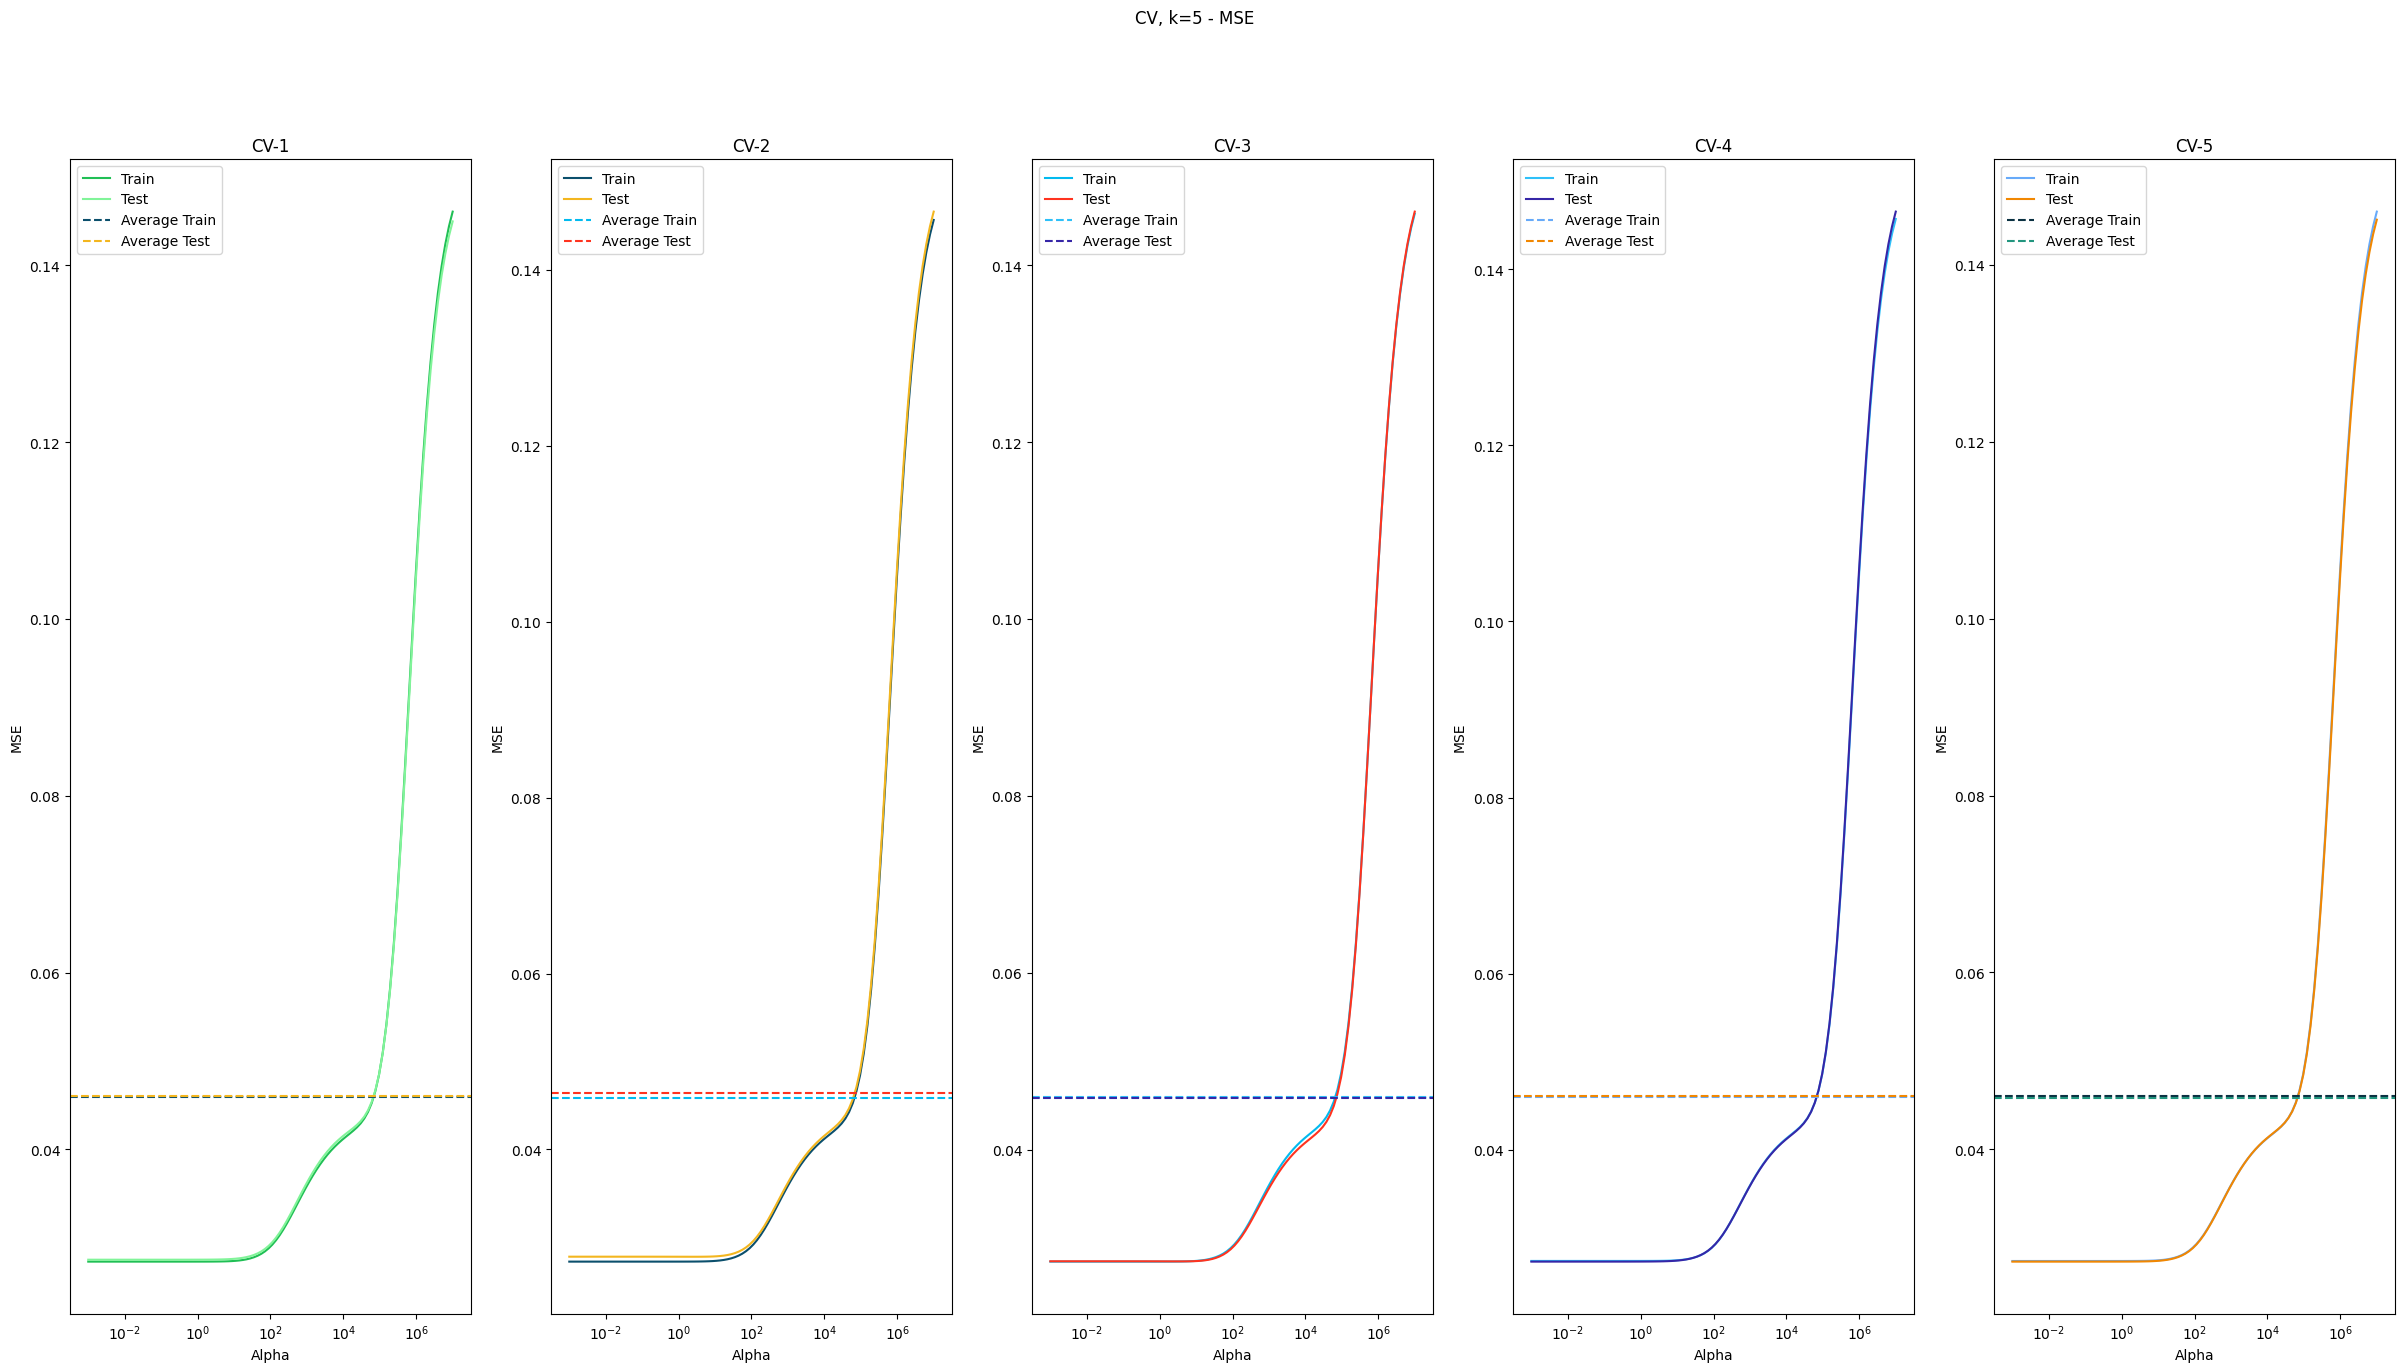

In [56]:
plot_cv_features(alphas, cat_results_train_mse, cat_results_test_mse, save_path_img, 'ridge_regression_categorical_features_CV_mse.png', 'mse')

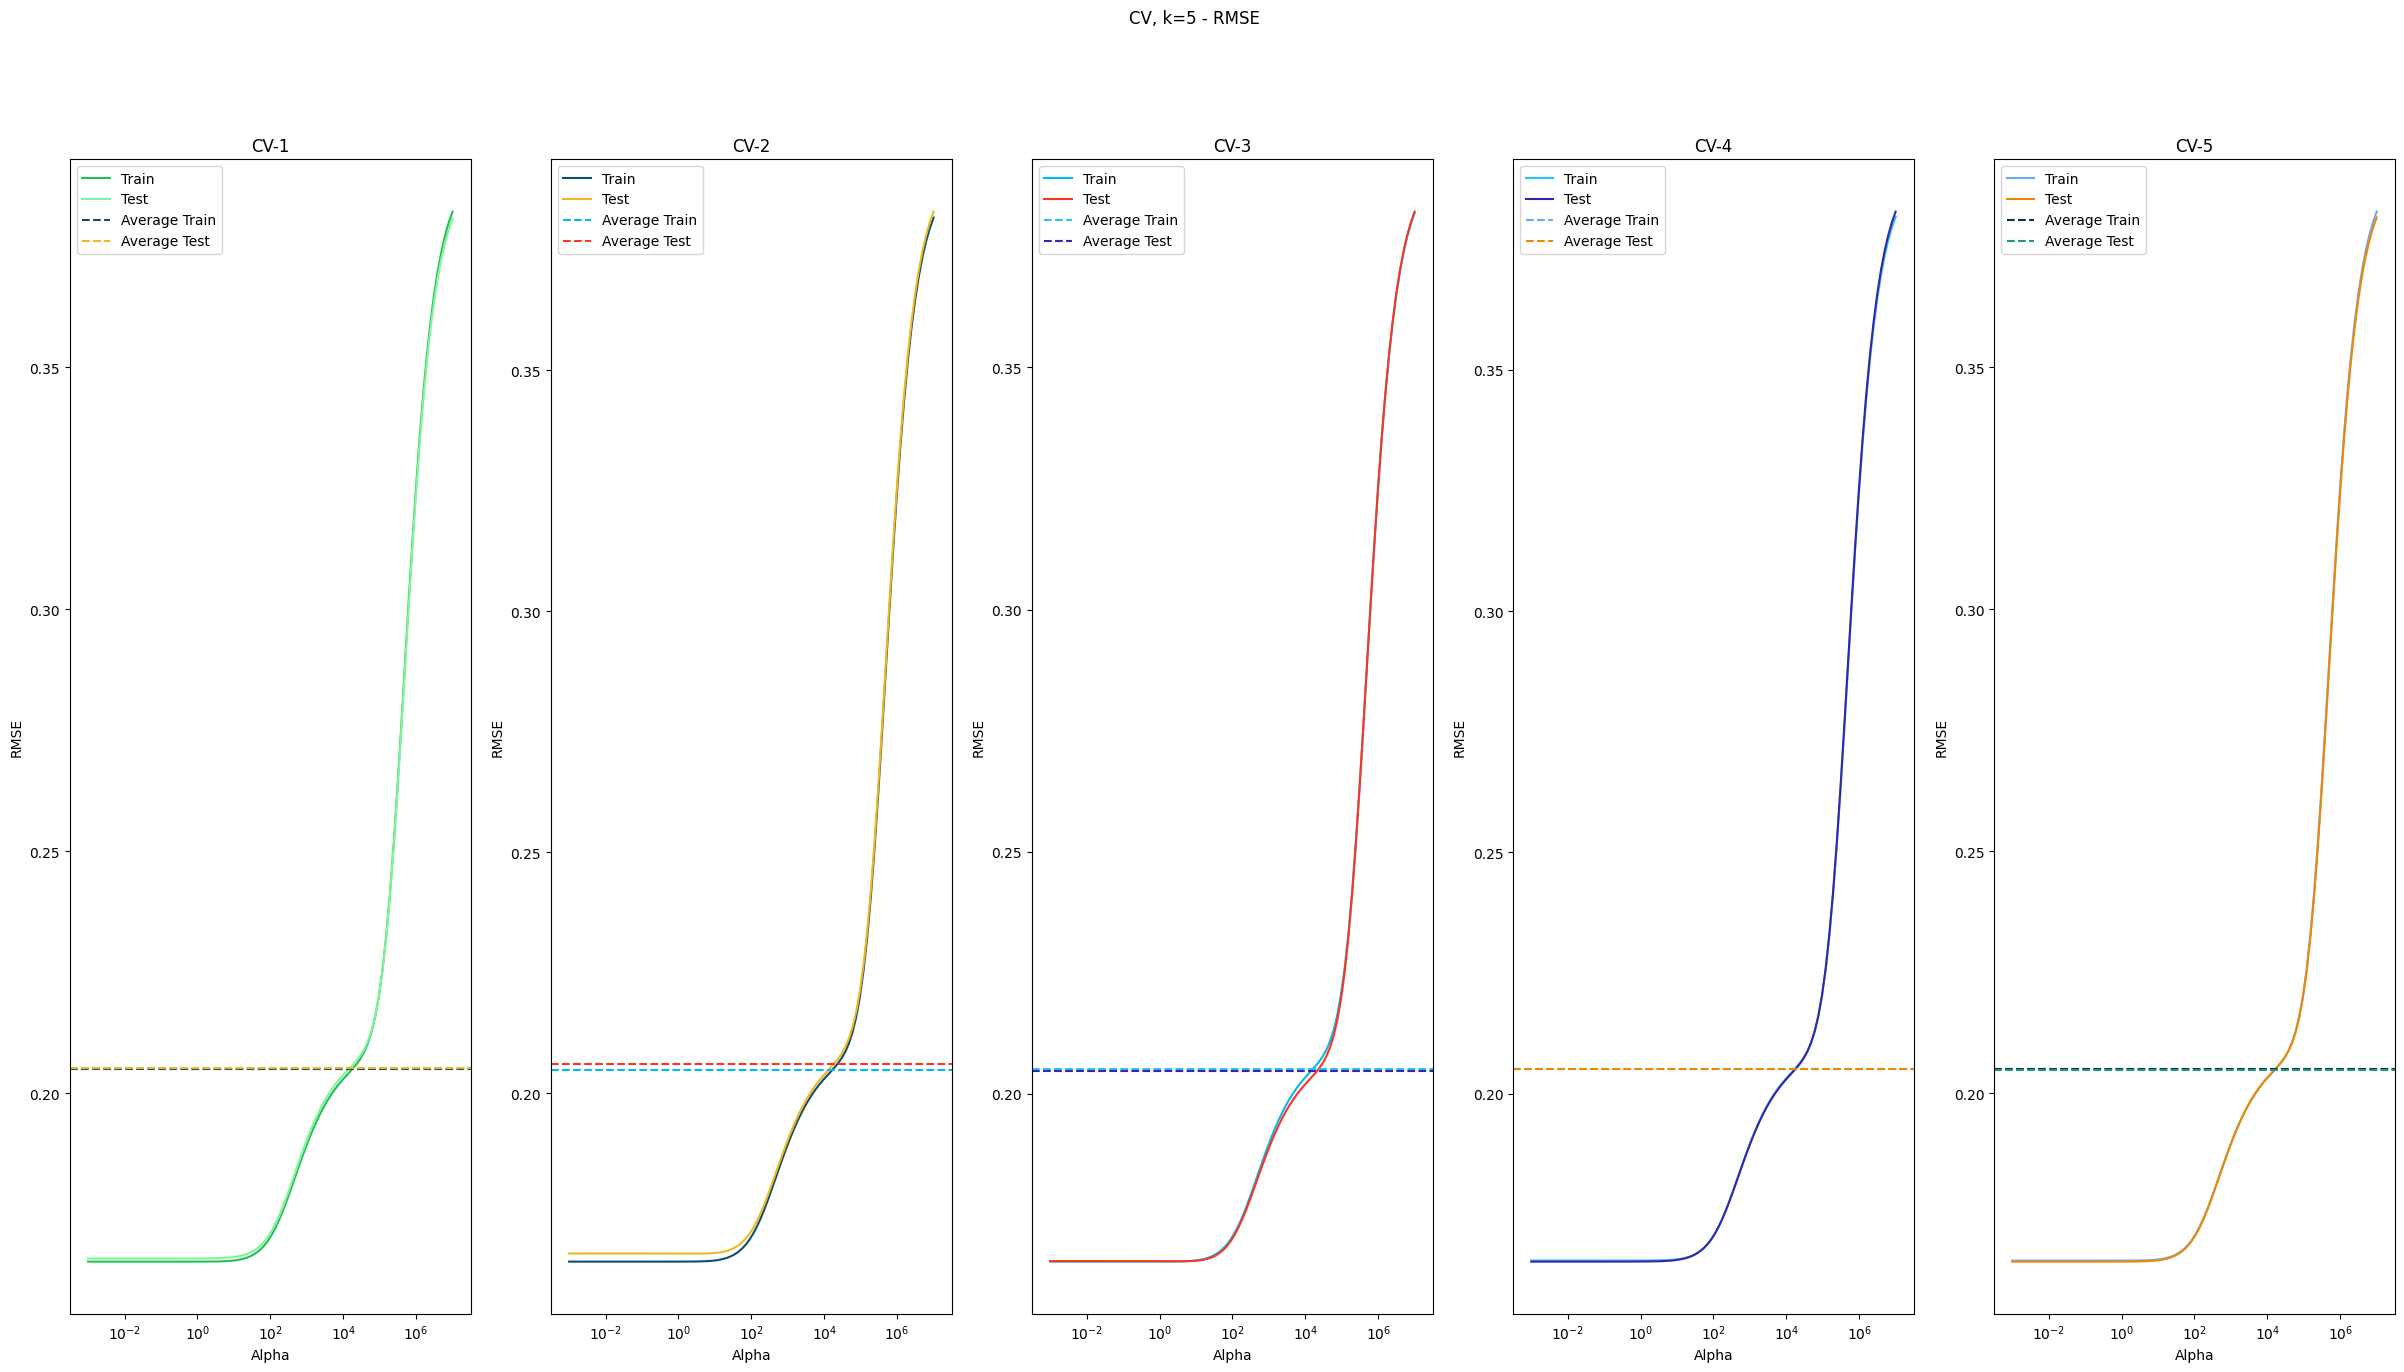

In [57]:
plot_cv_features(alphas, cat_results_train_rmse, cat_results_test_rmse, save_path_img, 'ridge_regression_categorical_features_CV_rmse.png', 'rmse')

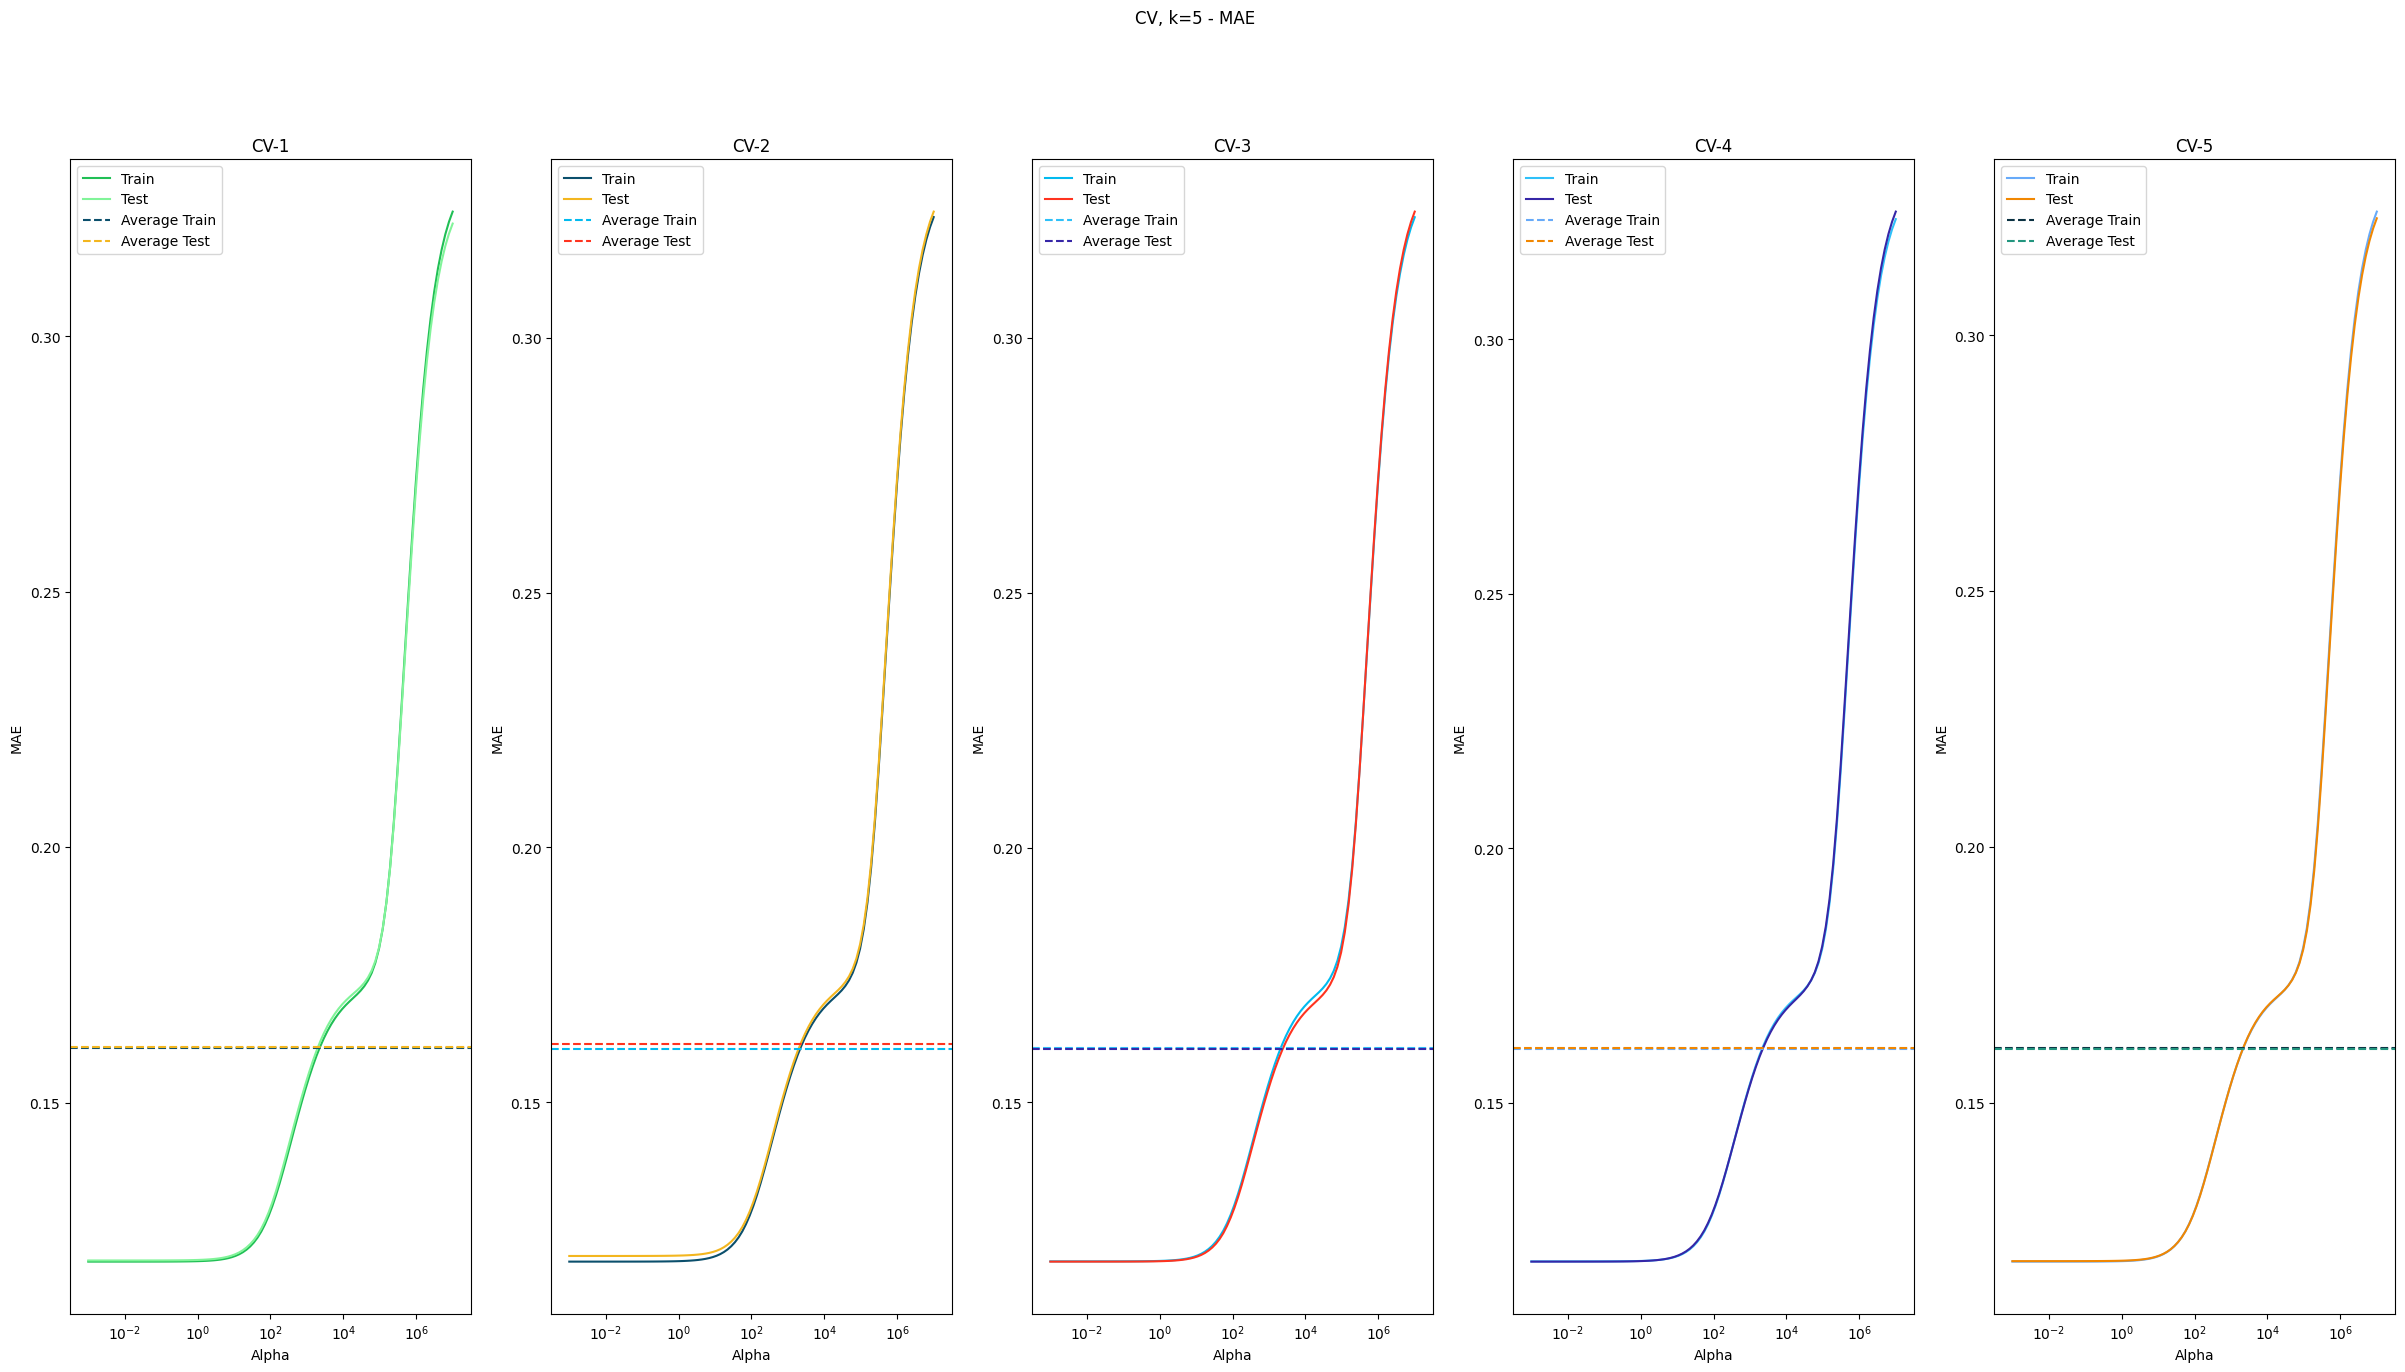

In [58]:
plot_cv_features(alphas, cat_results_train_mae, cat_results_test_mae, save_path_img, 'ridge_regression_numerical_categorical_CV_mae.png', 'mae')

## k-Fold Cross Validation using Scratch Model: Categorical Features Metrics Table

In [59]:
table_categorical_k_scratch_cv_validation = PrettyTable()
table_categorical_k_scratch_cv_validation.title = 'Metrics obtained from Scikit model on Categorical features, 5-cv'
table_categorical_k_scratch_cv_validation.field_names = ["k-fold","Dataset", "Metrics", "Average", "min", "Alpha"]
table_categorical_k_scratch_cv_validation.align["k-fold"] = "l"
table_categorical_k_scratch_cv_validation.align["Dataset"] = "l"
table_categorical_k_scratch_cv_validation.align["Metrics"] = "l"
table_categorical_k_scratch_cv_validation.align["Average"] = "r"
table_categorical_k_scratch_cv_validation.align["min"] = "r"
table_categorical_k_scratch_cv_validation.align["Alpha"] = "r"

table_categorical_k_scratch_cv_validation.add_row(["1", "Train", "MSE", round(np.mean(cat_results_train_mse[0]), 6), round(np.min(cat_results_train_mse[0]),6), round(alphas[np.argmin(cat_results_train_mse[0])],3)])
table_categorical_k_scratch_cv_validation.add_row(["2", "Train", "MSE", round(np.mean(cat_results_train_mse[1]), 6), round(np.min(cat_results_train_mse[1]),6), round(alphas[np.argmin(cat_results_train_mse[1])],3)])
table_categorical_k_scratch_cv_validation.add_row(["3", "Train", "MSE", round(np.mean(cat_results_train_mse[2]), 6), round(np.min(cat_results_train_mse[2]),6), round(alphas[np.argmin(cat_results_train_mse[2])],3)])
table_categorical_k_scratch_cv_validation.add_row(["4", "Train", "MSE", round(np.mean(cat_results_train_mse[3]), 6), round(np.min(cat_results_train_mse[3]),6), round(alphas[np.argmin(cat_results_train_mse[3])],3)])
table_categorical_k_scratch_cv_validation.add_row(["5", "Train", "MSE", round(np.mean(cat_results_train_mse[4]), 6), round(np.min(cat_results_train_mse[4]),6), round(alphas[np.argmin(cat_results_train_mse[4])],3)], divider=True)

table_categorical_k_scratch_cv_validation.add_row(["1", "Train", "RMSE", round(np.mean(cat_results_train_rmse[0]), 6), round(np.min(cat_results_train_rmse[0]),6), round(alphas[np.argmin(cat_results_train_rmse[0])],3)])
table_categorical_k_scratch_cv_validation.add_row(["2", "Train", "RMSE", round(np.mean(cat_results_train_rmse[1]), 6), round(np.min(cat_results_train_rmse[1]),6), round(alphas[np.argmin(cat_results_train_rmse[1])],3)])
table_categorical_k_scratch_cv_validation.add_row(["3", "Train", "RMSE", round(np.mean(cat_results_train_rmse[2]), 6), round(np.min(cat_results_train_rmse[2]),6), round(alphas[np.argmin(cat_results_train_rmse[2])],3)])
table_categorical_k_scratch_cv_validation.add_row(["4", "Train", "RMSE", round(np.mean(cat_results_train_rmse[3]), 6), round(np.min(cat_results_train_rmse[3]),6), round(alphas[np.argmin(cat_results_train_rmse[3])],3)])
table_categorical_k_scratch_cv_validation.add_row(["5", "Train", "RMSE", round(np.mean(cat_results_train_rmse[4]), 6), round(np.min(cat_results_train_rmse[4]),6), round(alphas[np.argmin(cat_results_train_rmse[4])],3)], divider=True)

table_categorical_k_scratch_cv_validation.add_row(["1", "Train", "MAE", round(np.mean(cat_results_train_mae[0]), 6), round(np.min(cat_results_train_mae[0]),6), round(alphas[np.argmin(cat_results_train_mae[0])],3)])
table_categorical_k_scratch_cv_validation.add_row(["2", "Train", "MAE", round(np.mean(cat_results_train_mae[1]), 6), round(np.min(cat_results_train_mae[1]),6), round(alphas[np.argmin(cat_results_train_mae[1])],3)])
table_categorical_k_scratch_cv_validation.add_row(["3", "Train", "MAE", round(np.mean(cat_results_train_mae[2]), 6), round(np.min(cat_results_train_mae[2]),6), round(alphas[np.argmin(cat_results_train_mae[2])],3)])
table_categorical_k_scratch_cv_validation.add_row(["4", "Train", "MAE", round(np.mean(cat_results_train_mae[3]), 6), round(np.min(cat_results_train_mae[3]),6), round(alphas[np.argmin(cat_results_train_mae[3])],3)])
table_categorical_k_scratch_cv_validation.add_row(["5", "Train", "MAE", round(np.mean(cat_results_train_mae[4]), 6), round(np.min(cat_results_train_mae[4]),6), round(alphas[np.argmin(cat_results_train_mae[4])],3)], divider=True)

table_categorical_k_scratch_cv_validation.add_row(["1", "Test", "MSE", round(np.mean(cat_results_test_mse[0]), 6), round(np.min(cat_results_test_mse[0]),6), round(alphas[np.argmin(cat_results_test_mse[0])],3)])
table_categorical_k_scratch_cv_validation.add_row(["2", "Test", "MSE", round(np.mean(cat_results_test_mse[1]), 6), round(np.min(cat_results_test_mse[1]),6), round(alphas[np.argmin(cat_results_test_mse[1])],3)])
table_categorical_k_scratch_cv_validation.add_row(["3", "Test", "MSE", round(np.mean(cat_results_test_mse[2]), 6), round(np.min(cat_results_test_mse[2]),6), round(alphas[np.argmin(cat_results_test_mse[2])],3)])
table_categorical_k_scratch_cv_validation.add_row(["4", "Test", "MSE", round(np.mean(cat_results_test_mse[3]), 6), round(np.min(cat_results_test_mse[3]),6), round(alphas[np.argmin(cat_results_test_mse[3])],3)])
table_categorical_k_scratch_cv_validation.add_row(["5", "Test", "MSE", round(np.mean(cat_results_test_mse[4]), 6), round(np.min(cat_results_test_mse[4]),6), round(alphas[np.argmin(cat_results_test_mse[4])],3)], divider=True)

table_categorical_k_scratch_cv_validation.add_row(["1", "Test", "RMSE", round(np.mean(cat_results_test_rmse[0]), 6), round(np.min(cat_results_test_rmse[0]),6), round(alphas[np.argmin(cat_results_test_rmse[0])],3)])
table_categorical_k_scratch_cv_validation.add_row(["2", "Test", "RMSE", round(np.mean(cat_results_test_rmse[1]), 6), round(np.min(cat_results_test_rmse[1]),6), round(alphas[np.argmin(cat_results_test_rmse[1])],3)])
table_categorical_k_scratch_cv_validation.add_row(["3", "Test", "RMSE", round(np.mean(cat_results_test_rmse[2]), 6), round(np.min(cat_results_test_rmse[2]),6), round(alphas[np.argmin(cat_results_test_rmse[2])],3)])
table_categorical_k_scratch_cv_validation.add_row(["4", "Test", "RMSE", round(np.mean(cat_results_test_rmse[3]), 6), round(np.min(cat_results_test_rmse[3]),6), round(alphas[np.argmin(cat_results_test_rmse[3])],3)])
table_categorical_k_scratch_cv_validation.add_row(["5", "Test", "RMSE", round(np.mean(cat_results_test_rmse[4]), 6), round(np.min(cat_results_test_rmse[4]),6), round(alphas[np.argmin(cat_results_test_rmse[4])],3)], divider=True)

table_categorical_k_scratch_cv_validation.add_row(["1", "Test", "MAE", round(np.mean(cat_results_test_mae[0]), 6), round(np.min(cat_results_test_mae[0]),6), round(alphas[np.argmin(cat_results_test_mae[0])],3)])
table_categorical_k_scratch_cv_validation.add_row(["2", "Test", "MAE", round(np.mean(cat_results_test_mae[1]), 6), round(np.min(cat_results_test_mae[1]),6), round(alphas[np.argmin(cat_results_test_mae[1])],3)])
table_categorical_k_scratch_cv_validation.add_row(["3", "Test", "MAE", round(np.mean(cat_results_test_mae[2]), 6), round(np.min(cat_results_test_mae[2]),6), round(alphas[np.argmin(cat_results_test_mae[2])],3)])
table_categorical_k_scratch_cv_validation.add_row(["4", "Test", "MAE", round(np.mean(cat_results_test_mae[3]), 6), round(np.min(cat_results_test_mae[3]),6), round(alphas[np.argmin(cat_results_test_mae[3])],3)])
table_categorical_k_scratch_cv_validation.add_row(["5", "Test", "MAE", round(np.mean(cat_results_test_mae[4]), 6), round(np.min(cat_results_test_mae[4]),6), round(alphas[np.argmin(cat_results_test_mae[4])],3)], divider=True)

print(table_categorical_k_scratch_cv_validation)

+------------------------------------------------------------------+
| Metrics obtained from Scikit model on Categorical features, 5-cv |
+---------+----------+----------+-----------+-----------+----------+
| k-fold  | Dataset  | Metrics  |   Average |       min |    Alpha |
+---------+----------+----------+-----------+-----------+----------+
| 1       | Train    | MSE      |  0.045958 |  0.027305 |    0.001 |
| 2       | Train    | MSE      |  0.045881 |  0.027242 |    0.001 |
| 3       | Train    | MSE      |  0.046012 |  0.027347 |    0.001 |
| 4       | Train    | MSE      |  0.045978 |  0.027367 |    0.001 |
| 5       | Train    | MSE      |   0.04601 |  0.027364 |    0.001 |
+---------+----------+----------+-----------+-----------+----------+
| 1       | Train    | RMSE     |  0.204946 |  0.165242 |    0.001 |
| 2       | Train    | RMSE     |  0.204784 |  0.165052 |    0.001 |
| 3       | Train    | RMSE     |  0.205111 |  0.165368 |    0.001 |
| 4       | Train    | RMSE     | 

# k-Fold Cross Validation using Scikit Model

In [60]:
# Compute k-Fold CV from Scikit on Numerical Features
sk_num_results_train_mse, sk_num_results_train_rmse, sk_num_results_train_mae, \
sk_num_results_test_mse, sk_num_results_test_rmse, sk_num_results_test_mae, sk_num_best_alpha = k_fold_cv_scikit_ridge_regression(numb_data, alphas, 5)

In [61]:
# Compute k-Fold CV from Scikit on Categorical Features
sk_cat_results_train_mse, sk_cat_results_train_rmse, sk_cat_results_train_mae, \
sk_cat_results_test_mse, sk_cat_results_test_rmse, sk_cat_results_test_mae, sk_cat_best_alpha = k_fold_cv_scikit_ridge_regression(total_data, alphas, 5)

In [62]:
print("The best value of alpha while using the numerical dataset is", round(sk_num_best_alpha,4))
print("The best value of alpha while using the categorical dataset is", round(sk_cat_best_alpha,4))

The best value of alpha while using the numerical dataset is 0.001
The best value of alpha while using the categorical dataset is 0.001


## k-Fold Cross Validation using Scikit Model: Numerical Features Representation

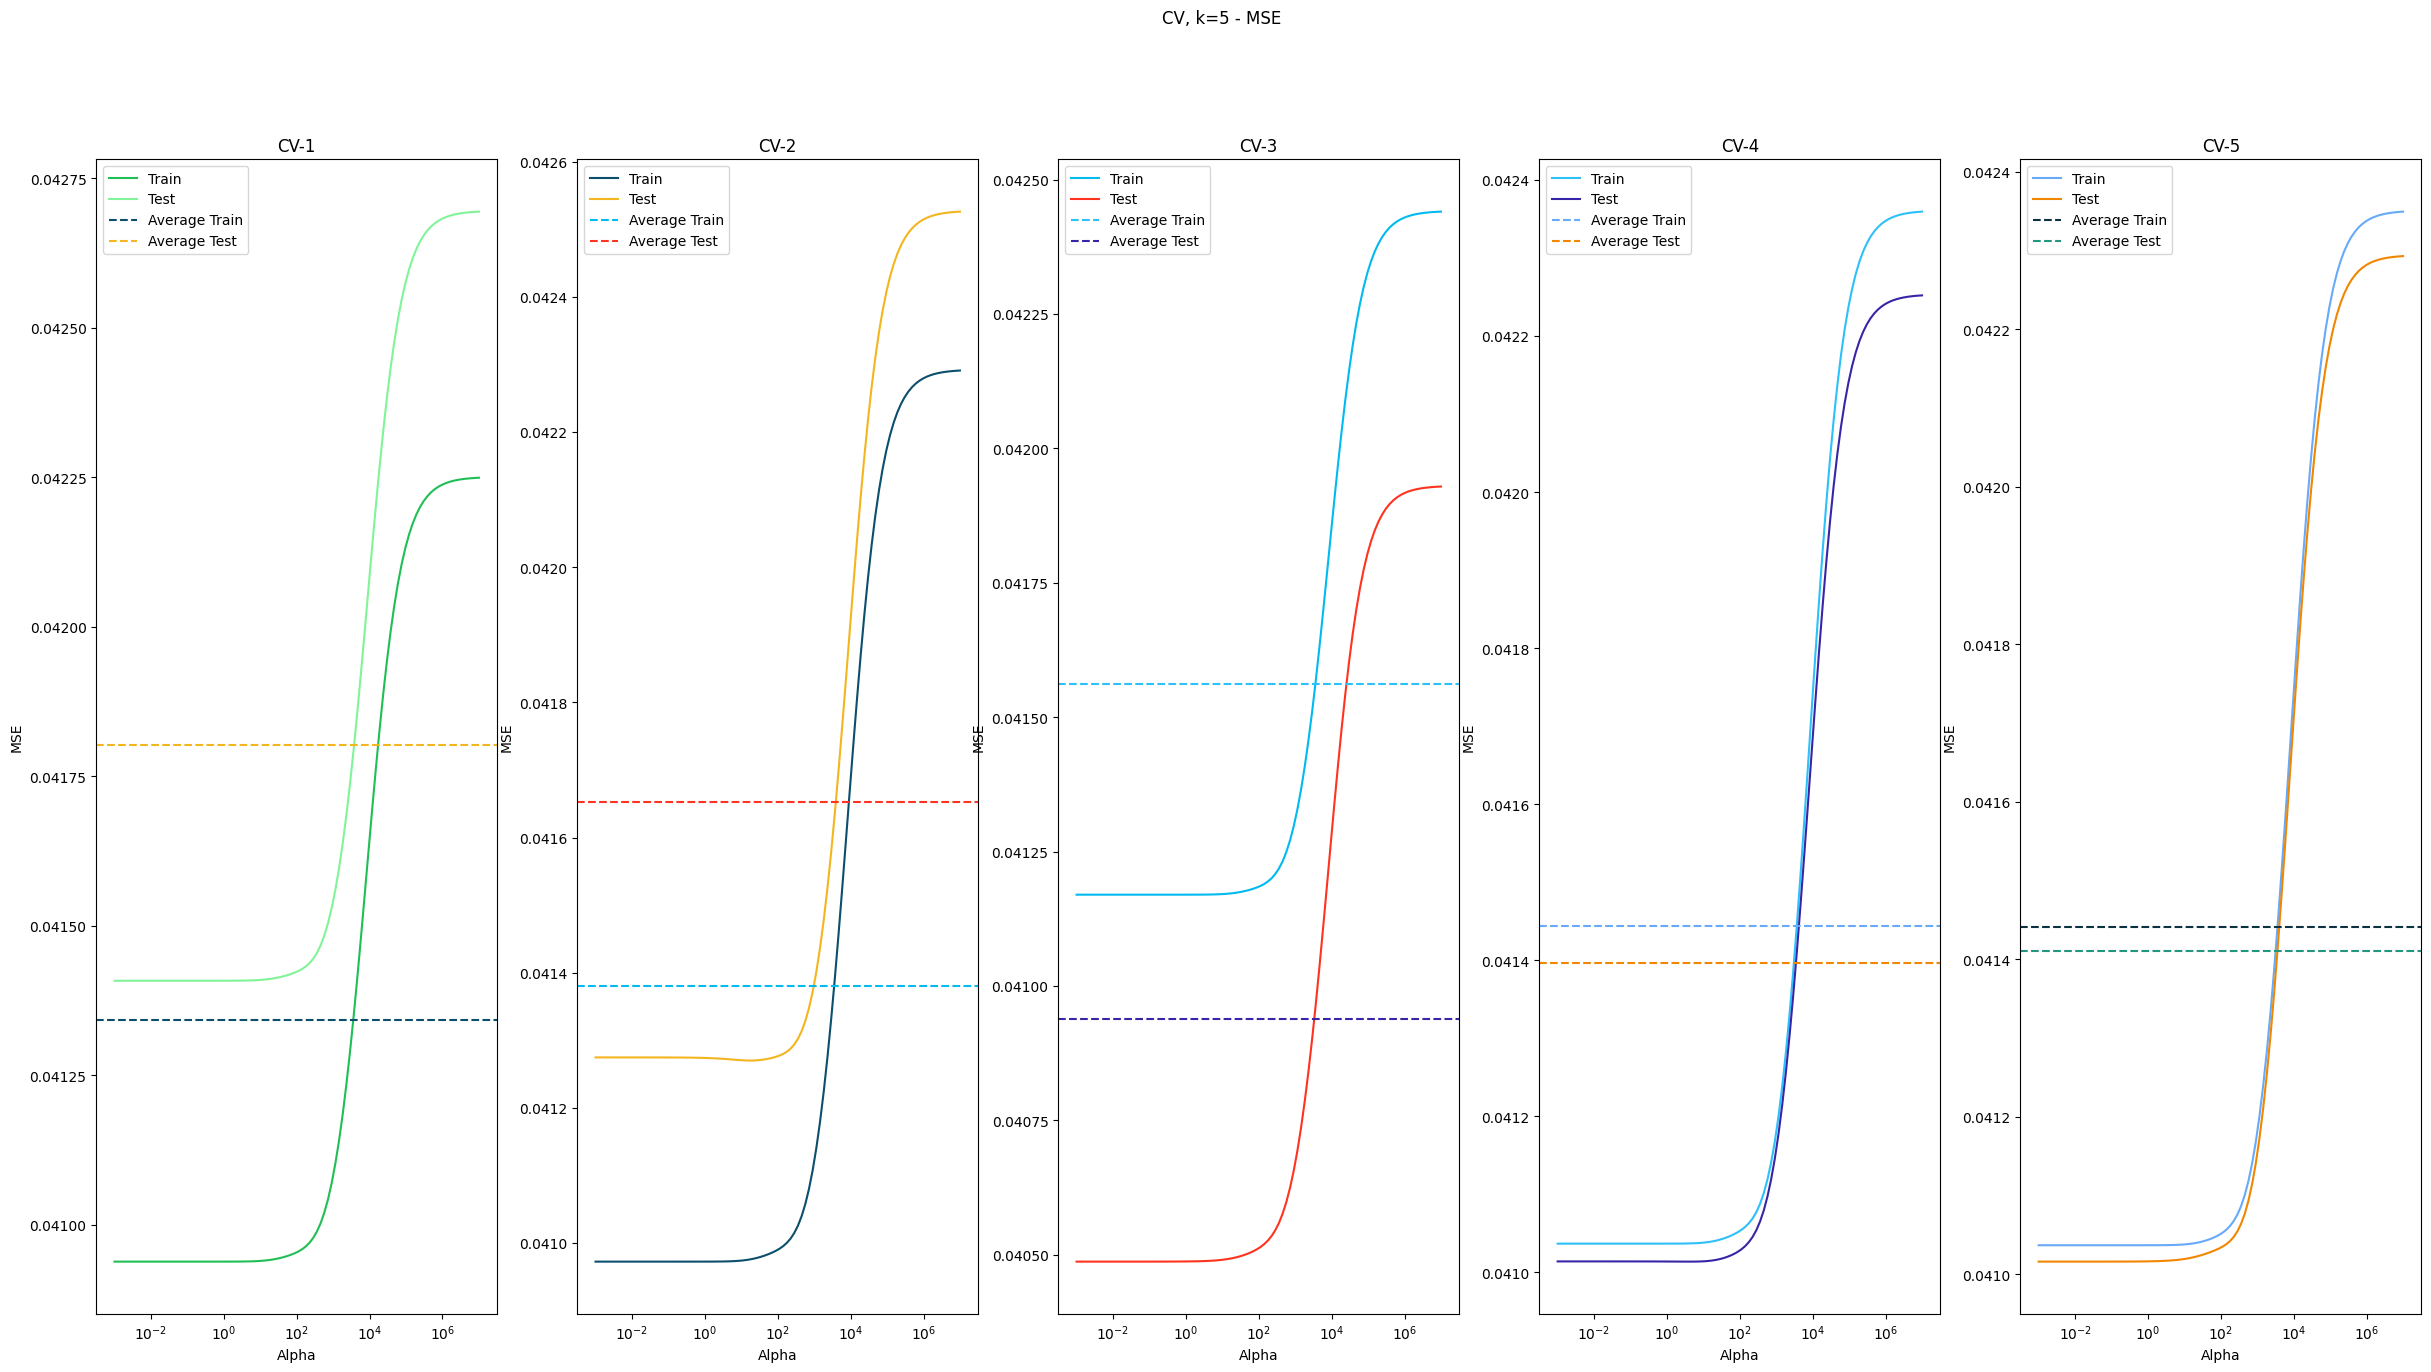

In [63]:
plot_cv_features(alphas, sk_num_results_train_mse, sk_num_results_test_mse, save_path_img, 'ridge_regression_numerical_features_CV_scikit_mse.png', 'mse')

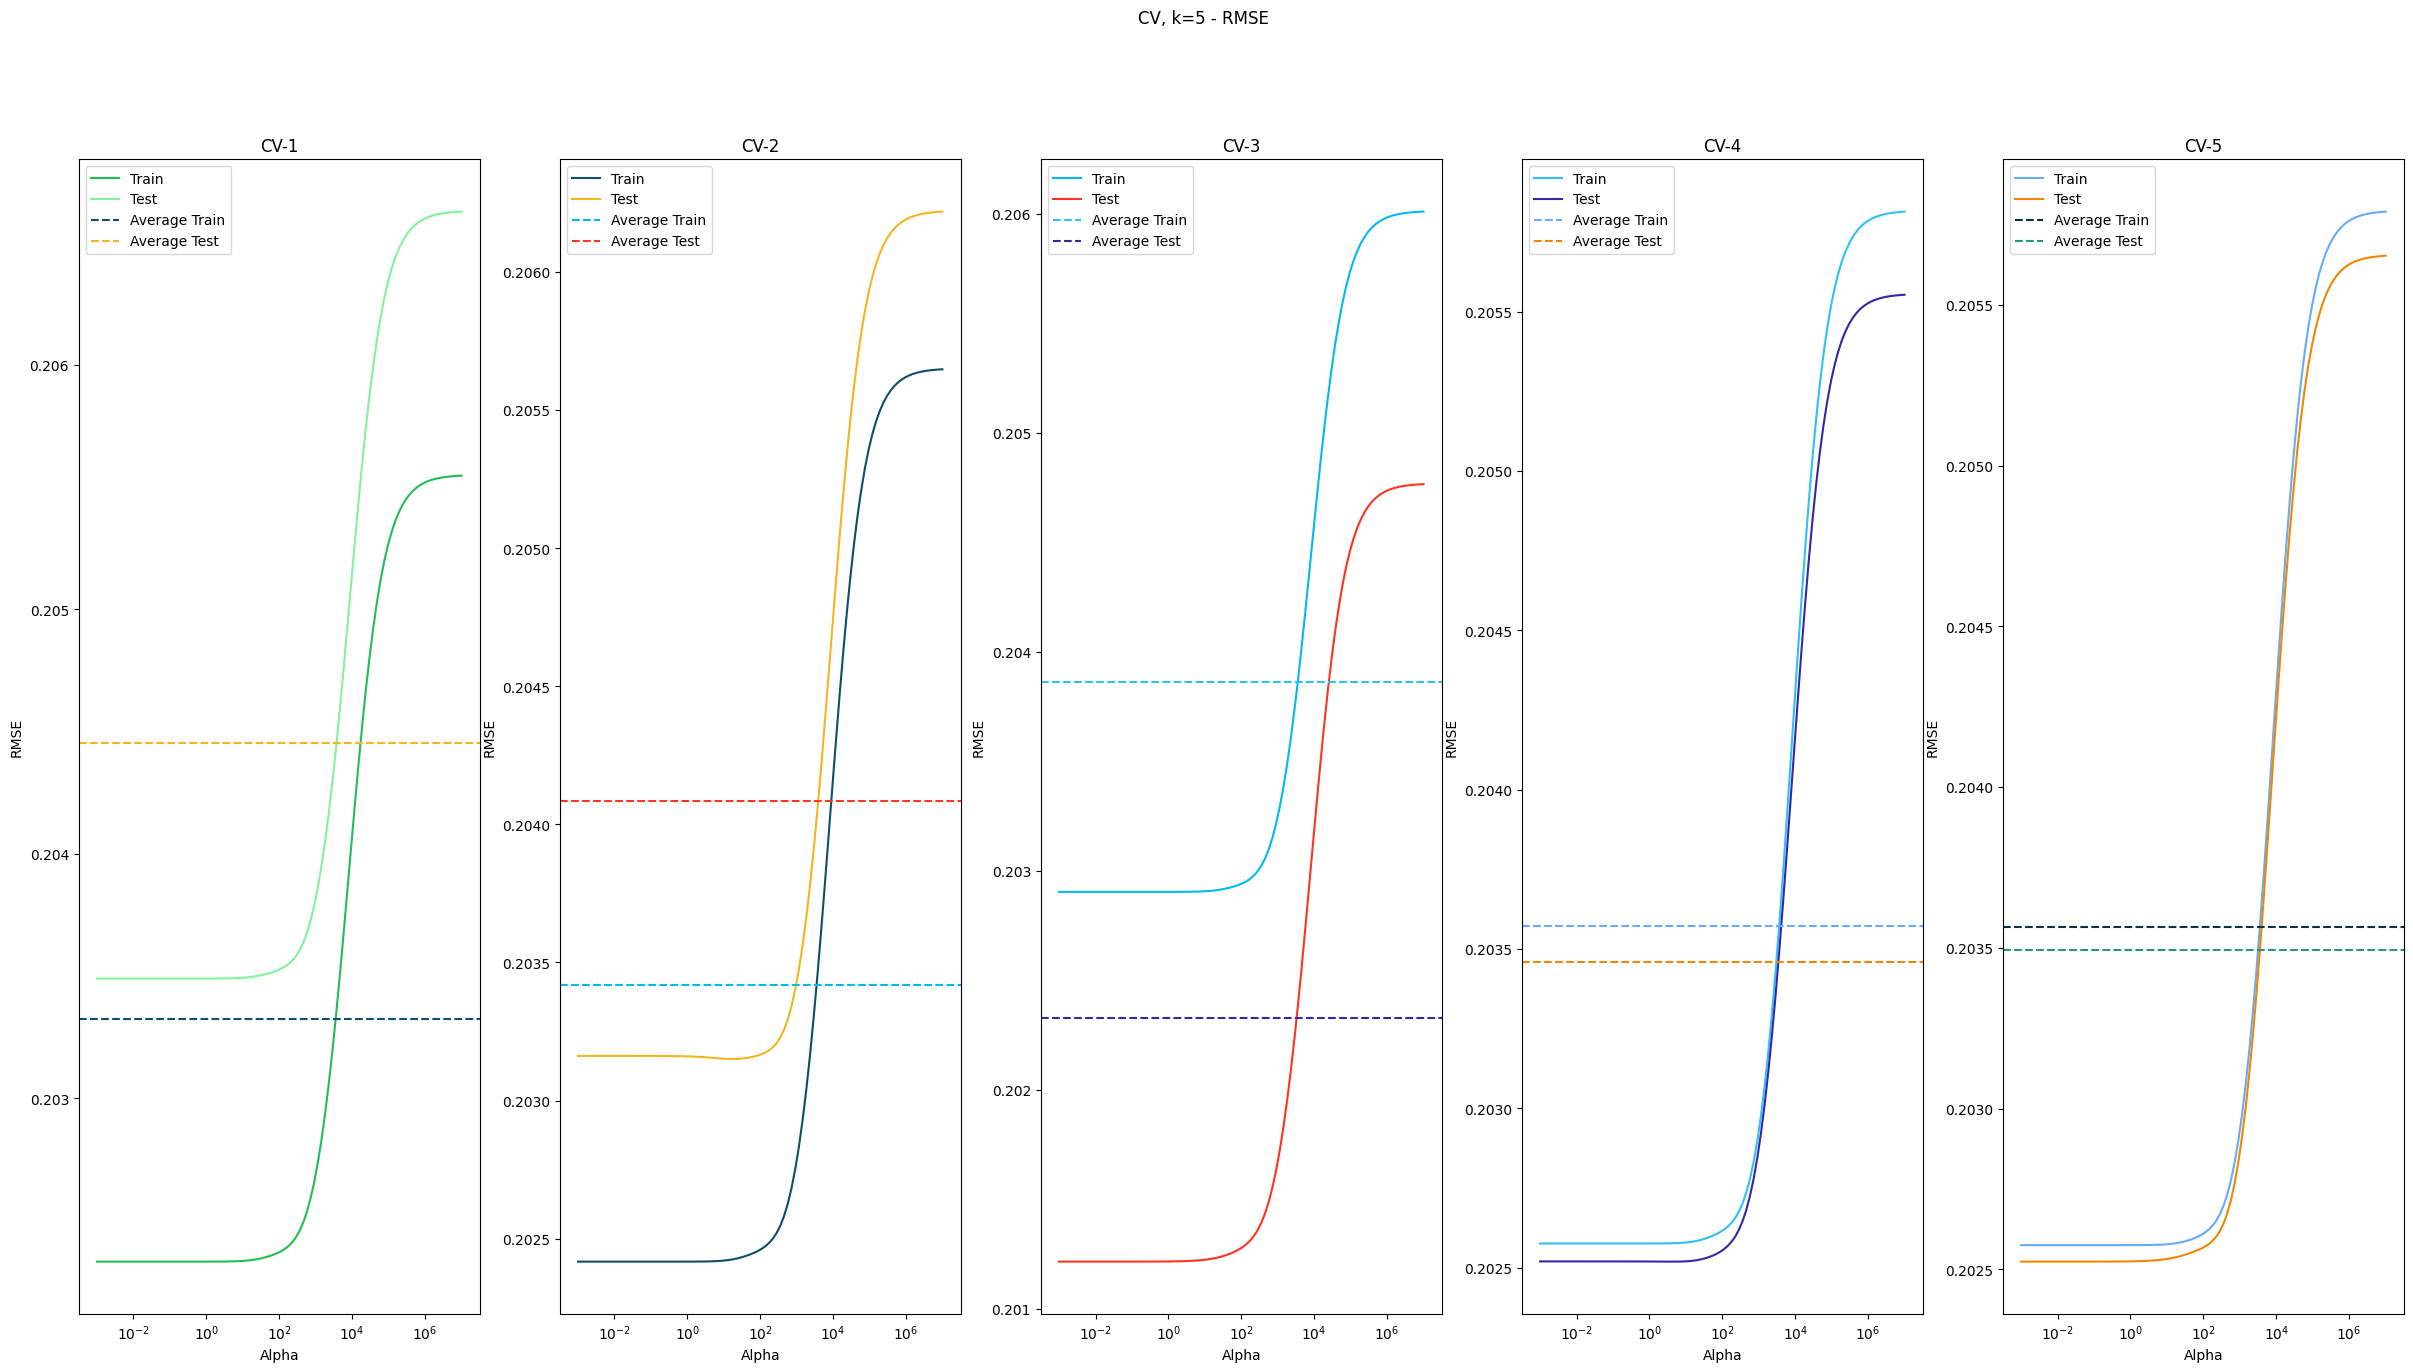

In [64]:
plot_cv_features(alphas, sk_num_results_train_rmse, sk_num_results_test_rmse, save_path_img, 'ridge_regression_numerical_features_CV_scikit_rmse.png', 'rmse')

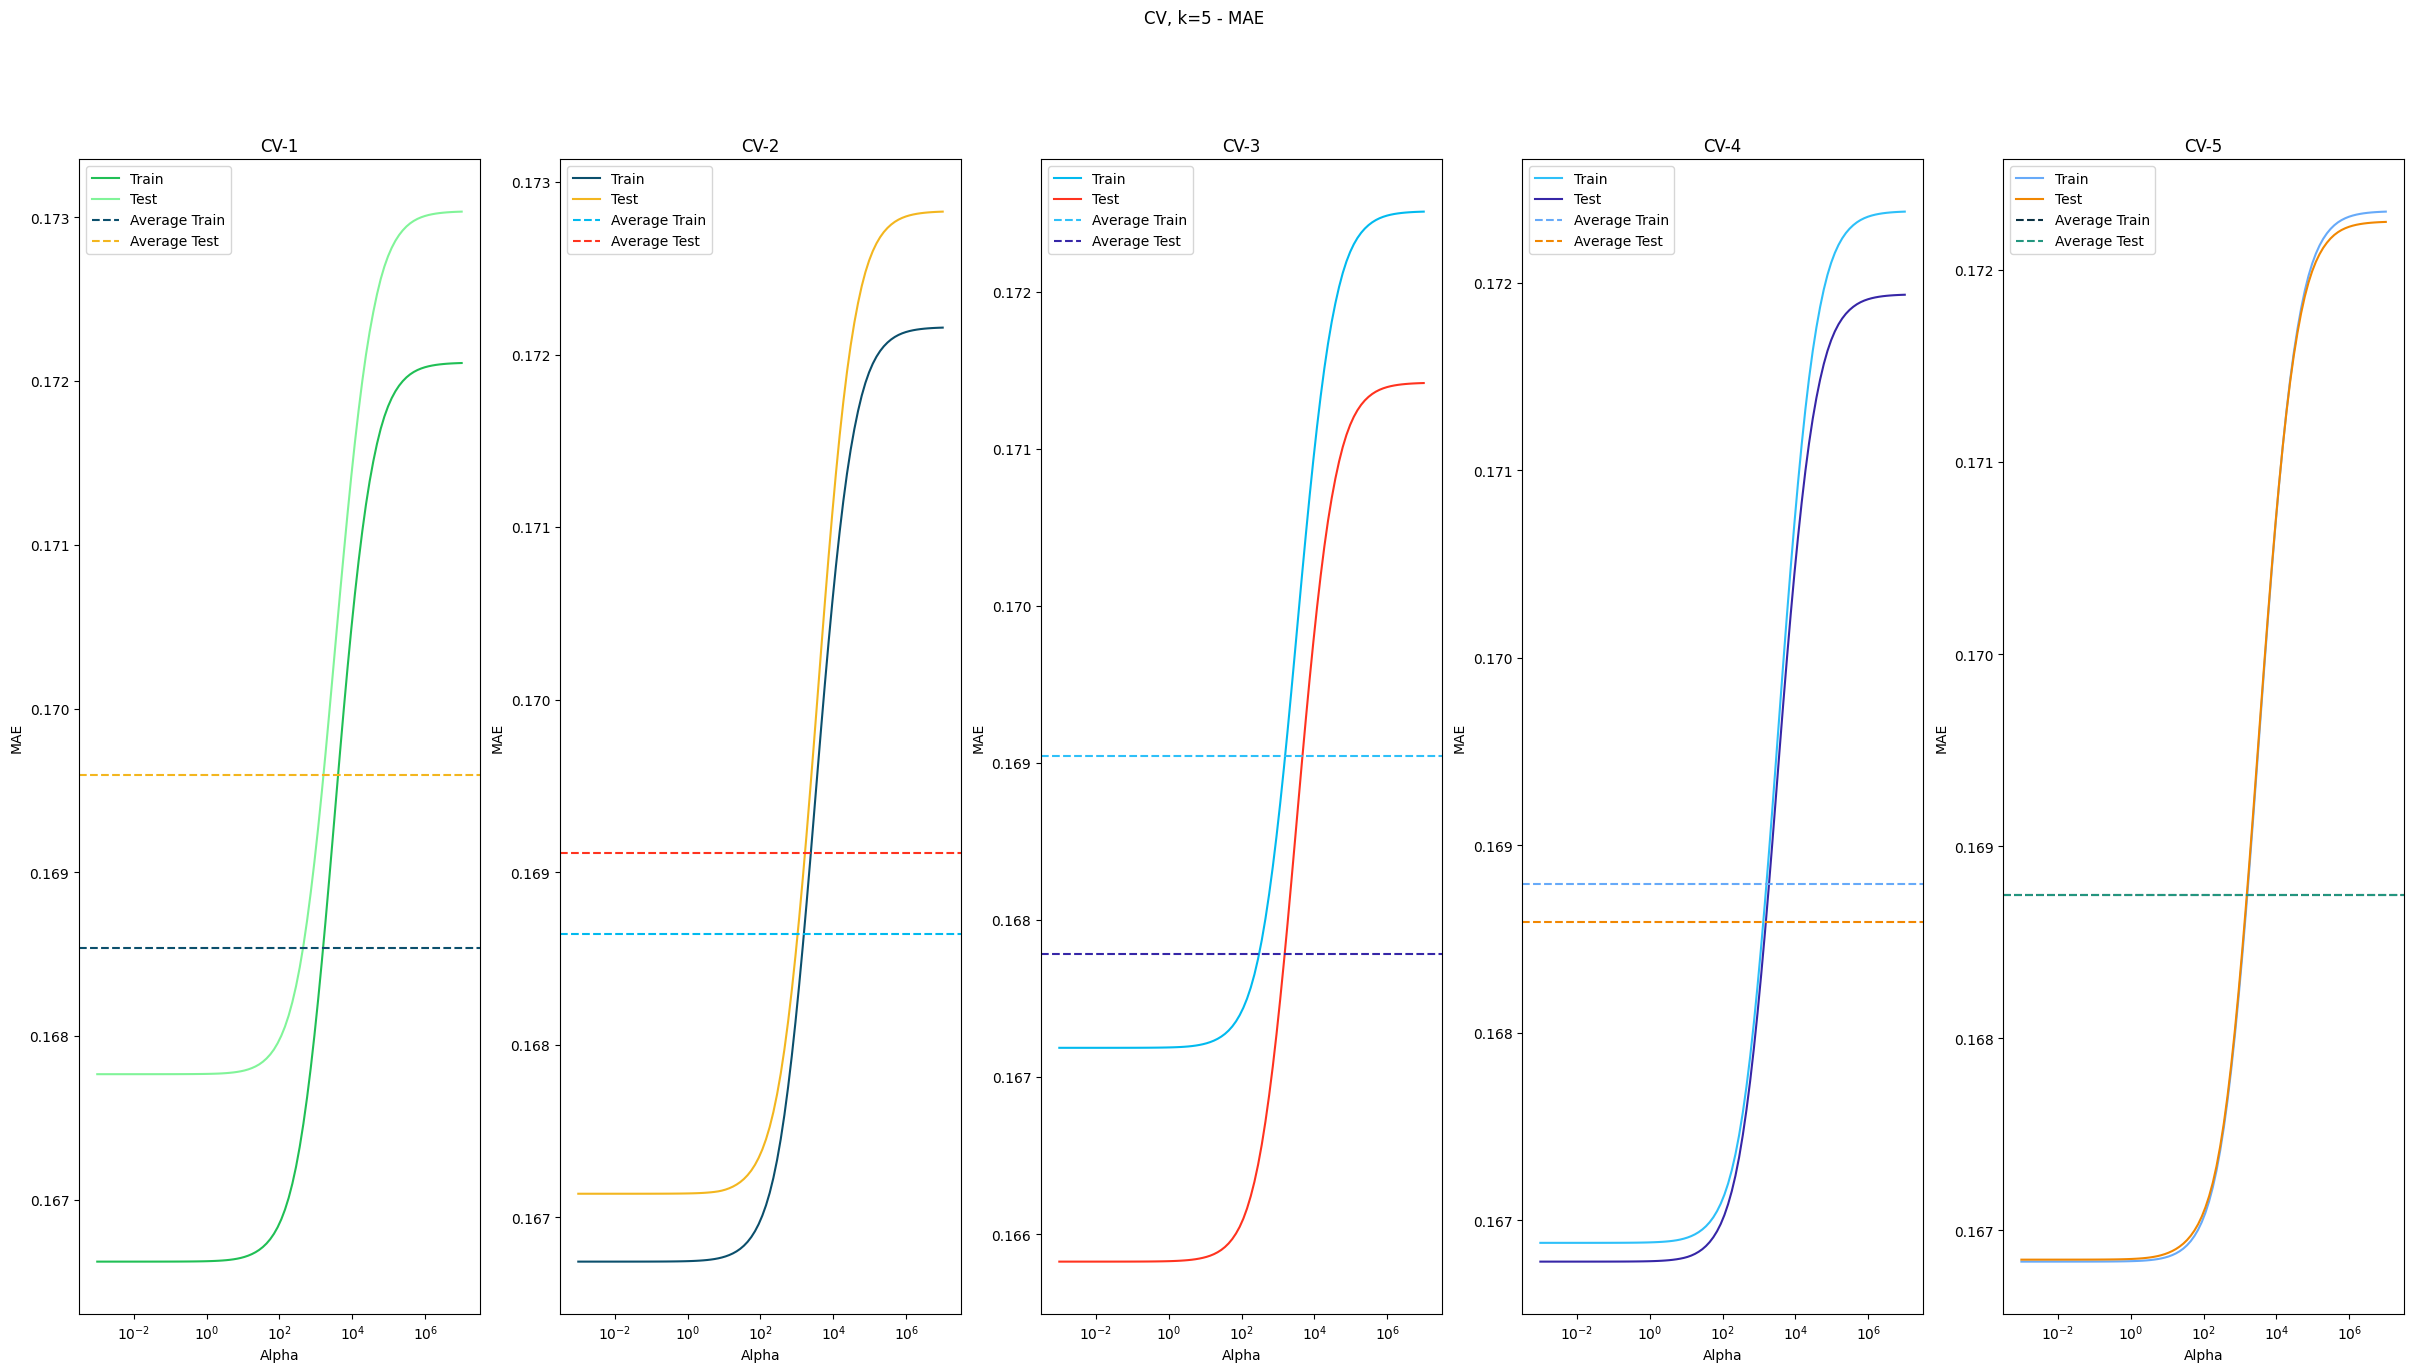

In [65]:
plot_cv_features(alphas, sk_num_results_train_mae, sk_num_results_test_mae, save_path_img, 'ridge_regression_numerical_features_CV_scikit_mae.png', 'mae')

## k-Fold Cross Validation using Scikit Model: Numerical Features Metrics Table

In [66]:
table_numerical_k_ridge_cv_validation = PrettyTable()
table_numerical_k_ridge_cv_validation.title = 'Metrics obtained from Scikit model on Numerical Features, 5-cv'
table_numerical_k_ridge_cv_validation.field_names = ["k-fold","Dataset", "Metrics", "Average", "min", "Alpha"]
table_numerical_k_ridge_cv_validation.align["k-fold"] = "l"
table_numerical_k_ridge_cv_validation.align["Dataset"] = "l"
table_numerical_k_ridge_cv_validation.align["Metrics"] = "l"
table_numerical_k_ridge_cv_validation.align["Average"] = "r"
table_numerical_k_ridge_cv_validation.align["min"] = "r"
table_numerical_k_ridge_cv_validation.align["Alpha"] = "r"

table_numerical_k_ridge_cv_validation.add_row(["1", "Train", "MSE", round(np.mean(sk_num_results_train_mse[0]), 6), round(np.min(sk_num_results_train_mse[0]),6), round(alphas[np.argmin(sk_num_results_train_mse[0])],3)])
table_numerical_k_ridge_cv_validation.add_row(["2", "Train", "MSE", round(np.mean(sk_num_results_train_mse[1]), 6), round(np.min(sk_num_results_train_mse[1]),6), round(alphas[np.argmin(sk_num_results_train_mse[1])],3)])
table_numerical_k_ridge_cv_validation.add_row(["3", "Train", "MSE", round(np.mean(sk_num_results_train_mse[2]), 6), round(np.min(sk_num_results_train_mse[2]),6), round(alphas[np.argmin(sk_num_results_train_mse[2])],3)])
table_numerical_k_ridge_cv_validation.add_row(["4", "Train", "MSE", round(np.mean(sk_num_results_train_mse[3]), 6), round(np.min(sk_num_results_train_mse[3]),6), round(alphas[np.argmin(sk_num_results_train_mse[3])],3)])
table_numerical_k_ridge_cv_validation.add_row(["5", "Train", "MSE", round(np.mean(sk_num_results_train_mse[4]), 6), round(np.min(sk_num_results_train_mse[4]),6), round(alphas[np.argmin(sk_num_results_train_mse[4])],3)], divider=True)

table_numerical_k_ridge_cv_validation.add_row(["1", "Train", "RMSE", round(np.mean(sk_num_results_train_rmse[0]), 6), round(np.min(sk_num_results_train_rmse[0]),6), round(alphas[np.argmin(sk_num_results_train_rmse[0])],3)])
table_numerical_k_ridge_cv_validation.add_row(["2", "Train", "RMSE", round(np.mean(sk_num_results_train_rmse[1]), 6), round(np.min(sk_num_results_train_rmse[1]),6), round(alphas[np.argmin(sk_num_results_train_rmse[1])],3)])
table_numerical_k_ridge_cv_validation.add_row(["3", "Train", "RMSE", round(np.mean(sk_num_results_train_rmse[2]), 6), round(np.min(sk_num_results_train_rmse[2]),6), round(alphas[np.argmin(sk_num_results_train_rmse[2])],3)])
table_numerical_k_ridge_cv_validation.add_row(["4", "Train", "RMSE", round(np.mean(sk_num_results_train_rmse[3]), 6), round(np.min(sk_num_results_train_rmse[3]),6), round(alphas[np.argmin(sk_num_results_train_rmse[3])],3)])
table_numerical_k_ridge_cv_validation.add_row(["5", "Train", "RMSE", round(np.mean(sk_num_results_train_rmse[4]), 6), round(np.min(sk_num_results_train_rmse[4]),6), round(alphas[np.argmin(sk_num_results_train_rmse[4])],3)], divider=True)

table_numerical_k_ridge_cv_validation.add_row(["1", "Train", "MAE", round(np.mean(sk_num_results_train_mae[0]), 6), round(np.min(sk_num_results_train_mae[0]),6), round(alphas[np.argmin(sk_num_results_train_mae[0])],3)])
table_numerical_k_ridge_cv_validation.add_row(["2", "Train", "MAE", round(np.mean(sk_num_results_train_mae[1]), 6), round(np.min(sk_num_results_train_mae[1]),6), round(alphas[np.argmin(sk_num_results_train_mae[1])],3)])
table_numerical_k_ridge_cv_validation.add_row(["3", "Train", "MAE", round(np.mean(sk_num_results_train_mae[2]), 6), round(np.min(sk_num_results_train_mae[2]),6), round(alphas[np.argmin(sk_num_results_train_mae[2])],3)])
table_numerical_k_ridge_cv_validation.add_row(["4", "Train", "MAE", round(np.mean(sk_num_results_train_mae[3]), 6), round(np.min(sk_num_results_train_mae[3]),6), round(alphas[np.argmin(sk_num_results_train_mae[3])],3)])
table_numerical_k_ridge_cv_validation.add_row(["5", "Train", "MAE", round(np.mean(sk_num_results_train_mae[4]), 6), round(np.min(sk_num_results_train_mae[4]),6), round(alphas[np.argmin(sk_num_results_train_mae[4])],3)], divider=True)

table_numerical_k_ridge_cv_validation.add_row(["1", "Test", "MSE", round(np.mean(sk_num_results_test_mse[0]), 6), round(np.min(sk_num_results_test_mse[0]),6), round(alphas[np.argmin(sk_num_results_test_mse[0])],3)])
table_numerical_k_ridge_cv_validation.add_row(["2", "Test", "MSE", round(np.mean(sk_num_results_test_mse[1]), 6), round(np.min(sk_num_results_test_mse[1]),6), round(alphas[np.argmin(sk_num_results_test_mse[1])],3)])
table_numerical_k_ridge_cv_validation.add_row(["3", "Test", "MSE", round(np.mean(sk_num_results_test_mse[2]), 6), round(np.min(sk_num_results_test_mse[2]),6), round(alphas[np.argmin(sk_num_results_test_mse[2])],3)])
table_numerical_k_ridge_cv_validation.add_row(["4", "Test", "MSE", round(np.mean(sk_num_results_test_mse[3]), 6), round(np.min(sk_num_results_test_mse[3]),6), round(alphas[np.argmin(sk_num_results_test_mse[3])],3)])
table_numerical_k_ridge_cv_validation.add_row(["5", "Test", "MSE", round(np.mean(sk_num_results_test_mse[4]), 6), round(np.min(sk_num_results_test_mse[4]),6), round(alphas[np.argmin(sk_num_results_test_mse[4])],3)], divider=True)

table_numerical_k_ridge_cv_validation.add_row(["1", "Test", "RMSE", round(np.mean(sk_num_results_test_rmse[0]), 6), round(np.min(sk_num_results_test_rmse[0]),6), round(alphas[np.argmin(sk_num_results_test_rmse[0])],3)])
table_numerical_k_ridge_cv_validation.add_row(["2", "Test", "RMSE", round(np.mean(sk_num_results_test_rmse[1]), 6), round(np.min(sk_num_results_test_rmse[1]),6), round(alphas[np.argmin(sk_num_results_test_rmse[1])],3)])
table_numerical_k_ridge_cv_validation.add_row(["3", "Test", "RMSE", round(np.mean(sk_num_results_test_rmse[2]), 6), round(np.min(sk_num_results_test_rmse[2]),6), round(alphas[np.argmin(sk_num_results_test_rmse[2])],3)])
table_numerical_k_ridge_cv_validation.add_row(["4", "Test", "RMSE", round(np.mean(sk_num_results_test_rmse[3]), 6), round(np.min(sk_num_results_test_rmse[3]),6), round(alphas[np.argmin(sk_num_results_test_rmse[3])],3)])
table_numerical_k_ridge_cv_validation.add_row(["5", "Test", "RMSE", round(np.mean(sk_num_results_test_rmse[4]), 6), round(np.min(sk_num_results_test_rmse[4]),6), round(alphas[np.argmin(sk_num_results_test_rmse[4])],3)], divider=True)

table_numerical_k_ridge_cv_validation.add_row(["1", "Test", "MAE", round(np.mean(sk_num_results_test_mae[0]), 6), round(np.min(sk_num_results_test_mae[0]),6), round(alphas[np.argmin(sk_num_results_test_mae[0])],3)])
table_numerical_k_ridge_cv_validation.add_row(["2", "Test", "MAE", round(np.mean(sk_num_results_test_mae[1]), 6), round(np.min(sk_num_results_test_mae[1]),6), round(alphas[np.argmin(sk_num_results_test_mae[1])],3)])
table_numerical_k_ridge_cv_validation.add_row(["3", "Test", "MAE", round(np.mean(sk_num_results_test_mae[2]), 6), round(np.min(sk_num_results_test_mae[2]),6), round(alphas[np.argmin(sk_num_results_test_mae[2])],3)])
table_numerical_k_ridge_cv_validation.add_row(["4", "Test", "MAE", round(np.mean(sk_num_results_test_mae[3]), 6), round(np.min(sk_num_results_test_mae[3]),6), round(alphas[np.argmin(sk_num_results_test_mae[3])],3)])
table_numerical_k_ridge_cv_validation.add_row(["5", "Test", "MAE", round(np.mean(sk_num_results_test_mae[4]), 6), round(np.min(sk_num_results_test_mae[4]),6), round(alphas[np.argmin(sk_num_results_test_mae[4])],3)], divider=True)

table_numerical_k_ridge_cv_validation

k-fold,Dataset,Metrics,Average,min,Alpha
1,Train,MSE,0.041343,0.040939,0.001
2,Train,MSE,0.04138,0.040973,0.001
3,Train,MSE,0.041562,0.04117,0.001
4,Train,MSE,0.041444,0.041037,0.001
5,Train,MSE,0.041441,0.041037,0.001
1,Train,RMSE,0.203326,0.202333,0.001
2,Train,RMSE,0.203417,0.202417,0.001
3,Train,RMSE,0.203863,0.202903,0.001
4,Train,RMSE,0.203573,0.202576,0.001
5,Train,RMSE,0.203566,0.202576,0.001


## k-Fold Cross Validation using Scikit Model: Categorical Features Representation

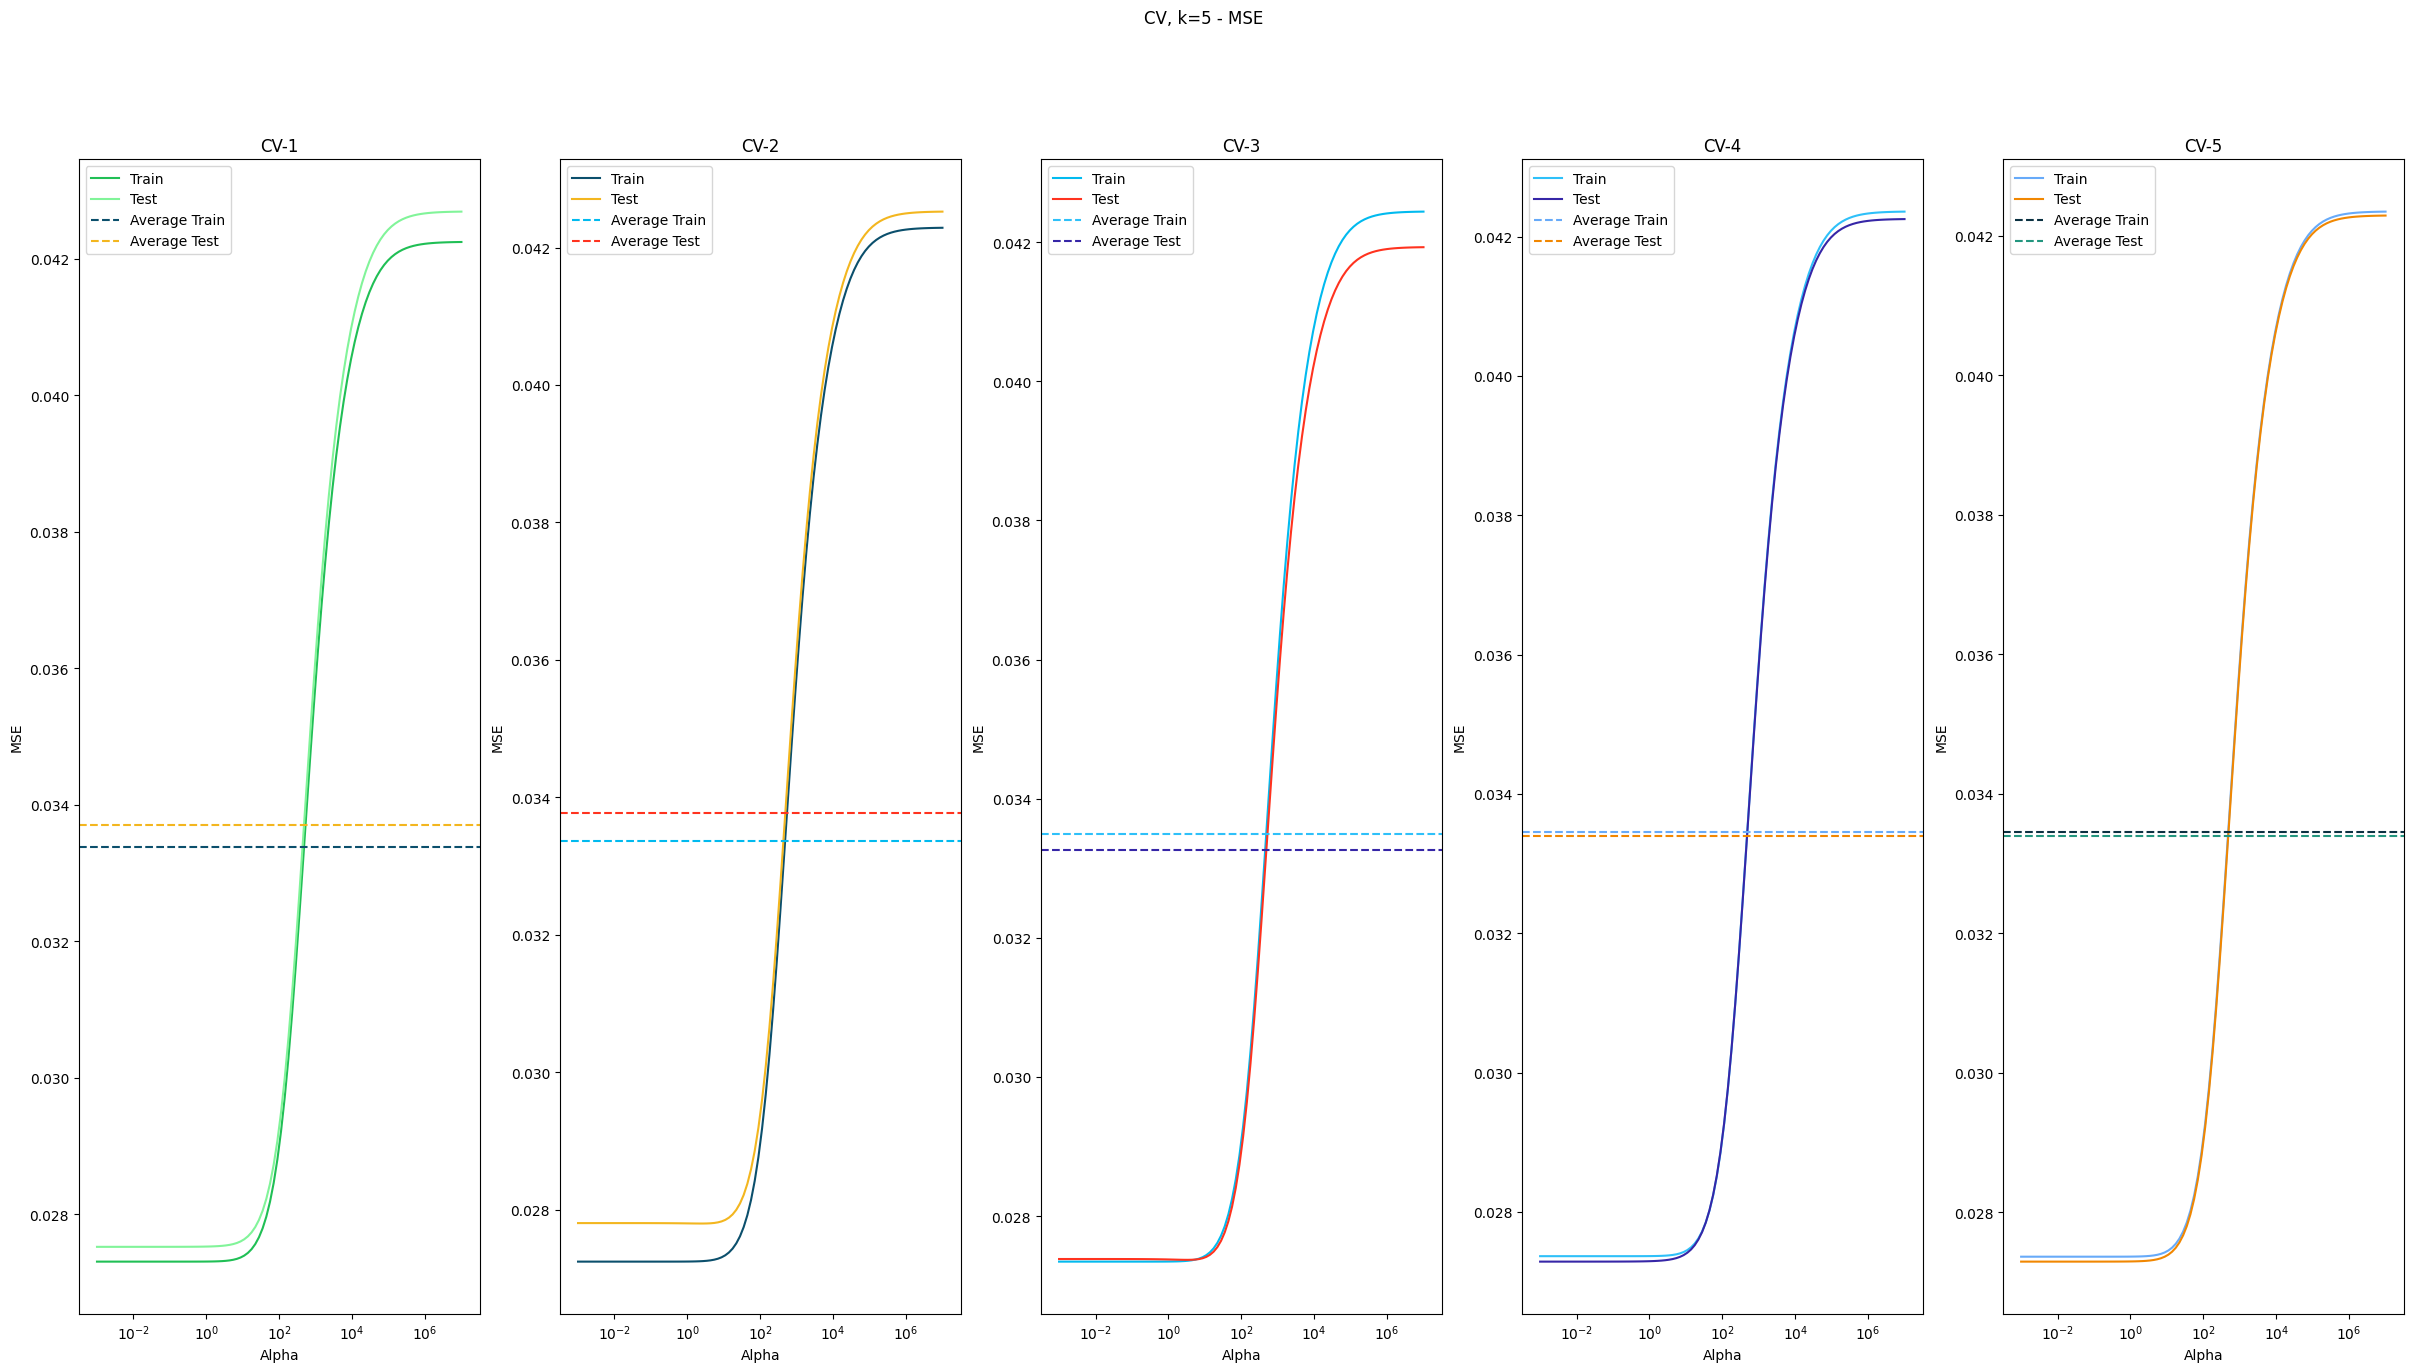

In [67]:
plot_cv_features(alphas, sk_cat_results_train_mse, sk_cat_results_test_mse, save_path_img, 'ridge_regression_categorical_features_CV_scikit_mse.png', 'mse')

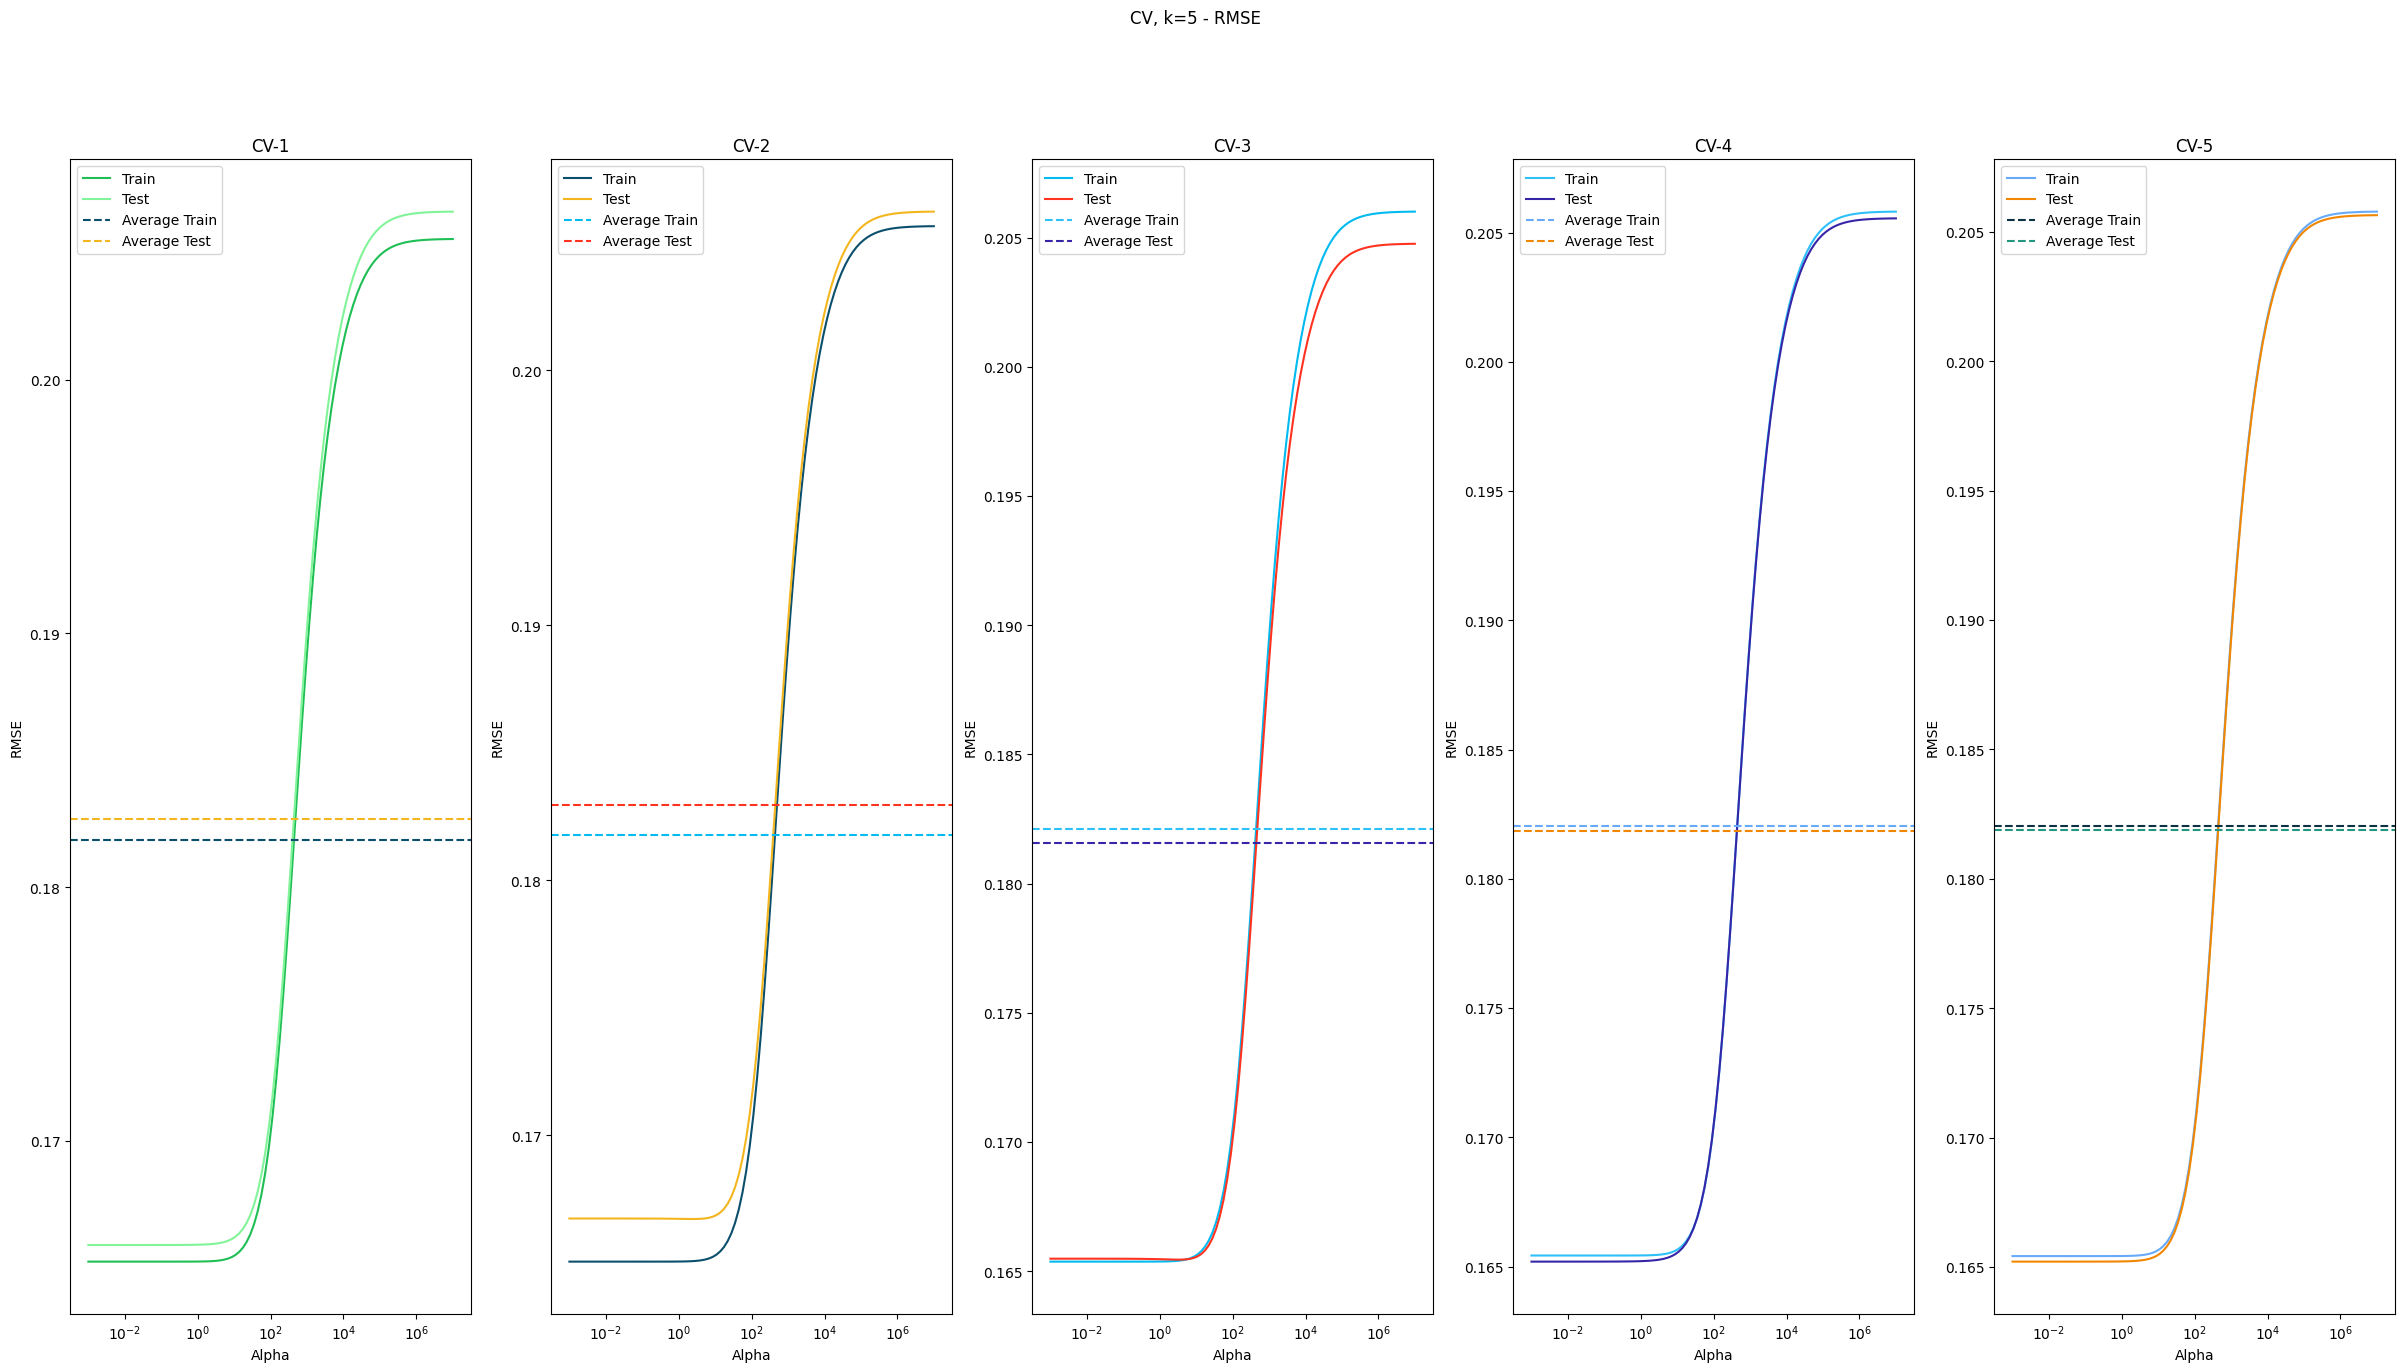

In [68]:
plot_cv_features(alphas, sk_cat_results_train_rmse, sk_cat_results_test_rmse, save_path_img, 'ridge_regression_categorical_features_CV_scikit_rmse.png', 'rmse')

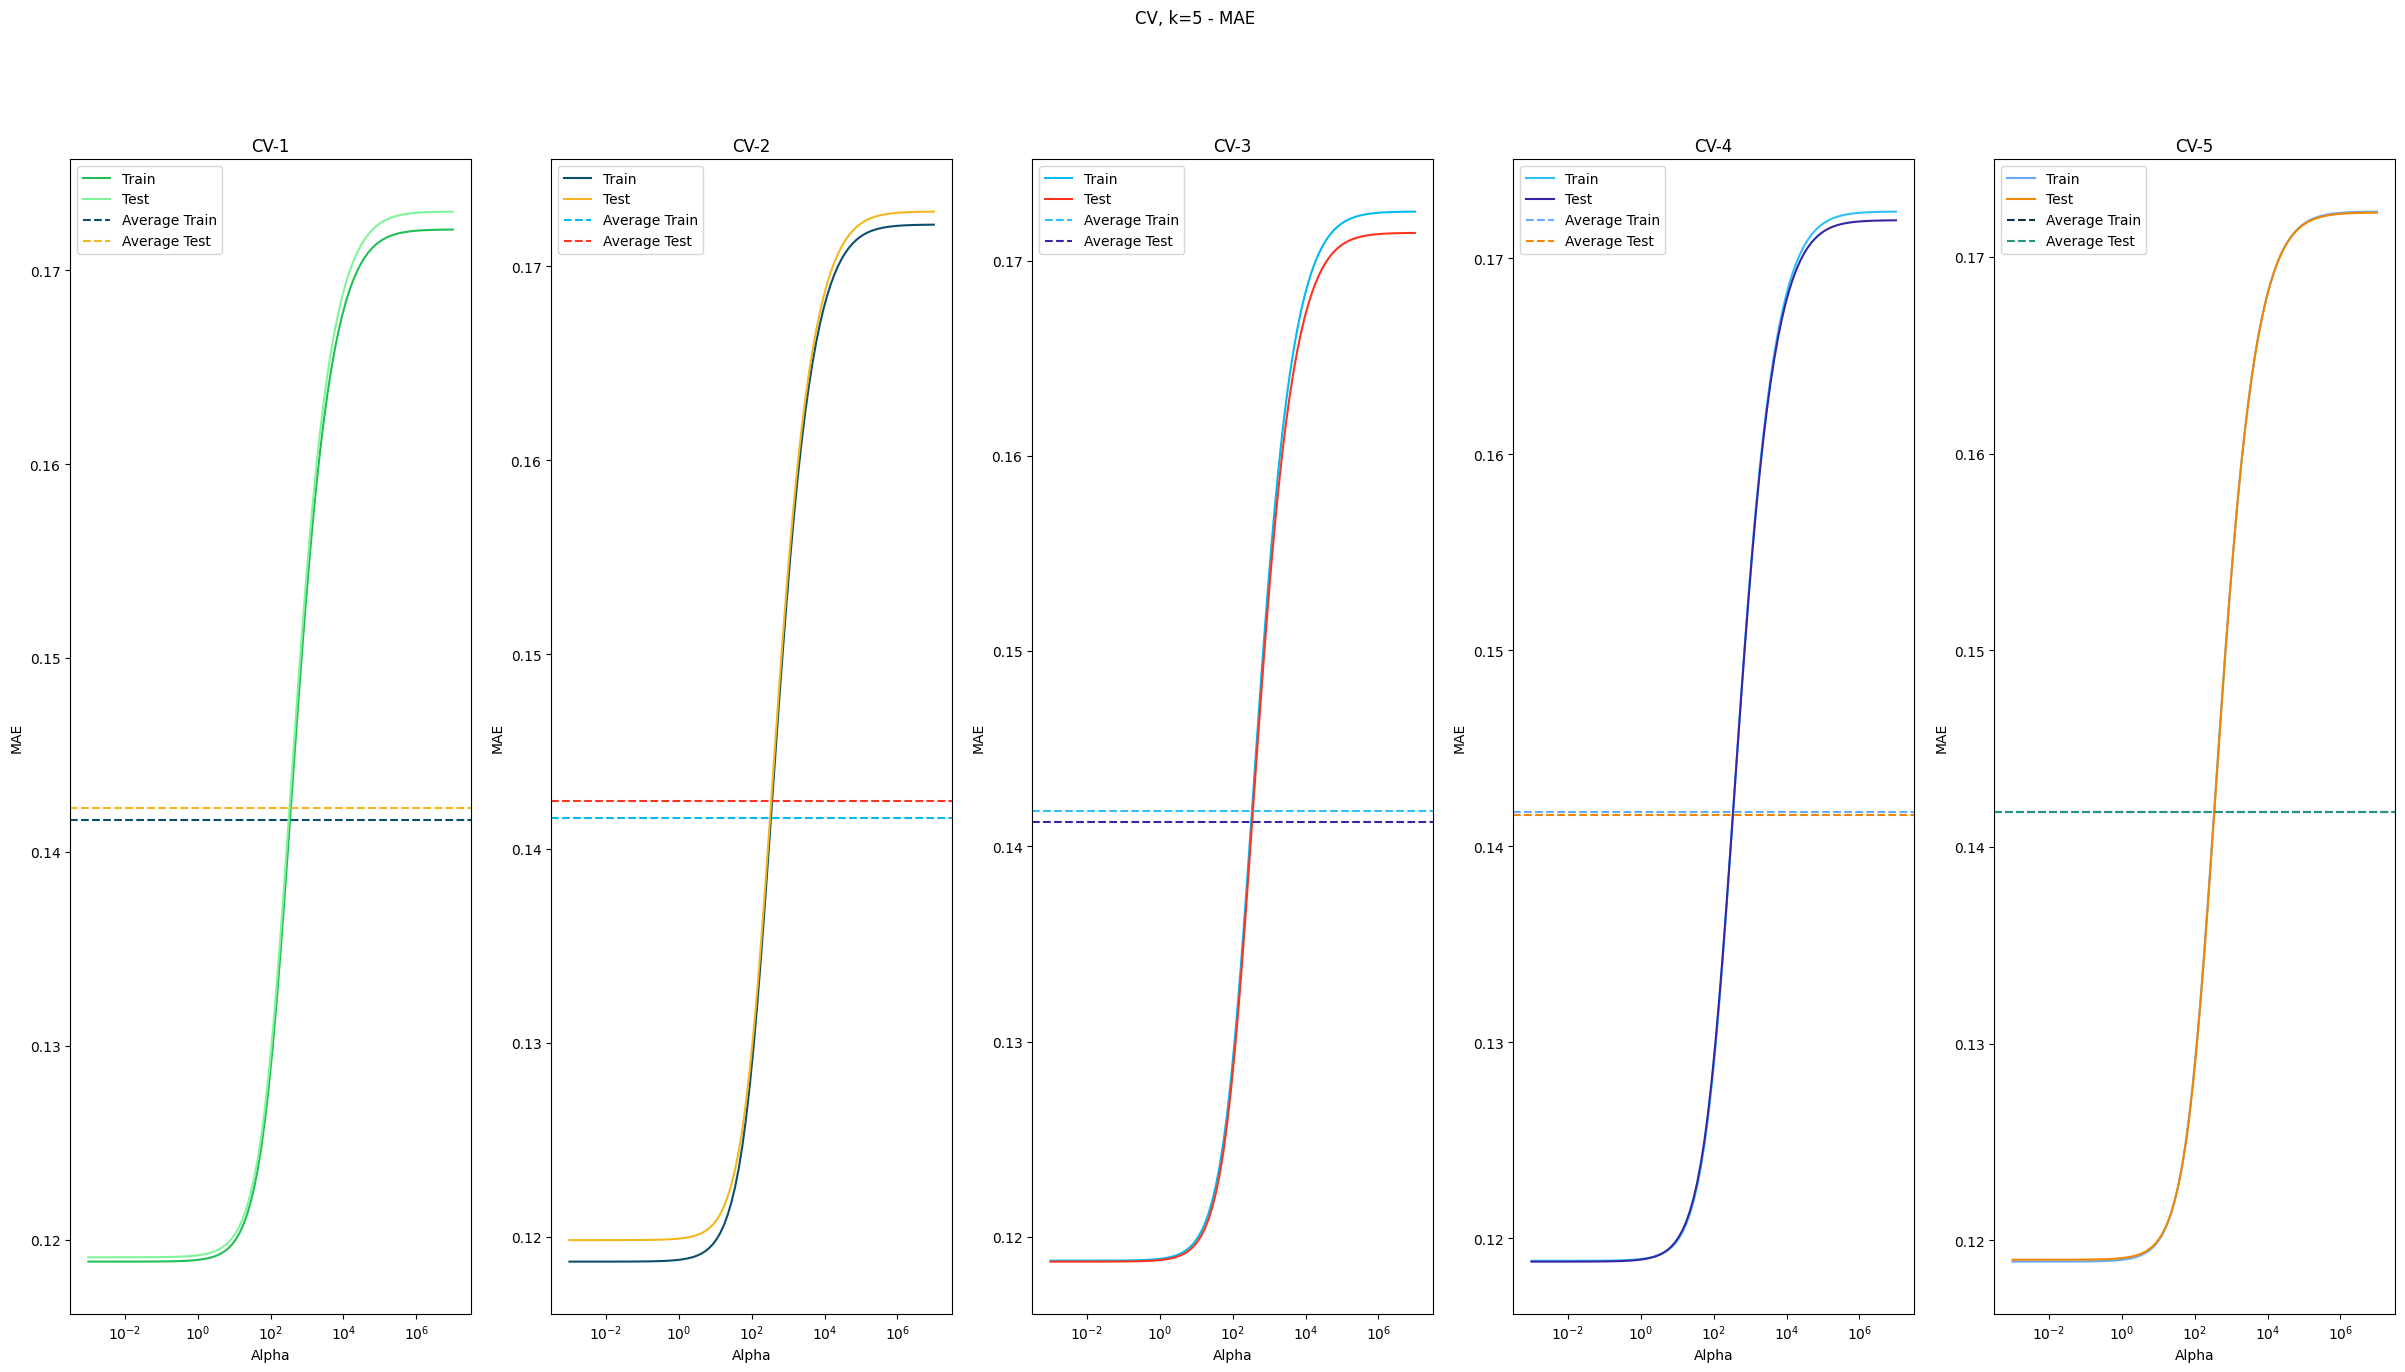

In [69]:
plot_cv_features(alphas, sk_cat_results_train_mae, sk_cat_results_test_mae, save_path_img, 'ridge_regression_categorical_features_CV_scikit_mae.png', 'mae')

## k-Fold Cross Validation using Scikit Model: Categorical Features Metrics Table

In [70]:
table_categorical_k_ridge_cv_validation = PrettyTable()
table_categorical_k_ridge_cv_validation.title = 'Metrics obtained from Scikit model on Categorical features, 5-cv'
table_categorical_k_ridge_cv_validation.field_names = ["k-fold","Dataset", "Metrics", "Average", "min", "Alpha"]
table_categorical_k_ridge_cv_validation.align["k-fold"] = "l"
table_categorical_k_ridge_cv_validation.align["Dataset"] = "l"
table_categorical_k_ridge_cv_validation.align["Metrics"] = "l"
table_categorical_k_ridge_cv_validation.align["Average"] = "r"
table_categorical_k_ridge_cv_validation.align["min"] = "r"
table_categorical_k_ridge_cv_validation.align["Alpha"] = "r"

table_categorical_k_ridge_cv_validation.add_row(["1", "Train", "MSE", round(np.mean(sk_cat_results_train_mse[0]), 6), round(np.min(sk_cat_results_train_mse[0]),6), round(alphas[np.argmin(sk_cat_results_train_mse[0])],3)])
table_categorical_k_ridge_cv_validation.add_row(["2", "Train", "MSE", round(np.mean(sk_cat_results_train_mse[1]), 6), round(np.min(sk_cat_results_train_mse[1]),6), round(alphas[np.argmin(sk_cat_results_train_mse[1])],3)])
table_categorical_k_ridge_cv_validation.add_row(["3", "Train", "MSE", round(np.mean(sk_cat_results_train_mse[2]), 6), round(np.min(sk_cat_results_train_mse[2]),6), round(alphas[np.argmin(sk_cat_results_train_mse[2])],3)])
table_categorical_k_ridge_cv_validation.add_row(["4", "Train", "MSE", round(np.mean(sk_cat_results_train_mse[3]), 6), round(np.min(sk_cat_results_train_mse[3]),6), round(alphas[np.argmin(sk_cat_results_train_mse[3])],3)])
table_categorical_k_ridge_cv_validation.add_row(["5", "Train", "MSE", round(np.mean(sk_cat_results_train_mse[4]), 6), round(np.min(sk_cat_results_train_mse[4]),6), round(alphas[np.argmin(sk_cat_results_train_mse[4])],3)], divider=True)

table_categorical_k_ridge_cv_validation.add_row(["1", "Train", "RMSE", round(np.mean(sk_cat_results_train_rmse[0]), 6), round(np.min(sk_cat_results_train_rmse[0]),6), round(alphas[np.argmin(sk_cat_results_train_rmse[0])],3)])
table_categorical_k_ridge_cv_validation.add_row(["2", "Train", "RMSE", round(np.mean(sk_cat_results_train_rmse[1]), 6), round(np.min(sk_cat_results_train_rmse[1]),6), round(alphas[np.argmin(sk_cat_results_train_rmse[1])],3)])
table_categorical_k_ridge_cv_validation.add_row(["3", "Train", "RMSE", round(np.mean(sk_cat_results_train_rmse[2]), 6), round(np.min(sk_cat_results_train_rmse[2]),6), round(alphas[np.argmin(sk_cat_results_train_rmse[2])],3)])
table_categorical_k_ridge_cv_validation.add_row(["4", "Train", "RMSE", round(np.mean(sk_cat_results_train_rmse[3]), 6), round(np.min(sk_cat_results_train_rmse[3]),6), round(alphas[np.argmin(sk_cat_results_train_rmse[3])],3)])
table_categorical_k_ridge_cv_validation.add_row(["5", "Train", "RMSE", round(np.mean(sk_cat_results_train_rmse[4]), 6), round(np.min(sk_cat_results_train_rmse[4]),6), round(alphas[np.argmin(sk_cat_results_train_rmse[4])],3)], divider=True)

table_categorical_k_ridge_cv_validation.add_row(["1", "Train", "MAE", round(np.mean(sk_cat_results_train_mae[0]), 6), round(np.min(sk_cat_results_train_mae[0]),6), round(alphas[np.argmin(sk_cat_results_train_mae[0])],3)])
table_categorical_k_ridge_cv_validation.add_row(["2", "Train", "MAE", round(np.mean(sk_cat_results_train_mae[1]), 6), round(np.min(sk_cat_results_train_mae[1]),6), round(alphas[np.argmin(sk_cat_results_train_mae[1])],3)])
table_categorical_k_ridge_cv_validation.add_row(["3", "Train", "MAE", round(np.mean(sk_cat_results_train_mae[2]), 6), round(np.min(sk_cat_results_train_mae[2]),6), round(alphas[np.argmin(sk_cat_results_train_mae[2])],3)])
table_categorical_k_ridge_cv_validation.add_row(["4", "Train", "MAE", round(np.mean(sk_cat_results_train_mae[3]), 6), round(np.min(sk_cat_results_train_mae[3]),6), round(alphas[np.argmin(sk_cat_results_train_mae[3])],3)])
table_categorical_k_ridge_cv_validation.add_row(["5", "Train", "MAE", round(np.mean(sk_cat_results_train_mae[4]), 6), round(np.min(sk_cat_results_train_mae[4]),6), round(alphas[np.argmin(sk_cat_results_train_mae[4])],3)], divider=True)

table_categorical_k_ridge_cv_validation.add_row(["1", "Test", "MSE", round(np.mean(sk_cat_results_test_mse[0]), 6), round(np.min(sk_cat_results_test_mse[0]),6), round(alphas[np.argmin(sk_cat_results_test_mse[0])],3)])
table_categorical_k_ridge_cv_validation.add_row(["2", "Test", "MSE", round(np.mean(sk_cat_results_test_mse[1]), 6), round(np.min(sk_cat_results_test_mse[1]),6), round(alphas[np.argmin(sk_cat_results_test_mse[1])],3)])
table_categorical_k_ridge_cv_validation.add_row(["3", "Test", "MSE", round(np.mean(sk_cat_results_test_mse[2]), 6), round(np.min(sk_cat_results_test_mse[2]),6), round(alphas[np.argmin(sk_cat_results_test_mse[2])],3)])
table_categorical_k_ridge_cv_validation.add_row(["4", "Test", "MSE", round(np.mean(sk_cat_results_test_mse[3]), 6), round(np.min(sk_cat_results_test_mse[3]),6), round(alphas[np.argmin(sk_cat_results_test_mse[3])],3)])
table_categorical_k_ridge_cv_validation.add_row(["5", "Test", "MSE", round(np.mean(sk_cat_results_test_mse[4]), 6), round(np.min(sk_cat_results_test_mse[4]),6), round(alphas[np.argmin(sk_cat_results_test_mse[4])],3)], divider=True)

table_categorical_k_ridge_cv_validation.add_row(["1", "Test", "RMSE", round(np.mean(sk_cat_results_test_rmse[0]), 6), round(np.min(sk_cat_results_test_rmse[0]),6), round(alphas[np.argmin(sk_cat_results_test_rmse[0])],3)])
table_categorical_k_ridge_cv_validation.add_row(["2", "Test", "RMSE", round(np.mean(sk_cat_results_test_rmse[1]), 6), round(np.min(sk_cat_results_test_rmse[1]),6), round(alphas[np.argmin(sk_cat_results_test_rmse[1])],3)])
table_categorical_k_ridge_cv_validation.add_row(["3", "Test", "RMSE", round(np.mean(sk_cat_results_test_rmse[2]), 6), round(np.min(sk_cat_results_test_rmse[2]),6), round(alphas[np.argmin(sk_cat_results_test_rmse[2])],3)])
table_categorical_k_ridge_cv_validation.add_row(["4", "Test", "RMSE", round(np.mean(sk_cat_results_test_rmse[3]), 6), round(np.min(sk_cat_results_test_rmse[3]),6), round(alphas[np.argmin(sk_cat_results_test_rmse[3])],3)])
table_categorical_k_ridge_cv_validation.add_row(["5", "Test", "RMSE", round(np.mean(sk_cat_results_test_rmse[4]), 6), round(np.min(sk_cat_results_test_rmse[4]),6), round(alphas[np.argmin(sk_cat_results_test_rmse[4])],3)], divider=True)

table_categorical_k_ridge_cv_validation.add_row(["1", "Test", "MAE", round(np.mean(sk_cat_results_test_mae[0]), 6), round(np.min(sk_cat_results_test_mae[0]),6), round(alphas[np.argmin(sk_cat_results_test_mae[0])],3)])
table_categorical_k_ridge_cv_validation.add_row(["2", "Test", "MAE", round(np.mean(sk_cat_results_test_mae[1]), 6), round(np.min(sk_cat_results_test_mae[1]),6), round(alphas[np.argmin(sk_cat_results_test_mae[1])],3)])
table_categorical_k_ridge_cv_validation.add_row(["3", "Test", "MAE", round(np.mean(sk_cat_results_test_mae[2]), 6), round(np.min(sk_cat_results_test_mae[2]),6), round(alphas[np.argmin(sk_cat_results_test_mae[2])],3)])
table_categorical_k_ridge_cv_validation.add_row(["4", "Test", "MAE", round(np.mean(sk_cat_results_test_mae[3]), 6), round(np.min(sk_cat_results_test_mae[3]),6), round(alphas[np.argmin(sk_cat_results_test_mae[3])],3)])
table_categorical_k_ridge_cv_validation.add_row(["5", "Test", "MAE", round(np.mean(sk_cat_results_test_mae[4]), 6), round(np.min(sk_cat_results_test_mae[4]),6), round(alphas[np.argmin(sk_cat_results_test_mae[4])],3)], divider=True)

table_categorical_k_ridge_cv_validation

k-fold,Dataset,Metrics,Average,min,Alpha
1,Train,MSE,0.033384,0.027305,0.001
2,Train,MSE,0.033365,0.027242,0.001
3,Train,MSE,0.033489,0.027347,0.001
4,Train,MSE,0.033461,0.027367,0.001
5,Train,MSE,0.033459,0.027364,0.001
1,Train,RMSE,0.18184,0.165242,0.001
2,Train,RMSE,0.181775,0.165052,0.001
3,Train,RMSE,0.182113,0.165368,0.001
4,Train,RMSE,0.182047,0.165429,0.001
5,Train,RMSE,0.182043,0.16542,0.001


# Computational Time\End

In [71]:
end = timer()

print("Computational time is:","{:.2f} minutes.".format((end - start)/60))

Computational time is: 16.61 minutes.
